In [18]:
from fenics import *
from dolfin import *
import matplotlib.pyplot as plt
import time
import numpy as np

In [19]:
def Cumulative(lists):
    cu_list = []
    length = len(lists)
    cu_list = [sum(lists[0:x:1]) for x in range(0, length+1)]
    return cu_list[1:]

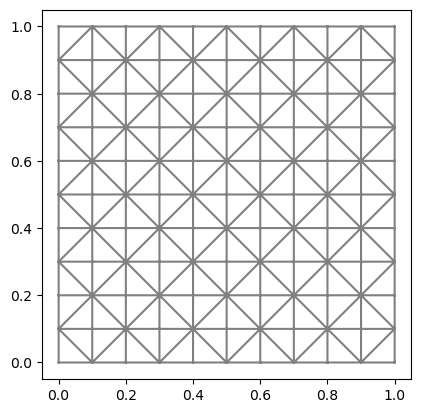

In [20]:
mesh = UnitSquareMesh(10, 10, "right/left")
plot(mesh)

In [21]:
def left_boundary(x, on_boundary):
    return on_boundary and near(x[0], 0.)

class Right(SubDomain):
    def inside(self, x, on_boundary):
        return near(x[0], 1.0)

In [22]:
VFS = VectorFunctionSpace(mesh, "P", dim=2, degree=1)

bc_left = DirichletBC(VFS, ((0., 0.)), left_boundary)

# mark right boundary subdomain with marker 1
right = Right()
boundaries = MeshFunction("size_t", mesh, 1)
boundaries.set_all(0)
right.mark(boundaries, 1)
ds = Measure('ds', domain=mesh, subdomain_data=boundaries)

In [23]:
E = 1.
nu = 0.3
mu = E/(2*(1+nu))
Lambda = E*nu/((1-2*nu)*(1+nu))


def elastic_energy_density(u):
    dim = 2
    A = (grad(u) + Identity(dim))
    #right cauchy-green tensor
    C = A.T*A
    J = det(A)
    #elastic energy density
    psi = (Lambda/2)*(ln(J))**2 + (mu/2)*(tr(C)-dim-2*ln(J))
    return psi

In [24]:
u_init = Function(VFS)
t = Expression(("k", 0.0), k=0., degree=1)
free_energy = elastic_energy_density(u_init)*dx - dot(t, u_init)*ds(1)
residual = derivative(free_energy, u_init)
assemble(free_energy)

0.0

# First tiny step
   * First step made with constant increment because we need to have a converged solution as initial condition to arc length method
   * We use the data from this step to get the dimensions of the ellipsoid in the arc length method

In [25]:
u_first = Function(VFS)
u_second = Function(VFS)
init_load_delta = 0.001
load_first = 0.0

t.k = load_first
solve(residual == 0, u_init, [bc_left])
u_first.vector()[:] = u_init.vector()[:]

t.k = load_first + init_load_delta
solve(residual == 1e-5, u_init, [bc_left])
u_second.vector()[:] = u_init.vector()[:]

    No Jacobian form specified for nonlinear variational problem.
    Differentiating residual form F to obtain Jacobian J = F'.
    Solving nonlinear variational problem.
      Newton iteration 0: r (abs) = 0.000e+00 (tol = 1.000e-10) r (rel) = -nan (tol = 1.000e-09)
      Newton solver finished in 0 iterations and 0 linear solver iterations.
    No Jacobian form specified for nonlinear variational problem.
    Differentiating residual form F to obtain Jacobian J = F'.
    Solving nonlinear variational problem.
      Newton iteration 0: r (abs) = 3.082e-04 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
      Newton iteration 1: r (abs) = 2.864e-07 (tol = 1.000e-10) r (rel) = 9.293e-04 (tol = 1.000e-09)
      Newton iteration 2: r (abs) = 1.796e-13 (tol = 1.000e-10) r (rel) = 5.826e-10 (tol = 1.000e-09)
      Newton solver finished in 2 iterations and 2 linear solver iterations.


## Arc-length method setup
* Creating the new unknown function that also includes load as an unknown
* Creating the boundary condition on the new Function Space
* Formulating the traction as along the x direction with magnitude given by the unknown load

In [26]:
P1 = FiniteElement('Lagrange', mesh.ufl_cell(), 1)
R = FiniteElement('Real', mesh.ufl_cell(), 0)
MFS = FunctionSpace(mesh, MixedElement([P1*P1, R]))
f = Function(MFS)
u, load = split(f)
f_old = Function(MFS)
u_old, load_old = split(f_old)

bc_left = DirichletBC(MFS.sub(0), ((0., 0.)), left_boundary)

t = load*Constant((1.0,0.0))

## Assigning dimensions of ellipse
* Using data from tiny step to estimate dimension of ellipse - assuming proportion of change in displacement and load remains approximately the same

In [27]:
temp = f.vector()[:]
temp[:-1] = u_second.vector()[:]
temp[-1] = load_first
f.vector()[:] = temp

temp = f_old.vector()[:]
temp[:-1] = u_first.vector()[:]
temp[-1] = load_first + init_load_delta
f_old.vector()[:] = temp

load_norm = Constant(0.01)
scaling_factor = load_norm/init_load_delta
u_norm2 = Constant((scaling_factor**2)*assemble(dot(u - u_old, u - u_old)*dx))

## Constructing energy minimization problem to be solved
* Free energy terms include elastic energy density and work due to traction
* Solving for unknown now includes also solving for load - additional DOF
* Adding arc-length constraint in the residual in the way below so it's value remains as 0, because the arc length constraint term is orthogonal to the other terms in the residual

In [28]:
energy = elastic_energy_density(u)*dx - dot(t, u)*ds(1)

test_func = TestFunction(MFS)
u_test, load_test = split(test_func)
step_size = Constant(1.)
volume = assemble(1.*dx(mesh))
arc_length_constraint = load_test*((((load - load_old)/load_norm)**2 - 2*(step_size**2))/volume + dot(u - u_old, u - u_old)/u_norm2)*dx
residual = derivative(energy, u, u_test) + arc_length_constraint

## Iterating to reach final load
* Using similar while loop as in the case of constant increments to reach final load = 10
* Assigning initial converged solution based on first converged solution in tiny step 
* converged solution by default taken as initial prediction - makes the arc length constraint term in the residual relatively large

In [29]:
#initializing converged solution
temp = f_old.vector()[:]
temp[:-1] = u_first.vector()[:]
temp[-1] = load_first
f_old.vector()[:] = temp

while f_old.vector()[:][-1] < 10:
    print("Arc length constraint : ", norm(assemble(arc_length_constraint)))
    try: 
        solve(residual==0, f, [bc_left])
    except:
        break
    f_old.vector()[:] = f.vector()

Arc length constraint :  1.9899999999999982
Arc length constraint :  2.000000000000001
    No Jacobian form specified for nonlinear variational problem.
    Differentiating residual form F to obtain Jacobian J = F'.
    Solving nonlinear variational problem.
      Newton iteration 0: r (abs) = 1.990e+00 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
      Newton iteration 1: r (abs) = 2.359e+02 (tol = 1.000e-10) r (rel) = 1.186e+02 (tol = 1.000e-09)
      Newton iteration 2: r (abs) = 5.849e+01 (tol = 1.000e-10) r (rel) = 2.939e+01 (tol = 1.000e-09)
      Newton iteration 3: r (abs) = 1.414e+01 (tol = 1.000e-10) r (rel) = 7.104e+00 (tol = 1.000e-09)
      Newton iteration 4: r (abs) = 3.096e+00 (tol = 1.000e-10) r (rel) = 1.556e+00 (tol = 1.000e-09)
      Newton iteration 5: r (abs) = 4.703e-01 (tol = 1.000e-10) r (rel) = 2.363e-01 (tol = 1.000e-09)
      Newton iteration 6: r (abs) = 2.239e-02 (tol = 1.000e-10) r (rel) = 1.125e-02 (tol = 1.000e-09)
      Newton iteration 7: r

## Iterating to reach final load - initial predictions updated
* the predicted solution is updated so as to lie on the ellipse of the arc length constraint making that term in the residual approach 0
* two possible predictions of solution are tested out: 
    1. only incrementing load
    2. incrementing load and displacements proportionally to the axes lengths of ellipse

### Initial prediction scheme 1

In [30]:
#initializing converged solution
temp = f_old.vector()[:]
temp[:-1] = u_first.vector()[:]
temp[-1] = 0.0
f_old.vector()[:] = temp

#initial prediction on the ellipse
temp = f.vector()[:]
temp[:-1] = f_old.vector()[:][:-1]
temp[-1] = sqrt(2)*load_norm
f.vector()[:] = temp
steps1 = []
converged_loads1 = []

while f_old.vector()[:][-1] < 10:
    step_start = time.time()
    print("Arc length constraint : ", norm(assemble(arc_length_constraint)))
    try: 
        solve(residual==0, f, [bc_left])
    except:
        break
    steps1.append(time.time() - step_start)
    
    f_old.vector()[:] = f.vector()
    #prediction on ellipse
    temp = f.vector()[:]
    temp[-1] += sqrt(2)*load_norm 
    f.vector()[:] = temp
    time.sleep(1e-3)
    converged_loads1.append(f_old.vector()[:][-1])

    
final_load = f_old.vector()[:][-1]
print("Final load : ", final_load)

Arc length constraint :  4.440892098500628e-16
      No Jacobian form specified for nonlinear variational problem.
      Differentiating residual form F to obtain Jacobian J = F'.
      Solving nonlinear variational problem.
        Newton iteration 0: r (abs) = 4.359e-03 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
        Newton iteration 1: r (abs) = 2.240e+00 (tol = 1.000e-10) r (rel) = 5.139e+02 (tol = 1.000e-09)
        Newton iteration 2: r (abs) = 2.959e-01 (tol = 1.000e-10) r (rel) = 6.787e+01 (tol = 1.000e-09)
        Newton iteration 3: r (abs) = 9.531e-03 (tol = 1.000e-10) r (rel) = 2.187e+00 (tol = 1.000e-09)
        Newton iteration 4: r (abs) = 1.130e-05 (tol = 1.000e-10) r (rel) = 2.593e-03 (tol = 1.000e-09)
        Newton iteration 5: r (abs) = 1.597e-11 (tol = 1.000e-10) r (rel) = 3.663e-09 (tol = 1.000e-09)
        Newton solver finished in 5 iterations and 5 linear solver iterations.
Arc length constraint :  8.881784197001256e-16
      No Jacobian form sp

      No Jacobian form specified for nonlinear variational problem.
      Differentiating residual form F to obtain Jacobian J = F'.
      Solving nonlinear variational problem.
        Newton iteration 0: r (abs) = 4.359e-03 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
        Newton iteration 1: r (abs) = 3.517e+00 (tol = 1.000e-10) r (rel) = 8.069e+02 (tol = 1.000e-09)
        Newton iteration 2: r (abs) = 5.605e-01 (tol = 1.000e-10) r (rel) = 1.286e+02 (tol = 1.000e-09)
        Newton iteration 3: r (abs) = 3.068e-02 (tol = 1.000e-10) r (rel) = 7.038e+00 (tol = 1.000e-09)
        Newton iteration 4: r (abs) = 1.159e-04 (tol = 1.000e-10) r (rel) = 2.658e-02 (tol = 1.000e-09)
        Newton iteration 5: r (abs) = 1.678e-09 (tol = 1.000e-10) r (rel) = 3.849e-07 (tol = 1.000e-09)
        Newton iteration 6: r (abs) = 4.358e-16 (tol = 1.000e-10) r (rel) = 9.998e-14 (tol = 1.000e-09)
        Newton solver finished in 6 iterations and 6 linear solver iterations.
Arc length cons

      No Jacobian form specified for nonlinear variational problem.
      Differentiating residual form F to obtain Jacobian J = F'.
      Solving nonlinear variational problem.
        Newton iteration 0: r (abs) = 4.359e-03 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
        Newton iteration 1: r (abs) = 5.222e+00 (tol = 1.000e-10) r (rel) = 1.198e+03 (tol = 1.000e-09)
        Newton iteration 2: r (abs) = 9.440e-01 (tol = 1.000e-10) r (rel) = 2.166e+02 (tol = 1.000e-09)
        Newton iteration 3: r (abs) = 7.568e-02 (tol = 1.000e-10) r (rel) = 1.736e+01 (tol = 1.000e-09)
        Newton iteration 4: r (abs) = 6.897e-04 (tol = 1.000e-10) r (rel) = 1.582e-01 (tol = 1.000e-09)
        Newton iteration 5: r (abs) = 5.945e-08 (tol = 1.000e-10) r (rel) = 1.364e-05 (tol = 1.000e-09)
        Newton iteration 6: r (abs) = 1.230e-15 (tol = 1.000e-10) r (rel) = 2.822e-13 (tol = 1.000e-09)
        Newton solver finished in 6 iterations and 6 linear solver iterations.
Arc length cons

Arc length constraint :  1.3322676295501884e-15
      No Jacobian form specified for nonlinear variational problem.
      Differentiating residual form F to obtain Jacobian J = F'.
      Solving nonlinear variational problem.
        Newton iteration 0: r (abs) = 4.359e-03 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
        Newton iteration 1: r (abs) = 7.224e+00 (tol = 1.000e-10) r (rel) = 1.657e+03 (tol = 1.000e-09)
        Newton iteration 2: r (abs) = 1.414e+00 (tol = 1.000e-10) r (rel) = 3.245e+02 (tol = 1.000e-09)
        Newton iteration 3: r (abs) = 1.465e-01 (tol = 1.000e-10) r (rel) = 3.361e+01 (tol = 1.000e-09)
        Newton iteration 4: r (abs) = 2.499e-03 (tol = 1.000e-10) r (rel) = 5.734e-01 (tol = 1.000e-09)
        Newton iteration 5: r (abs) = 7.798e-07 (tol = 1.000e-10) r (rel) = 1.789e-04 (tol = 1.000e-09)
        Newton iteration 6: r (abs) = 7.796e-14 (tol = 1.000e-10) r (rel) = 1.788e-11 (tol = 1.000e-09)
        Newton solver finished in 6 iterations

Arc length constraint :  1.421085471520201e-14
      No Jacobian form specified for nonlinear variational problem.
      Differentiating residual form F to obtain Jacobian J = F'.
      Solving nonlinear variational problem.
        Newton iteration 0: r (abs) = 4.359e-03 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
        Newton iteration 1: r (abs) = 9.213e+00 (tol = 1.000e-10) r (rel) = 2.114e+03 (tol = 1.000e-09)
        Newton iteration 2: r (abs) = 1.892e+00 (tol = 1.000e-10) r (rel) = 4.341e+02 (tol = 1.000e-09)
        Newton iteration 3: r (abs) = 2.300e-01 (tol = 1.000e-10) r (rel) = 5.276e+01 (tol = 1.000e-09)
        Newton iteration 4: r (abs) = 5.930e-03 (tol = 1.000e-10) r (rel) = 1.361e+00 (tol = 1.000e-09)
        Newton iteration 5: r (abs) = 4.383e-06 (tol = 1.000e-10) r (rel) = 1.006e-03 (tol = 1.000e-09)
        Newton iteration 6: r (abs) = 2.406e-12 (tol = 1.000e-10) r (rel) = 5.519e-10 (tol = 1.000e-09)
        Newton solver finished in 6 iterations 

Arc length constraint :  1.421085471520201e-14
      No Jacobian form specified for nonlinear variational problem.
      Differentiating residual form F to obtain Jacobian J = F'.
      Solving nonlinear variational problem.
        Newton iteration 0: r (abs) = 4.359e-03 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
        Newton iteration 1: r (abs) = 1.103e+01 (tol = 1.000e-10) r (rel) = 2.530e+03 (tol = 1.000e-09)
        Newton iteration 2: r (abs) = 2.334e+00 (tol = 1.000e-10) r (rel) = 5.353e+02 (tol = 1.000e-09)
        Newton iteration 3: r (abs) = 3.141e-01 (tol = 1.000e-10) r (rel) = 7.207e+01 (tol = 1.000e-09)
        Newton iteration 4: r (abs) = 1.066e-02 (tol = 1.000e-10) r (rel) = 2.446e+00 (tol = 1.000e-09)
        Newton iteration 5: r (abs) = 1.413e-05 (tol = 1.000e-10) r (rel) = 3.242e-03 (tol = 1.000e-09)
        Newton iteration 6: r (abs) = 2.497e-11 (tol = 1.000e-10) r (rel) = 5.727e-09 (tol = 1.000e-09)
        Newton solver finished in 6 iterations 

      No Jacobian form specified for nonlinear variational problem.
      Differentiating residual form F to obtain Jacobian J = F'.
      Solving nonlinear variational problem.
        Newton iteration 0: r (abs) = 4.359e-03 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
        Newton iteration 1: r (abs) = 1.252e+01 (tol = 1.000e-10) r (rel) = 2.871e+03 (tol = 1.000e-09)
        Newton iteration 2: r (abs) = 2.698e+00 (tol = 1.000e-10) r (rel) = 6.189e+02 (tol = 1.000e-09)
        Newton iteration 3: r (abs) = 3.873e-01 (tol = 1.000e-10) r (rel) = 8.886e+01 (tol = 1.000e-09)
        Newton iteration 4: r (abs) = 1.571e-02 (tol = 1.000e-10) r (rel) = 3.604e+00 (tol = 1.000e-09)
        Newton iteration 5: r (abs) = 3.061e-05 (tol = 1.000e-10) r (rel) = 7.023e-03 (tol = 1.000e-09)
        Newton iteration 6: r (abs) = 1.171e-10 (tol = 1.000e-10) r (rel) = 2.687e-08 (tol = 1.000e-09)
        Newton iteration 7: r (abs) = 7.808e-16 (tol = 1.000e-10) r (rel) = 1.791e-13 (tol = 1

Arc length constraint :  1.421085471520201e-14
      No Jacobian form specified for nonlinear variational problem.
      Differentiating residual form F to obtain Jacobian J = F'.
      Solving nonlinear variational problem.
        Newton iteration 0: r (abs) = 4.359e-03 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
        Newton iteration 1: r (abs) = 1.377e+01 (tol = 1.000e-10) r (rel) = 3.159e+03 (tol = 1.000e-09)
        Newton iteration 2: r (abs) = 3.005e+00 (tol = 1.000e-10) r (rel) = 6.895e+02 (tol = 1.000e-09)
        Newton iteration 3: r (abs) = 4.511e-01 (tol = 1.000e-10) r (rel) = 1.035e+02 (tol = 1.000e-09)
        Newton iteration 4: r (abs) = 2.076e-02 (tol = 1.000e-10) r (rel) = 4.762e+00 (tol = 1.000e-09)
        Newton iteration 5: r (abs) = 5.330e-05 (tol = 1.000e-10) r (rel) = 1.223e-02 (tol = 1.000e-09)
        Newton iteration 6: r (abs) = 3.552e-10 (tol = 1.000e-10) r (rel) = 8.148e-08 (tol = 1.000e-09)
        Newton iteration 7: r (abs) = 1.710e-15

Arc length constraint :  1.421085471520201e-14
      No Jacobian form specified for nonlinear variational problem.
      Differentiating residual form F to obtain Jacobian J = F'.
      Solving nonlinear variational problem.
        Newton iteration 0: r (abs) = 4.359e-03 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
        Newton iteration 1: r (abs) = 1.480e+01 (tol = 1.000e-10) r (rel) = 3.395e+03 (tol = 1.000e-09)
        Newton iteration 2: r (abs) = 3.259e+00 (tol = 1.000e-10) r (rel) = 7.477e+02 (tol = 1.000e-09)
        Newton iteration 3: r (abs) = 5.049e-01 (tol = 1.000e-10) r (rel) = 1.158e+02 (tol = 1.000e-09)
        Newton iteration 4: r (abs) = 2.545e-02 (tol = 1.000e-10) r (rel) = 5.838e+00 (tol = 1.000e-09)
        Newton iteration 5: r (abs) = 7.992e-05 (tol = 1.000e-10) r (rel) = 1.833e-02 (tol = 1.000e-09)
        Newton iteration 6: r (abs) = 7.984e-10 (tol = 1.000e-10) r (rel) = 1.832e-07 (tol = 1.000e-09)
        Newton iteration 7: r (abs) = 3.791e-15

Arc length constraint :  1.7319479184152455e-14
      No Jacobian form specified for nonlinear variational problem.
      Differentiating residual form F to obtain Jacobian J = F'.
      Solving nonlinear variational problem.
        Newton iteration 0: r (abs) = 4.359e-03 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
        Newton iteration 1: r (abs) = 1.564e+01 (tol = 1.000e-10) r (rel) = 3.587e+03 (tol = 1.000e-09)
        Newton iteration 2: r (abs) = 3.466e+00 (tol = 1.000e-10) r (rel) = 7.952e+02 (tol = 1.000e-09)
        Newton iteration 3: r (abs) = 5.494e-01 (tol = 1.000e-10) r (rel) = 1.261e+02 (tol = 1.000e-09)
        Newton iteration 4: r (abs) = 2.960e-02 (tol = 1.000e-10) r (rel) = 6.792e+00 (tol = 1.000e-09)
        Newton iteration 5: r (abs) = 1.080e-04 (tol = 1.000e-10) r (rel) = 2.477e-02 (tol = 1.000e-09)
        Newton iteration 6: r (abs) = 1.457e-09 (tol = 1.000e-10) r (rel) = 3.342e-07 (tol = 1.000e-09)
        Newton iteration 7: r (abs) = 4.044e-1

Arc length constraint :  1.7319479184152455e-14
      No Jacobian form specified for nonlinear variational problem.
      Differentiating residual form F to obtain Jacobian J = F'.
      Solving nonlinear variational problem.
        Newton iteration 0: r (abs) = 4.359e-03 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
        Newton iteration 1: r (abs) = 1.632e+01 (tol = 1.000e-10) r (rel) = 3.743e+03 (tol = 1.000e-09)
        Newton iteration 2: r (abs) = 3.633e+00 (tol = 1.000e-10) r (rel) = 8.336e+02 (tol = 1.000e-09)
        Newton iteration 3: r (abs) = 5.859e-01 (tol = 1.000e-10) r (rel) = 1.344e+02 (tol = 1.000e-09)
        Newton iteration 4: r (abs) = 3.318e-02 (tol = 1.000e-10) r (rel) = 7.613e+00 (tol = 1.000e-09)
        Newton iteration 5: r (abs) = 1.354e-04 (tol = 1.000e-10) r (rel) = 3.106e-02 (tol = 1.000e-09)
        Newton iteration 6: r (abs) = 2.291e-09 (tol = 1.000e-10) r (rel) = 5.257e-07 (tol = 1.000e-09)
        Newton iteration 7: r (abs) = 3.000e-1

Arc length constraint :  1.7319479184152455e-14
      No Jacobian form specified for nonlinear variational problem.
      Differentiating residual form F to obtain Jacobian J = F'.
      Solving nonlinear variational problem.
        Newton iteration 0: r (abs) = 4.359e-03 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
        Newton iteration 1: r (abs) = 1.686e+01 (tol = 1.000e-10) r (rel) = 3.868e+03 (tol = 1.000e-09)
        Newton iteration 2: r (abs) = 3.768e+00 (tol = 1.000e-10) r (rel) = 8.645e+02 (tol = 1.000e-09)
        Newton iteration 3: r (abs) = 6.155e-01 (tol = 1.000e-10) r (rel) = 1.412e+02 (tol = 1.000e-09)
        Newton iteration 4: r (abs) = 3.621e-02 (tol = 1.000e-10) r (rel) = 8.307e+00 (tol = 1.000e-09)
        Newton iteration 5: r (abs) = 1.610e-04 (tol = 1.000e-10) r (rel) = 3.693e-02 (tol = 1.000e-09)
        Newton iteration 6: r (abs) = 3.238e-09 (tol = 1.000e-10) r (rel) = 7.429e-07 (tol = 1.000e-09)
        Newton iteration 7: r (abs) = 4.498e-1

Arc length constraint :  1.7319479184152455e-14
      No Jacobian form specified for nonlinear variational problem.
      Differentiating residual form F to obtain Jacobian J = F'.
      Solving nonlinear variational problem.
        Newton iteration 0: r (abs) = 4.359e-03 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
        Newton iteration 1: r (abs) = 1.730e+01 (tol = 1.000e-10) r (rel) = 3.969e+03 (tol = 1.000e-09)
        Newton iteration 2: r (abs) = 3.877e+00 (tol = 1.000e-10) r (rel) = 8.895e+02 (tol = 1.000e-09)
        Newton iteration 3: r (abs) = 6.395e-01 (tol = 1.000e-10) r (rel) = 1.467e+02 (tol = 1.000e-09)
        Newton iteration 4: r (abs) = 3.873e-02 (tol = 1.000e-10) r (rel) = 8.886e+00 (tol = 1.000e-09)
        Newton iteration 5: r (abs) = 1.840e-04 (tol = 1.000e-10) r (rel) = 4.221e-02 (tol = 1.000e-09)
        Newton iteration 6: r (abs) = 4.231e-09 (tol = 1.000e-10) r (rel) = 9.706e-07 (tol = 1.000e-09)
        Newton iteration 7: r (abs) = 9.825e-1

Arc length constraint :  1.7319479184152455e-14
      No Jacobian form specified for nonlinear variational problem.
      Differentiating residual form F to obtain Jacobian J = F'.
      Solving nonlinear variational problem.
        Newton iteration 0: r (abs) = 4.359e-03 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
        Newton iteration 1: r (abs) = 1.766e+01 (tol = 1.000e-10) r (rel) = 4.051e+03 (tol = 1.000e-09)
        Newton iteration 2: r (abs) = 3.965e+00 (tol = 1.000e-10) r (rel) = 9.097e+02 (tol = 1.000e-09)
        Newton iteration 3: r (abs) = 6.590e-01 (tol = 1.000e-10) r (rel) = 1.512e+02 (tol = 1.000e-09)
        Newton iteration 4: r (abs) = 4.083e-02 (tol = 1.000e-10) r (rel) = 9.367e+00 (tol = 1.000e-09)
        Newton iteration 5: r (abs) = 2.042e-04 (tol = 1.000e-10) r (rel) = 4.685e-02 (tol = 1.000e-09)
        Newton iteration 6: r (abs) = 5.213e-09 (tol = 1.000e-10) r (rel) = 1.196e-06 (tol = 1.000e-09)
        Newton iteration 7: r (abs) = 9.042e-1

Arc length constraint :  1.7319479184152455e-14
      No Jacobian form specified for nonlinear variational problem.
      Differentiating residual form F to obtain Jacobian J = F'.
      Solving nonlinear variational problem.
        Newton iteration 0: r (abs) = 4.359e-03 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
        Newton iteration 1: r (abs) = 1.795e+01 (tol = 1.000e-10) r (rel) = 4.117e+03 (tol = 1.000e-09)
        Newton iteration 2: r (abs) = 4.037e+00 (tol = 1.000e-10) r (rel) = 9.261e+02 (tol = 1.000e-09)
        Newton iteration 3: r (abs) = 6.748e-01 (tol = 1.000e-10) r (rel) = 1.548e+02 (tol = 1.000e-09)
        Newton iteration 4: r (abs) = 4.256e-02 (tol = 1.000e-10) r (rel) = 9.765e+00 (tol = 1.000e-09)
        Newton iteration 5: r (abs) = 2.217e-04 (tol = 1.000e-10) r (rel) = 5.087e-02 (tol = 1.000e-09)
        Newton iteration 6: r (abs) = 6.146e-09 (tol = 1.000e-10) r (rel) = 1.410e-06 (tol = 1.000e-09)
        Newton iteration 7: r (abs) = 4.193e-1

Arc length constraint :  1.7319479184152455e-14
      No Jacobian form specified for nonlinear variational problem.
      Differentiating residual form F to obtain Jacobian J = F'.
      Solving nonlinear variational problem.
        Newton iteration 0: r (abs) = 4.359e-03 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
        Newton iteration 1: r (abs) = 1.818e+01 (tol = 1.000e-10) r (rel) = 4.171e+03 (tol = 1.000e-09)
        Newton iteration 2: r (abs) = 4.095e+00 (tol = 1.000e-10) r (rel) = 9.394e+02 (tol = 1.000e-09)
        Newton iteration 3: r (abs) = 6.878e-01 (tol = 1.000e-10) r (rel) = 1.578e+02 (tol = 1.000e-09)
        Newton iteration 4: r (abs) = 4.400e-02 (tol = 1.000e-10) r (rel) = 1.009e+01 (tol = 1.000e-09)
        Newton iteration 5: r (abs) = 2.368e-04 (tol = 1.000e-10) r (rel) = 5.432e-02 (tol = 1.000e-09)
        Newton iteration 6: r (abs) = 7.006e-09 (tol = 1.000e-10) r (rel) = 1.607e-06 (tol = 1.000e-09)
        Newton iteration 7: r (abs) = 2.337e-1

Arc length constraint :  1.7319479184152455e-14
      No Jacobian form specified for nonlinear variational problem.
      Differentiating residual form F to obtain Jacobian J = F'.
      Solving nonlinear variational problem.
        Newton iteration 0: r (abs) = 4.359e-03 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
        Newton iteration 1: r (abs) = 1.837e+01 (tol = 1.000e-10) r (rel) = 4.215e+03 (tol = 1.000e-09)
        Newton iteration 2: r (abs) = 4.142e+00 (tol = 1.000e-10) r (rel) = 9.502e+02 (tol = 1.000e-09)
        Newton iteration 3: r (abs) = 6.983e-01 (tol = 1.000e-10) r (rel) = 1.602e+02 (tol = 1.000e-09)
        Newton iteration 4: r (abs) = 4.518e-02 (tol = 1.000e-10) r (rel) = 1.036e+01 (tol = 1.000e-09)
        Newton iteration 5: r (abs) = 2.495e-04 (tol = 1.000e-10) r (rel) = 5.724e-02 (tol = 1.000e-09)
        Newton iteration 6: r (abs) = 7.781e-09 (tol = 1.000e-10) r (rel) = 1.785e-06 (tol = 1.000e-09)
        Newton iteration 7: r (abs) = 1.428e-1

Arc length constraint :  1.7319479184152455e-14
      No Jacobian form specified for nonlinear variational problem.
      Differentiating residual form F to obtain Jacobian J = F'.
      Solving nonlinear variational problem.
        Newton iteration 0: r (abs) = 4.359e-03 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
        Newton iteration 1: r (abs) = 1.853e+01 (tol = 1.000e-10) r (rel) = 4.251e+03 (tol = 1.000e-09)
        Newton iteration 2: r (abs) = 4.181e+00 (tol = 1.000e-10) r (rel) = 9.591e+02 (tol = 1.000e-09)
        Newton iteration 3: r (abs) = 7.070e-01 (tol = 1.000e-10) r (rel) = 1.622e+02 (tol = 1.000e-09)
        Newton iteration 4: r (abs) = 4.616e-02 (tol = 1.000e-10) r (rel) = 1.059e+01 (tol = 1.000e-09)
        Newton iteration 5: r (abs) = 2.603e-04 (tol = 1.000e-10) r (rel) = 5.972e-02 (tol = 1.000e-09)
        Newton iteration 6: r (abs) = 8.469e-09 (tol = 1.000e-10) r (rel) = 1.943e-06 (tol = 1.000e-09)
        Newton iteration 7: r (abs) = 1.322e-1

Arc length constraint :  1.7319479184152455e-14
      No Jacobian form specified for nonlinear variational problem.
      Differentiating residual form F to obtain Jacobian J = F'.
      Solving nonlinear variational problem.
        Newton iteration 0: r (abs) = 4.359e-03 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
        Newton iteration 1: r (abs) = 1.866e+01 (tol = 1.000e-10) r (rel) = 4.280e+03 (tol = 1.000e-09)
        Newton iteration 2: r (abs) = 4.212e+00 (tol = 1.000e-10) r (rel) = 9.664e+02 (tol = 1.000e-09)
        Newton iteration 3: r (abs) = 7.141e-01 (tol = 1.000e-10) r (rel) = 1.638e+02 (tol = 1.000e-09)
        Newton iteration 4: r (abs) = 4.697e-02 (tol = 1.000e-10) r (rel) = 1.078e+01 (tol = 1.000e-09)
        Newton iteration 5: r (abs) = 2.694e-04 (tol = 1.000e-10) r (rel) = 6.181e-02 (tol = 1.000e-09)
        Newton iteration 6: r (abs) = 9.072e-09 (tol = 1.000e-10) r (rel) = 2.081e-06 (tol = 1.000e-09)
        Newton iteration 7: r (abs) = 2.211e-1

      No Jacobian form specified for nonlinear variational problem.
      Differentiating residual form F to obtain Jacobian J = F'.
      Solving nonlinear variational problem.
        Newton iteration 0: r (abs) = 4.359e-03 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
        Newton iteration 1: r (abs) = 1.876e+01 (tol = 1.000e-10) r (rel) = 4.303e+03 (tol = 1.000e-09)
        Newton iteration 2: r (abs) = 4.237e+00 (tol = 1.000e-10) r (rel) = 9.721e+02 (tol = 1.000e-09)
        Newton iteration 3: r (abs) = 7.196e-01 (tol = 1.000e-10) r (rel) = 1.651e+02 (tol = 1.000e-09)
        Newton iteration 4: r (abs) = 4.761e-02 (tol = 1.000e-10) r (rel) = 1.092e+01 (tol = 1.000e-09)
        Newton iteration 5: r (abs) = 2.767e-04 (tol = 1.000e-10) r (rel) = 6.348e-02 (tol = 1.000e-09)
        Newton iteration 6: r (abs) = 9.569e-09 (tol = 1.000e-10) r (rel) = 2.195e-06 (tol = 1.000e-09)
        Newton iteration 7: r (abs) = 1.552e-14 (tol = 1.000e-10) r (rel) = 3.561e-12 (tol = 1

Arc length constraint :  1.7319479184152455e-14
      No Jacobian form specified for nonlinear variational problem.
      Differentiating residual form F to obtain Jacobian J = F'.
      Solving nonlinear variational problem.
        Newton iteration 0: r (abs) = 4.359e-03 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
        Newton iteration 1: r (abs) = 1.884e+01 (tol = 1.000e-10) r (rel) = 4.323e+03 (tol = 1.000e-09)
        Newton iteration 2: r (abs) = 4.259e+00 (tol = 1.000e-10) r (rel) = 9.771e+02 (tol = 1.000e-09)
        Newton iteration 3: r (abs) = 7.245e-01 (tol = 1.000e-10) r (rel) = 1.662e+02 (tol = 1.000e-09)
        Newton iteration 4: r (abs) = 4.817e-02 (tol = 1.000e-10) r (rel) = 1.105e+01 (tol = 1.000e-09)
        Newton iteration 5: r (abs) = 2.832e-04 (tol = 1.000e-10) r (rel) = 6.498e-02 (tol = 1.000e-09)
        Newton iteration 6: r (abs) = 1.003e-08 (tol = 1.000e-10) r (rel) = 2.300e-06 (tol = 1.000e-09)
        Newton iteration 7: r (abs) = 7.325e-1

      No Jacobian form specified for nonlinear variational problem.
      Differentiating residual form F to obtain Jacobian J = F'.
      Solving nonlinear variational problem.
        Newton iteration 0: r (abs) = 4.359e-03 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
        Newton iteration 1: r (abs) = 1.891e+01 (tol = 1.000e-10) r (rel) = 4.337e+03 (tol = 1.000e-09)
        Newton iteration 2: r (abs) = 4.274e+00 (tol = 1.000e-10) r (rel) = 9.806e+02 (tol = 1.000e-09)
        Newton iteration 3: r (abs) = 7.280e-01 (tol = 1.000e-10) r (rel) = 1.670e+02 (tol = 1.000e-09)
        Newton iteration 4: r (abs) = 4.857e-02 (tol = 1.000e-10) r (rel) = 1.114e+01 (tol = 1.000e-09)
        Newton iteration 5: r (abs) = 2.879e-04 (tol = 1.000e-10) r (rel) = 6.604e-02 (tol = 1.000e-09)
        Newton iteration 6: r (abs) = 1.036e-08 (tol = 1.000e-10) r (rel) = 2.376e-06 (tol = 1.000e-09)
        Newton iteration 7: r (abs) = 1.259e-14 (tol = 1.000e-10) r (rel) = 2.889e-12 (tol = 1

Arc length constraint :  1.7319479184152455e-14
      No Jacobian form specified for nonlinear variational problem.
      Differentiating residual form F to obtain Jacobian J = F'.
      Solving nonlinear variational problem.
        Newton iteration 0: r (abs) = 4.359e-03 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
        Newton iteration 1: r (abs) = 1.897e+01 (tol = 1.000e-10) r (rel) = 4.351e+03 (tol = 1.000e-09)
        Newton iteration 2: r (abs) = 4.289e+00 (tol = 1.000e-10) r (rel) = 9.840e+02 (tol = 1.000e-09)
        Newton iteration 3: r (abs) = 7.313e-01 (tol = 1.000e-10) r (rel) = 1.678e+02 (tol = 1.000e-09)
        Newton iteration 4: r (abs) = 4.895e-02 (tol = 1.000e-10) r (rel) = 1.123e+01 (tol = 1.000e-09)
        Newton iteration 5: r (abs) = 2.924e-04 (tol = 1.000e-10) r (rel) = 6.708e-02 (tol = 1.000e-09)
        Newton iteration 6: r (abs) = 1.068e-08 (tol = 1.000e-10) r (rel) = 2.451e-06 (tol = 1.000e-09)
        Newton iteration 7: r (abs) = 2.429e-1

Arc length constraint :  1.7319479184152455e-14
      No Jacobian form specified for nonlinear variational problem.
      Differentiating residual form F to obtain Jacobian J = F'.
      Solving nonlinear variational problem.
        Newton iteration 0: r (abs) = 4.359e-03 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
        Newton iteration 1: r (abs) = 1.902e+01 (tol = 1.000e-10) r (rel) = 4.363e+03 (tol = 1.000e-09)
        Newton iteration 2: r (abs) = 4.302e+00 (tol = 1.000e-10) r (rel) = 9.869e+02 (tol = 1.000e-09)
        Newton iteration 3: r (abs) = 7.341e-01 (tol = 1.000e-10) r (rel) = 1.684e+02 (tol = 1.000e-09)
        Newton iteration 4: r (abs) = 4.928e-02 (tol = 1.000e-10) r (rel) = 1.130e+01 (tol = 1.000e-09)
        Newton iteration 5: r (abs) = 2.962e-04 (tol = 1.000e-10) r (rel) = 6.796e-02 (tol = 1.000e-09)
        Newton iteration 6: r (abs) = 1.097e-08 (tol = 1.000e-10) r (rel) = 2.516e-06 (tol = 1.000e-09)
        Newton iteration 7: r (abs) = 3.430e-1

Arc length constraint :  1.7319479184152455e-14
      No Jacobian form specified for nonlinear variational problem.
      Differentiating residual form F to obtain Jacobian J = F'.
      Solving nonlinear variational problem.
        Newton iteration 0: r (abs) = 4.359e-03 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
        Newton iteration 1: r (abs) = 1.906e+01 (tol = 1.000e-10) r (rel) = 4.372e+03 (tol = 1.000e-09)
        Newton iteration 2: r (abs) = 4.312e+00 (tol = 1.000e-10) r (rel) = 9.893e+02 (tol = 1.000e-09)
        Newton iteration 3: r (abs) = 7.365e-01 (tol = 1.000e-10) r (rel) = 1.690e+02 (tol = 1.000e-09)
        Newton iteration 4: r (abs) = 4.955e-02 (tol = 1.000e-10) r (rel) = 1.137e+01 (tol = 1.000e-09)
        Newton iteration 5: r (abs) = 2.995e-04 (tol = 1.000e-10) r (rel) = 6.871e-02 (tol = 1.000e-09)
        Newton iteration 6: r (abs) = 1.121e-08 (tol = 1.000e-10) r (rel) = 2.572e-06 (tol = 1.000e-09)
        Newton iteration 7: r (abs) = 4.808e-1

Arc length constraint :  1.7319479184152455e-14
      No Jacobian form specified for nonlinear variational problem.
      Differentiating residual form F to obtain Jacobian J = F'.
      Solving nonlinear variational problem.
        Newton iteration 0: r (abs) = 4.359e-03 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
        Newton iteration 1: r (abs) = 1.910e+01 (tol = 1.000e-10) r (rel) = 4.381e+03 (tol = 1.000e-09)
        Newton iteration 2: r (abs) = 4.321e+00 (tol = 1.000e-10) r (rel) = 9.914e+02 (tol = 1.000e-09)
        Newton iteration 3: r (abs) = 7.386e-01 (tol = 1.000e-10) r (rel) = 1.694e+02 (tol = 1.000e-09)
        Newton iteration 4: r (abs) = 4.979e-02 (tol = 1.000e-10) r (rel) = 1.142e+01 (tol = 1.000e-09)
        Newton iteration 5: r (abs) = 3.024e-04 (tol = 1.000e-10) r (rel) = 6.938e-02 (tol = 1.000e-09)
        Newton iteration 6: r (abs) = 1.143e-08 (tol = 1.000e-10) r (rel) = 2.622e-06 (tol = 1.000e-09)
        Newton iteration 7: r (abs) = 3.138e-1

Arc length constraint :  1.7319479184152455e-14
      No Jacobian form specified for nonlinear variational problem.
      Differentiating residual form F to obtain Jacobian J = F'.
      Solving nonlinear variational problem.
        Newton iteration 0: r (abs) = 4.359e-03 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
        Newton iteration 1: r (abs) = 1.913e+01 (tol = 1.000e-10) r (rel) = 4.388e+03 (tol = 1.000e-09)
        Newton iteration 2: r (abs) = 4.329e+00 (tol = 1.000e-10) r (rel) = 9.932e+02 (tol = 1.000e-09)
        Newton iteration 3: r (abs) = 7.403e-01 (tol = 1.000e-10) r (rel) = 1.698e+02 (tol = 1.000e-09)
        Newton iteration 4: r (abs) = 5.000e-02 (tol = 1.000e-10) r (rel) = 1.147e+01 (tol = 1.000e-09)
        Newton iteration 5: r (abs) = 3.049e-04 (tol = 1.000e-10) r (rel) = 6.994e-02 (tol = 1.000e-09)
        Newton iteration 6: r (abs) = 1.162e-08 (tol = 1.000e-10) r (rel) = 2.665e-06 (tol = 1.000e-09)
        Newton iteration 7: r (abs) = 5.107e-1

Arc length constraint :  1.7319479184152455e-14
      No Jacobian form specified for nonlinear variational problem.
      Differentiating residual form F to obtain Jacobian J = F'.
      Solving nonlinear variational problem.
        Newton iteration 0: r (abs) = 4.359e-03 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
        Newton iteration 1: r (abs) = 1.915e+01 (tol = 1.000e-10) r (rel) = 4.394e+03 (tol = 1.000e-09)
        Newton iteration 2: r (abs) = 4.336e+00 (tol = 1.000e-10) r (rel) = 9.947e+02 (tol = 1.000e-09)
        Newton iteration 3: r (abs) = 7.418e-01 (tol = 1.000e-10) r (rel) = 1.702e+02 (tol = 1.000e-09)
        Newton iteration 4: r (abs) = 5.017e-02 (tol = 1.000e-10) r (rel) = 1.151e+01 (tol = 1.000e-09)
        Newton iteration 5: r (abs) = 3.070e-04 (tol = 1.000e-10) r (rel) = 7.042e-02 (tol = 1.000e-09)
        Newton iteration 6: r (abs) = 1.178e-08 (tol = 1.000e-10) r (rel) = 2.702e-06 (tol = 1.000e-09)
        Newton iteration 7: r (abs) = 4.387e-1

Arc length constraint :  1.7319479184152455e-14
      No Jacobian form specified for nonlinear variational problem.
      Differentiating residual form F to obtain Jacobian J = F'.
      Solving nonlinear variational problem.
        Newton iteration 0: r (abs) = 4.359e-03 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
        Newton iteration 1: r (abs) = 1.918e+01 (tol = 1.000e-10) r (rel) = 4.399e+03 (tol = 1.000e-09)
        Newton iteration 2: r (abs) = 4.341e+00 (tol = 1.000e-10) r (rel) = 9.960e+02 (tol = 1.000e-09)
        Newton iteration 3: r (abs) = 7.430e-01 (tol = 1.000e-10) r (rel) = 1.705e+02 (tol = 1.000e-09)
        Newton iteration 4: r (abs) = 5.032e-02 (tol = 1.000e-10) r (rel) = 1.154e+01 (tol = 1.000e-09)
        Newton iteration 5: r (abs) = 3.087e-04 (tol = 1.000e-10) r (rel) = 7.083e-02 (tol = 1.000e-09)
        Newton iteration 6: r (abs) = 1.191e-08 (tol = 1.000e-10) r (rel) = 2.733e-06 (tol = 1.000e-09)
        Newton iteration 7: r (abs) = 3.965e-1

Arc length constraint :  1.7319479184152455e-14
      No Jacobian form specified for nonlinear variational problem.
      Differentiating residual form F to obtain Jacobian J = F'.
      Solving nonlinear variational problem.
        Newton iteration 0: r (abs) = 4.359e-03 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
        Newton iteration 1: r (abs) = 1.920e+01 (tol = 1.000e-10) r (rel) = 4.404e+03 (tol = 1.000e-09)
        Newton iteration 2: r (abs) = 4.346e+00 (tol = 1.000e-10) r (rel) = 9.970e+02 (tol = 1.000e-09)
        Newton iteration 3: r (abs) = 7.441e-01 (tol = 1.000e-10) r (rel) = 1.707e+02 (tol = 1.000e-09)
        Newton iteration 4: r (abs) = 5.044e-02 (tol = 1.000e-10) r (rel) = 1.157e+01 (tol = 1.000e-09)
        Newton iteration 5: r (abs) = 3.102e-04 (tol = 1.000e-10) r (rel) = 7.117e-02 (tol = 1.000e-09)
        Newton iteration 6: r (abs) = 1.203e-08 (tol = 1.000e-10) r (rel) = 2.759e-06 (tol = 1.000e-09)
        Newton iteration 7: r (abs) = 3.980e-1

Arc length constraint :  1.7319479184152455e-14
      No Jacobian form specified for nonlinear variational problem.
      Differentiating residual form F to obtain Jacobian J = F'.
      Solving nonlinear variational problem.
        Newton iteration 0: r (abs) = 4.359e-03 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
        Newton iteration 1: r (abs) = 1.921e+01 (tol = 1.000e-10) r (rel) = 4.407e+03 (tol = 1.000e-09)
        Newton iteration 2: r (abs) = 4.350e+00 (tol = 1.000e-10) r (rel) = 9.979e+02 (tol = 1.000e-09)
        Newton iteration 3: r (abs) = 7.450e-01 (tol = 1.000e-10) r (rel) = 1.709e+02 (tol = 1.000e-09)
        Newton iteration 4: r (abs) = 5.054e-02 (tol = 1.000e-10) r (rel) = 1.160e+01 (tol = 1.000e-09)
        Newton iteration 5: r (abs) = 3.115e-04 (tol = 1.000e-10) r (rel) = 7.145e-02 (tol = 1.000e-09)
        Newton iteration 6: r (abs) = 1.212e-08 (tol = 1.000e-10) r (rel) = 2.781e-06 (tol = 1.000e-09)
        Newton iteration 7: r (abs) = 2.409e-1

Arc length constraint :  1.7319479184152455e-14
      No Jacobian form specified for nonlinear variational problem.
      Differentiating residual form F to obtain Jacobian J = F'.
      Solving nonlinear variational problem.
        Newton iteration 0: r (abs) = 4.359e-03 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
        Newton iteration 1: r (abs) = 1.922e+01 (tol = 1.000e-10) r (rel) = 4.410e+03 (tol = 1.000e-09)
        Newton iteration 2: r (abs) = 4.353e+00 (tol = 1.000e-10) r (rel) = 9.987e+02 (tol = 1.000e-09)
        Newton iteration 3: r (abs) = 7.457e-01 (tol = 1.000e-10) r (rel) = 1.711e+02 (tol = 1.000e-09)
        Newton iteration 4: r (abs) = 5.063e-02 (tol = 1.000e-10) r (rel) = 1.162e+01 (tol = 1.000e-09)
        Newton iteration 5: r (abs) = 3.125e-04 (tol = 1.000e-10) r (rel) = 7.169e-02 (tol = 1.000e-09)
        Newton iteration 6: r (abs) = 1.221e-08 (tol = 1.000e-10) r (rel) = 2.800e-06 (tol = 1.000e-09)
        Newton iteration 7: r (abs) = 2.318e-1

Arc length constraint :  1.7319479184152455e-14
      No Jacobian form specified for nonlinear variational problem.
      Differentiating residual form F to obtain Jacobian J = F'.
      Solving nonlinear variational problem.
        Newton iteration 0: r (abs) = 4.359e-03 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
        Newton iteration 1: r (abs) = 1.924e+01 (tol = 1.000e-10) r (rel) = 4.413e+03 (tol = 1.000e-09)
        Newton iteration 2: r (abs) = 4.356e+00 (tol = 1.000e-10) r (rel) = 9.993e+02 (tol = 1.000e-09)
        Newton iteration 3: r (abs) = 7.463e-01 (tol = 1.000e-10) r (rel) = 1.712e+02 (tol = 1.000e-09)
        Newton iteration 4: r (abs) = 5.070e-02 (tol = 1.000e-10) r (rel) = 1.163e+01 (tol = 1.000e-09)
        Newton iteration 5: r (abs) = 3.134e-04 (tol = 1.000e-10) r (rel) = 7.190e-02 (tol = 1.000e-09)
        Newton iteration 6: r (abs) = 1.227e-08 (tol = 1.000e-10) r (rel) = 2.816e-06 (tol = 1.000e-09)
        Newton iteration 7: r (abs) = 3.361e-1

Arc length constraint :  1.7319479184152455e-14
      No Jacobian form specified for nonlinear variational problem.
      Differentiating residual form F to obtain Jacobian J = F'.
      Solving nonlinear variational problem.
        Newton iteration 0: r (abs) = 4.359e-03 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
        Newton iteration 1: r (abs) = 1.924e+01 (tol = 1.000e-10) r (rel) = 4.415e+03 (tol = 1.000e-09)
        Newton iteration 2: r (abs) = 4.358e+00 (tol = 1.000e-10) r (rel) = 9.998e+02 (tol = 1.000e-09)
        Newton iteration 3: r (abs) = 7.468e-01 (tol = 1.000e-10) r (rel) = 1.713e+02 (tol = 1.000e-09)
        Newton iteration 4: r (abs) = 5.076e-02 (tol = 1.000e-10) r (rel) = 1.165e+01 (tol = 1.000e-09)
        Newton iteration 5: r (abs) = 3.141e-04 (tol = 1.000e-10) r (rel) = 7.207e-02 (tol = 1.000e-09)
        Newton iteration 6: r (abs) = 1.233e-08 (tol = 1.000e-10) r (rel) = 2.829e-06 (tol = 1.000e-09)
        Newton iteration 7: r (abs) = 1.549e-1

Arc length constraint :  1.7319479184152455e-14
      No Jacobian form specified for nonlinear variational problem.
      Differentiating residual form F to obtain Jacobian J = F'.
      Solving nonlinear variational problem.
        Newton iteration 0: r (abs) = 4.359e-03 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
        Newton iteration 1: r (abs) = 1.925e+01 (tol = 1.000e-10) r (rel) = 4.417e+03 (tol = 1.000e-09)
        Newton iteration 2: r (abs) = 4.360e+00 (tol = 1.000e-10) r (rel) = 1.000e+03 (tol = 1.000e-09)
        Newton iteration 3: r (abs) = 7.473e-01 (tol = 1.000e-10) r (rel) = 1.714e+02 (tol = 1.000e-09)
        Newton iteration 4: r (abs) = 5.081e-02 (tol = 1.000e-10) r (rel) = 1.166e+01 (tol = 1.000e-09)
        Newton iteration 5: r (abs) = 3.148e-04 (tol = 1.000e-10) r (rel) = 7.221e-02 (tol = 1.000e-09)
        Newton iteration 6: r (abs) = 1.238e-08 (tol = 1.000e-10) r (rel) = 2.841e-06 (tol = 1.000e-09)
        Newton iteration 7: r (abs) = 4.680e-1

Arc length constraint :  1.7319479184152455e-14
      No Jacobian form specified for nonlinear variational problem.
      Differentiating residual form F to obtain Jacobian J = F'.
      Solving nonlinear variational problem.
        Newton iteration 0: r (abs) = 4.359e-03 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
        Newton iteration 1: r (abs) = 1.926e+01 (tol = 1.000e-10) r (rel) = 4.418e+03 (tol = 1.000e-09)
        Newton iteration 2: r (abs) = 4.362e+00 (tol = 1.000e-10) r (rel) = 1.001e+03 (tol = 1.000e-09)
        Newton iteration 3: r (abs) = 7.476e-01 (tol = 1.000e-10) r (rel) = 1.715e+02 (tol = 1.000e-09)
        Newton iteration 4: r (abs) = 5.086e-02 (tol = 1.000e-10) r (rel) = 1.167e+01 (tol = 1.000e-09)
        Newton iteration 5: r (abs) = 3.153e-04 (tol = 1.000e-10) r (rel) = 7.233e-02 (tol = 1.000e-09)
        Newton iteration 6: r (abs) = 1.242e-08 (tol = 1.000e-10) r (rel) = 2.850e-06 (tol = 1.000e-09)
        Newton iteration 7: r (abs) = 3.451e-1

Arc length constraint :  1.7319479184152455e-14
      No Jacobian form specified for nonlinear variational problem.
      Differentiating residual form F to obtain Jacobian J = F'.
      Solving nonlinear variational problem.
        Newton iteration 0: r (abs) = 4.359e-03 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
        Newton iteration 1: r (abs) = 1.926e+01 (tol = 1.000e-10) r (rel) = 4.419e+03 (tol = 1.000e-09)
        Newton iteration 2: r (abs) = 4.363e+00 (tol = 1.000e-10) r (rel) = 1.001e+03 (tol = 1.000e-09)
        Newton iteration 3: r (abs) = 7.479e-01 (tol = 1.000e-10) r (rel) = 1.716e+02 (tol = 1.000e-09)
        Newton iteration 4: r (abs) = 5.089e-02 (tol = 1.000e-10) r (rel) = 1.168e+01 (tol = 1.000e-09)
        Newton iteration 5: r (abs) = 3.157e-04 (tol = 1.000e-10) r (rel) = 7.243e-02 (tol = 1.000e-09)
        Newton iteration 6: r (abs) = 1.246e-08 (tol = 1.000e-10) r (rel) = 2.858e-06 (tol = 1.000e-09)
        Newton iteration 7: r (abs) = 1.207e-1

Arc length constraint :  1.7319479184152455e-14
      No Jacobian form specified for nonlinear variational problem.
      Differentiating residual form F to obtain Jacobian J = F'.
      Solving nonlinear variational problem.
        Newton iteration 0: r (abs) = 4.359e-03 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
        Newton iteration 1: r (abs) = 1.927e+01 (tol = 1.000e-10) r (rel) = 4.420e+03 (tol = 1.000e-09)
        Newton iteration 2: r (abs) = 4.364e+00 (tol = 1.000e-10) r (rel) = 1.001e+03 (tol = 1.000e-09)
        Newton iteration 3: r (abs) = 7.482e-01 (tol = 1.000e-10) r (rel) = 1.716e+02 (tol = 1.000e-09)
        Newton iteration 4: r (abs) = 5.092e-02 (tol = 1.000e-10) r (rel) = 1.168e+01 (tol = 1.000e-09)
        Newton iteration 5: r (abs) = 3.161e-04 (tol = 1.000e-10) r (rel) = 7.251e-02 (tol = 1.000e-09)
        Newton iteration 6: r (abs) = 1.249e-08 (tol = 1.000e-10) r (rel) = 2.864e-06 (tol = 1.000e-09)
        Newton iteration 7: r (abs) = 3.046e-1

Arc length constraint :  1.7319479184152455e-14
      No Jacobian form specified for nonlinear variational problem.
      Differentiating residual form F to obtain Jacobian J = F'.
      Solving nonlinear variational problem.
        Newton iteration 0: r (abs) = 4.359e-03 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
        Newton iteration 1: r (abs) = 1.927e+01 (tol = 1.000e-10) r (rel) = 4.421e+03 (tol = 1.000e-09)
        Newton iteration 2: r (abs) = 4.365e+00 (tol = 1.000e-10) r (rel) = 1.001e+03 (tol = 1.000e-09)
        Newton iteration 3: r (abs) = 7.484e-01 (tol = 1.000e-10) r (rel) = 1.717e+02 (tol = 1.000e-09)
        Newton iteration 4: r (abs) = 5.094e-02 (tol = 1.000e-10) r (rel) = 1.169e+01 (tol = 1.000e-09)
        Newton iteration 5: r (abs) = 3.164e-04 (tol = 1.000e-10) r (rel) = 7.258e-02 (tol = 1.000e-09)
        Newton iteration 6: r (abs) = 1.251e-08 (tol = 1.000e-10) r (rel) = 2.870e-06 (tol = 1.000e-09)
        Newton iteration 7: r (abs) = 1.992e-1

Arc length constraint :  1.7319479184152455e-14
      No Jacobian form specified for nonlinear variational problem.
      Differentiating residual form F to obtain Jacobian J = F'.
      Solving nonlinear variational problem.
        Newton iteration 0: r (abs) = 4.359e-03 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
        Newton iteration 1: r (abs) = 1.928e+01 (tol = 1.000e-10) r (rel) = 4.422e+03 (tol = 1.000e-09)
        Newton iteration 2: r (abs) = 4.366e+00 (tol = 1.000e-10) r (rel) = 1.002e+03 (tol = 1.000e-09)
        Newton iteration 3: r (abs) = 7.485e-01 (tol = 1.000e-10) r (rel) = 1.717e+02 (tol = 1.000e-09)
        Newton iteration 4: r (abs) = 5.096e-02 (tol = 1.000e-10) r (rel) = 1.169e+01 (tol = 1.000e-09)
        Newton iteration 5: r (abs) = 3.166e-04 (tol = 1.000e-10) r (rel) = 7.263e-02 (tol = 1.000e-09)
        Newton iteration 6: r (abs) = 1.253e-08 (tol = 1.000e-10) r (rel) = 2.874e-06 (tol = 1.000e-09)
        Newton iteration 7: r (abs) = 1.683e-1

Arc length constraint :  1.7319479184152455e-14
      No Jacobian form specified for nonlinear variational problem.
      Differentiating residual form F to obtain Jacobian J = F'.
      Solving nonlinear variational problem.
        Newton iteration 0: r (abs) = 4.359e-03 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
        Newton iteration 1: r (abs) = 1.928e+01 (tol = 1.000e-10) r (rel) = 4.423e+03 (tol = 1.000e-09)
        Newton iteration 2: r (abs) = 4.366e+00 (tol = 1.000e-10) r (rel) = 1.002e+03 (tol = 1.000e-09)
        Newton iteration 3: r (abs) = 7.487e-01 (tol = 1.000e-10) r (rel) = 1.718e+02 (tol = 1.000e-09)
        Newton iteration 4: r (abs) = 5.098e-02 (tol = 1.000e-10) r (rel) = 1.170e+01 (tol = 1.000e-09)
        Newton iteration 5: r (abs) = 3.168e-04 (tol = 1.000e-10) r (rel) = 7.268e-02 (tol = 1.000e-09)
        Newton iteration 6: r (abs) = 1.254e-08 (tol = 1.000e-10) r (rel) = 2.877e-06 (tol = 1.000e-09)
        Newton iteration 7: r (abs) = 2.787e-1

Arc length constraint :  1.7319479184152455e-14
      No Jacobian form specified for nonlinear variational problem.
      Differentiating residual form F to obtain Jacobian J = F'.
      Solving nonlinear variational problem.
        Newton iteration 0: r (abs) = 4.359e-03 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
        Newton iteration 1: r (abs) = 1.928e+01 (tol = 1.000e-10) r (rel) = 4.423e+03 (tol = 1.000e-09)
        Newton iteration 2: r (abs) = 4.367e+00 (tol = 1.000e-10) r (rel) = 1.002e+03 (tol = 1.000e-09)
        Newton iteration 3: r (abs) = 7.488e-01 (tol = 1.000e-10) r (rel) = 1.718e+02 (tol = 1.000e-09)
        Newton iteration 4: r (abs) = 5.099e-02 (tol = 1.000e-10) r (rel) = 1.170e+01 (tol = 1.000e-09)
        Newton iteration 5: r (abs) = 3.169e-04 (tol = 1.000e-10) r (rel) = 7.271e-02 (tol = 1.000e-09)
        Newton iteration 6: r (abs) = 1.255e-08 (tol = 1.000e-10) r (rel) = 2.880e-06 (tol = 1.000e-09)
        Newton iteration 7: r (abs) = 3.544e-1

Arc length constraint :  1.7319479184152455e-14
      No Jacobian form specified for nonlinear variational problem.
      Differentiating residual form F to obtain Jacobian J = F'.
      Solving nonlinear variational problem.
        Newton iteration 0: r (abs) = 4.359e-03 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
        Newton iteration 1: r (abs) = 1.928e+01 (tol = 1.000e-10) r (rel) = 4.423e+03 (tol = 1.000e-09)
        Newton iteration 2: r (abs) = 4.367e+00 (tol = 1.000e-10) r (rel) = 1.002e+03 (tol = 1.000e-09)
        Newton iteration 3: r (abs) = 7.488e-01 (tol = 1.000e-10) r (rel) = 1.718e+02 (tol = 1.000e-09)
        Newton iteration 4: r (abs) = 5.100e-02 (tol = 1.000e-10) r (rel) = 1.170e+01 (tol = 1.000e-09)
        Newton iteration 5: r (abs) = 3.170e-04 (tol = 1.000e-10) r (rel) = 7.274e-02 (tol = 1.000e-09)
        Newton iteration 6: r (abs) = 1.256e-08 (tol = 1.000e-10) r (rel) = 2.882e-06 (tol = 1.000e-09)
        Newton iteration 7: r (abs) = 2.825e-1

Arc length constraint :  1.7319479184152455e-14
      No Jacobian form specified for nonlinear variational problem.
      Differentiating residual form F to obtain Jacobian J = F'.
      Solving nonlinear variational problem.
        Newton iteration 0: r (abs) = 4.359e-03 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
        Newton iteration 1: r (abs) = 1.928e+01 (tol = 1.000e-10) r (rel) = 4.424e+03 (tol = 1.000e-09)
        Newton iteration 2: r (abs) = 4.367e+00 (tol = 1.000e-10) r (rel) = 1.002e+03 (tol = 1.000e-09)
        Newton iteration 3: r (abs) = 7.489e-01 (tol = 1.000e-10) r (rel) = 1.718e+02 (tol = 1.000e-09)
        Newton iteration 4: r (abs) = 5.101e-02 (tol = 1.000e-10) r (rel) = 1.170e+01 (tol = 1.000e-09)
        Newton iteration 5: r (abs) = 3.171e-04 (tol = 1.000e-10) r (rel) = 7.275e-02 (tol = 1.000e-09)
        Newton iteration 6: r (abs) = 1.257e-08 (tol = 1.000e-10) r (rel) = 2.884e-06 (tol = 1.000e-09)
        Newton iteration 7: r (abs) = 3.046e-1

Arc length constraint :  1.7319479184152455e-14
      No Jacobian form specified for nonlinear variational problem.
      Differentiating residual form F to obtain Jacobian J = F'.
      Solving nonlinear variational problem.
        Newton iteration 0: r (abs) = 4.359e-03 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
        Newton iteration 1: r (abs) = 1.928e+01 (tol = 1.000e-10) r (rel) = 4.424e+03 (tol = 1.000e-09)
        Newton iteration 2: r (abs) = 4.368e+00 (tol = 1.000e-10) r (rel) = 1.002e+03 (tol = 1.000e-09)
        Newton iteration 3: r (abs) = 7.489e-01 (tol = 1.000e-10) r (rel) = 1.718e+02 (tol = 1.000e-09)
        Newton iteration 4: r (abs) = 5.101e-02 (tol = 1.000e-10) r (rel) = 1.170e+01 (tol = 1.000e-09)
        Newton iteration 5: r (abs) = 3.172e-04 (tol = 1.000e-10) r (rel) = 7.277e-02 (tol = 1.000e-09)
        Newton iteration 6: r (abs) = 1.257e-08 (tol = 1.000e-10) r (rel) = 2.885e-06 (tol = 1.000e-09)
        Newton iteration 7: r (abs) = 7.717e-1

Arc length constraint :  1.7319479184152455e-14
      No Jacobian form specified for nonlinear variational problem.
      Differentiating residual form F to obtain Jacobian J = F'.
      Solving nonlinear variational problem.
        Newton iteration 0: r (abs) = 4.359e-03 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
        Newton iteration 1: r (abs) = 1.928e+01 (tol = 1.000e-10) r (rel) = 4.424e+03 (tol = 1.000e-09)
        Newton iteration 2: r (abs) = 4.368e+00 (tol = 1.000e-10) r (rel) = 1.002e+03 (tol = 1.000e-09)
        Newton iteration 3: r (abs) = 7.490e-01 (tol = 1.000e-10) r (rel) = 1.718e+02 (tol = 1.000e-09)
        Newton iteration 4: r (abs) = 5.102e-02 (tol = 1.000e-10) r (rel) = 1.170e+01 (tol = 1.000e-09)
        Newton iteration 5: r (abs) = 3.172e-04 (tol = 1.000e-10) r (rel) = 7.278e-02 (tol = 1.000e-09)
        Newton iteration 6: r (abs) = 1.258e-08 (tol = 1.000e-10) r (rel) = 2.885e-06 (tol = 1.000e-09)
        Newton iteration 7: r (abs) = 1.001e-1

Arc length constraint :  1.7319479184152455e-14
      No Jacobian form specified for nonlinear variational problem.
      Differentiating residual form F to obtain Jacobian J = F'.
      Solving nonlinear variational problem.
        Newton iteration 0: r (abs) = 4.359e-03 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
        Newton iteration 1: r (abs) = 1.928e+01 (tol = 1.000e-10) r (rel) = 4.424e+03 (tol = 1.000e-09)
        Newton iteration 2: r (abs) = 4.368e+00 (tol = 1.000e-10) r (rel) = 1.002e+03 (tol = 1.000e-09)
        Newton iteration 3: r (abs) = 7.490e-01 (tol = 1.000e-10) r (rel) = 1.718e+02 (tol = 1.000e-09)
        Newton iteration 4: r (abs) = 5.102e-02 (tol = 1.000e-10) r (rel) = 1.170e+01 (tol = 1.000e-09)
        Newton iteration 5: r (abs) = 3.172e-04 (tol = 1.000e-10) r (rel) = 7.278e-02 (tol = 1.000e-09)
        Newton iteration 6: r (abs) = 1.258e-08 (tol = 1.000e-10) r (rel) = 2.886e-06 (tol = 1.000e-09)
        Newton iteration 7: r (abs) = 8.732e-1

Arc length constraint :  1.0835776720341518e-13
      No Jacobian form specified for nonlinear variational problem.
      Differentiating residual form F to obtain Jacobian J = F'.
      Solving nonlinear variational problem.
        Newton iteration 0: r (abs) = 4.359e-03 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
        Newton iteration 1: r (abs) = 1.928e+01 (tol = 1.000e-10) r (rel) = 4.424e+03 (tol = 1.000e-09)
        Newton iteration 2: r (abs) = 4.368e+00 (tol = 1.000e-10) r (rel) = 1.002e+03 (tol = 1.000e-09)
        Newton iteration 3: r (abs) = 7.490e-01 (tol = 1.000e-10) r (rel) = 1.718e+02 (tol = 1.000e-09)
        Newton iteration 4: r (abs) = 5.102e-02 (tol = 1.000e-10) r (rel) = 1.170e+01 (tol = 1.000e-09)
        Newton iteration 5: r (abs) = 3.172e-04 (tol = 1.000e-10) r (rel) = 7.278e-02 (tol = 1.000e-09)
        Newton iteration 6: r (abs) = 1.258e-08 (tol = 1.000e-10) r (rel) = 2.886e-06 (tol = 1.000e-09)
        Newton iteration 7: r (abs) = 2.405e-1

Arc length constraint :  1.0835776720341518e-13
      No Jacobian form specified for nonlinear variational problem.
      Differentiating residual form F to obtain Jacobian J = F'.
      Solving nonlinear variational problem.
        Newton iteration 0: r (abs) = 4.359e-03 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
        Newton iteration 1: r (abs) = 1.928e+01 (tol = 1.000e-10) r (rel) = 4.424e+03 (tol = 1.000e-09)
        Newton iteration 2: r (abs) = 4.368e+00 (tol = 1.000e-10) r (rel) = 1.002e+03 (tol = 1.000e-09)
        Newton iteration 3: r (abs) = 7.490e-01 (tol = 1.000e-10) r (rel) = 1.718e+02 (tol = 1.000e-09)
        Newton iteration 4: r (abs) = 5.102e-02 (tol = 1.000e-10) r (rel) = 1.170e+01 (tol = 1.000e-09)
        Newton iteration 5: r (abs) = 3.172e-04 (tol = 1.000e-10) r (rel) = 7.278e-02 (tol = 1.000e-09)
        Newton iteration 6: r (abs) = 1.258e-08 (tol = 1.000e-10) r (rel) = 2.886e-06 (tol = 1.000e-09)
        Newton iteration 7: r (abs) = 3.185e-1

Arc length constraint :  1.0835776720341518e-13
      No Jacobian form specified for nonlinear variational problem.
      Differentiating residual form F to obtain Jacobian J = F'.
      Solving nonlinear variational problem.
        Newton iteration 0: r (abs) = 4.359e-03 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
        Newton iteration 1: r (abs) = 1.928e+01 (tol = 1.000e-10) r (rel) = 4.424e+03 (tol = 1.000e-09)
        Newton iteration 2: r (abs) = 4.368e+00 (tol = 1.000e-10) r (rel) = 1.002e+03 (tol = 1.000e-09)
        Newton iteration 3: r (abs) = 7.490e-01 (tol = 1.000e-10) r (rel) = 1.718e+02 (tol = 1.000e-09)
        Newton iteration 4: r (abs) = 5.101e-02 (tol = 1.000e-10) r (rel) = 1.170e+01 (tol = 1.000e-09)
        Newton iteration 5: r (abs) = 3.172e-04 (tol = 1.000e-10) r (rel) = 7.278e-02 (tol = 1.000e-09)
        Newton iteration 6: r (abs) = 1.258e-08 (tol = 1.000e-10) r (rel) = 2.885e-06 (tol = 1.000e-09)
        Newton iteration 7: r (abs) = 1.585e-1

Arc length constraint :  1.0835776720341518e-13
      No Jacobian form specified for nonlinear variational problem.
      Differentiating residual form F to obtain Jacobian J = F'.
      Solving nonlinear variational problem.
        Newton iteration 0: r (abs) = 4.359e-03 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
        Newton iteration 1: r (abs) = 1.928e+01 (tol = 1.000e-10) r (rel) = 4.424e+03 (tol = 1.000e-09)
        Newton iteration 2: r (abs) = 4.368e+00 (tol = 1.000e-10) r (rel) = 1.002e+03 (tol = 1.000e-09)
        Newton iteration 3: r (abs) = 7.489e-01 (tol = 1.000e-10) r (rel) = 1.718e+02 (tol = 1.000e-09)
        Newton iteration 4: r (abs) = 5.101e-02 (tol = 1.000e-10) r (rel) = 1.170e+01 (tol = 1.000e-09)
        Newton iteration 5: r (abs) = 3.172e-04 (tol = 1.000e-10) r (rel) = 7.277e-02 (tol = 1.000e-09)
        Newton iteration 6: r (abs) = 1.257e-08 (tol = 1.000e-10) r (rel) = 2.885e-06 (tol = 1.000e-09)
        Newton iteration 7: r (abs) = 2.676e-1

Arc length constraint :  1.0835776720341518e-13
      No Jacobian form specified for nonlinear variational problem.
      Differentiating residual form F to obtain Jacobian J = F'.
      Solving nonlinear variational problem.
        Newton iteration 0: r (abs) = 4.359e-03 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
        Newton iteration 1: r (abs) = 1.928e+01 (tol = 1.000e-10) r (rel) = 4.424e+03 (tol = 1.000e-09)
        Newton iteration 2: r (abs) = 4.367e+00 (tol = 1.000e-10) r (rel) = 1.002e+03 (tol = 1.000e-09)
        Newton iteration 3: r (abs) = 7.489e-01 (tol = 1.000e-10) r (rel) = 1.718e+02 (tol = 1.000e-09)
        Newton iteration 4: r (abs) = 5.101e-02 (tol = 1.000e-10) r (rel) = 1.170e+01 (tol = 1.000e-09)
        Newton iteration 5: r (abs) = 3.172e-04 (tol = 1.000e-10) r (rel) = 7.276e-02 (tol = 1.000e-09)
        Newton iteration 6: r (abs) = 1.257e-08 (tol = 1.000e-10) r (rel) = 2.884e-06 (tol = 1.000e-09)
        Newton iteration 7: r (abs) = 1.805e-1

Arc length constraint :  1.0835776720341518e-13
      No Jacobian form specified for nonlinear variational problem.
      Differentiating residual form F to obtain Jacobian J = F'.
      Solving nonlinear variational problem.
        Newton iteration 0: r (abs) = 4.359e-03 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
        Newton iteration 1: r (abs) = 1.928e+01 (tol = 1.000e-10) r (rel) = 4.423e+03 (tol = 1.000e-09)
        Newton iteration 2: r (abs) = 4.367e+00 (tol = 1.000e-10) r (rel) = 1.002e+03 (tol = 1.000e-09)
        Newton iteration 3: r (abs) = 7.489e-01 (tol = 1.000e-10) r (rel) = 1.718e+02 (tol = 1.000e-09)
        Newton iteration 4: r (abs) = 5.101e-02 (tol = 1.000e-10) r (rel) = 1.170e+01 (tol = 1.000e-09)
        Newton iteration 5: r (abs) = 3.171e-04 (tol = 1.000e-10) r (rel) = 7.275e-02 (tol = 1.000e-09)
        Newton iteration 6: r (abs) = 1.257e-08 (tol = 1.000e-10) r (rel) = 2.883e-06 (tol = 1.000e-09)
        Newton iteration 7: r (abs) = 8.246e-1

      No Jacobian form specified for nonlinear variational problem.
      Differentiating residual form F to obtain Jacobian J = F'.
      Solving nonlinear variational problem.
        Newton iteration 0: r (abs) = 4.359e-03 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
        Newton iteration 1: r (abs) = 1.928e+01 (tol = 1.000e-10) r (rel) = 4.423e+03 (tol = 1.000e-09)
        Newton iteration 2: r (abs) = 4.367e+00 (tol = 1.000e-10) r (rel) = 1.002e+03 (tol = 1.000e-09)
        Newton iteration 3: r (abs) = 7.489e-01 (tol = 1.000e-10) r (rel) = 1.718e+02 (tol = 1.000e-09)
        Newton iteration 4: r (abs) = 5.100e-02 (tol = 1.000e-10) r (rel) = 1.170e+01 (tol = 1.000e-09)
        Newton iteration 5: r (abs) = 3.171e-04 (tol = 1.000e-10) r (rel) = 7.274e-02 (tol = 1.000e-09)
        Newton iteration 6: r (abs) = 1.256e-08 (tol = 1.000e-10) r (rel) = 2.883e-06 (tol = 1.000e-09)
        Newton iteration 7: r (abs) = 3.069e-14 (tol = 1.000e-10) r (rel) = 7.040e-12 (tol = 1

Arc length constraint :  1.0835776720341518e-13
      No Jacobian form specified for nonlinear variational problem.
      Differentiating residual form F to obtain Jacobian J = F'.
      Solving nonlinear variational problem.
        Newton iteration 0: r (abs) = 4.359e-03 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
        Newton iteration 1: r (abs) = 1.928e+01 (tol = 1.000e-10) r (rel) = 4.423e+03 (tol = 1.000e-09)
        Newton iteration 2: r (abs) = 4.367e+00 (tol = 1.000e-10) r (rel) = 1.002e+03 (tol = 1.000e-09)
        Newton iteration 3: r (abs) = 7.488e-01 (tol = 1.000e-10) r (rel) = 1.718e+02 (tol = 1.000e-09)
        Newton iteration 4: r (abs) = 5.100e-02 (tol = 1.000e-10) r (rel) = 1.170e+01 (tol = 1.000e-09)
        Newton iteration 5: r (abs) = 3.170e-04 (tol = 1.000e-10) r (rel) = 7.273e-02 (tol = 1.000e-09)
        Newton iteration 6: r (abs) = 1.256e-08 (tol = 1.000e-10) r (rel) = 2.882e-06 (tol = 1.000e-09)
        Newton iteration 7: r (abs) = 1.169e-1

Arc length constraint :  1.0835776720341518e-13
      No Jacobian form specified for nonlinear variational problem.
      Differentiating residual form F to obtain Jacobian J = F'.
      Solving nonlinear variational problem.
        Newton iteration 0: r (abs) = 4.359e-03 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
        Newton iteration 1: r (abs) = 1.928e+01 (tol = 1.000e-10) r (rel) = 4.423e+03 (tol = 1.000e-09)
        Newton iteration 2: r (abs) = 4.367e+00 (tol = 1.000e-10) r (rel) = 1.002e+03 (tol = 1.000e-09)
        Newton iteration 3: r (abs) = 7.488e-01 (tol = 1.000e-10) r (rel) = 1.718e+02 (tol = 1.000e-09)
        Newton iteration 4: r (abs) = 5.100e-02 (tol = 1.000e-10) r (rel) = 1.170e+01 (tol = 1.000e-09)
        Newton iteration 5: r (abs) = 3.170e-04 (tol = 1.000e-10) r (rel) = 7.272e-02 (tol = 1.000e-09)
        Newton iteration 6: r (abs) = 1.256e-08 (tol = 1.000e-10) r (rel) = 2.881e-06 (tol = 1.000e-09)
        Newton iteration 7: r (abs) = 3.551e-1

Arc length constraint :  1.0835776720341518e-13
      No Jacobian form specified for nonlinear variational problem.
      Differentiating residual form F to obtain Jacobian J = F'.
      Solving nonlinear variational problem.
        Newton iteration 0: r (abs) = 4.359e-03 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
        Newton iteration 1: r (abs) = 1.928e+01 (tol = 1.000e-10) r (rel) = 4.423e+03 (tol = 1.000e-09)
        Newton iteration 2: r (abs) = 4.367e+00 (tol = 1.000e-10) r (rel) = 1.002e+03 (tol = 1.000e-09)
        Newton iteration 3: r (abs) = 7.488e-01 (tol = 1.000e-10) r (rel) = 1.718e+02 (tol = 1.000e-09)
        Newton iteration 4: r (abs) = 5.099e-02 (tol = 1.000e-10) r (rel) = 1.170e+01 (tol = 1.000e-09)
        Newton iteration 5: r (abs) = 3.169e-04 (tol = 1.000e-10) r (rel) = 7.271e-02 (tol = 1.000e-09)
        Newton iteration 6: r (abs) = 1.255e-08 (tol = 1.000e-10) r (rel) = 2.880e-06 (tol = 1.000e-09)
        Newton iteration 7: r (abs) = 1.959e-1

Arc length constraint :  1.0835776720341518e-13
      No Jacobian form specified for nonlinear variational problem.
      Differentiating residual form F to obtain Jacobian J = F'.
      Solving nonlinear variational problem.
        Newton iteration 0: r (abs) = 4.359e-03 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
        Newton iteration 1: r (abs) = 1.928e+01 (tol = 1.000e-10) r (rel) = 4.423e+03 (tol = 1.000e-09)
        Newton iteration 2: r (abs) = 4.367e+00 (tol = 1.000e-10) r (rel) = 1.002e+03 (tol = 1.000e-09)
        Newton iteration 3: r (abs) = 7.487e-01 (tol = 1.000e-10) r (rel) = 1.718e+02 (tol = 1.000e-09)
        Newton iteration 4: r (abs) = 5.099e-02 (tol = 1.000e-10) r (rel) = 1.170e+01 (tol = 1.000e-09)
        Newton iteration 5: r (abs) = 3.169e-04 (tol = 1.000e-10) r (rel) = 7.270e-02 (tol = 1.000e-09)
        Newton iteration 6: r (abs) = 1.255e-08 (tol = 1.000e-10) r (rel) = 2.879e-06 (tol = 1.000e-09)
        Newton iteration 7: r (abs) = 3.154e-1

Arc length constraint :  1.0835776720341518e-13
      No Jacobian form specified for nonlinear variational problem.
      Differentiating residual form F to obtain Jacobian J = F'.
      Solving nonlinear variational problem.
        Newton iteration 0: r (abs) = 4.359e-03 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
        Newton iteration 1: r (abs) = 1.928e+01 (tol = 1.000e-10) r (rel) = 4.423e+03 (tol = 1.000e-09)
        Newton iteration 2: r (abs) = 4.367e+00 (tol = 1.000e-10) r (rel) = 1.002e+03 (tol = 1.000e-09)
        Newton iteration 3: r (abs) = 7.487e-01 (tol = 1.000e-10) r (rel) = 1.718e+02 (tol = 1.000e-09)
        Newton iteration 4: r (abs) = 5.098e-02 (tol = 1.000e-10) r (rel) = 1.170e+01 (tol = 1.000e-09)
        Newton iteration 5: r (abs) = 3.168e-04 (tol = 1.000e-10) r (rel) = 7.269e-02 (tol = 1.000e-09)
        Newton iteration 6: r (abs) = 1.255e-08 (tol = 1.000e-10) r (rel) = 2.878e-06 (tol = 1.000e-09)
        Newton iteration 7: r (abs) = 1.463e-1

Arc length constraint :  1.0835776720341518e-13
      No Jacobian form specified for nonlinear variational problem.
      Differentiating residual form F to obtain Jacobian J = F'.
      Solving nonlinear variational problem.
        Newton iteration 0: r (abs) = 4.359e-03 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
        Newton iteration 1: r (abs) = 1.928e+01 (tol = 1.000e-10) r (rel) = 4.423e+03 (tol = 1.000e-09)
        Newton iteration 2: r (abs) = 4.366e+00 (tol = 1.000e-10) r (rel) = 1.002e+03 (tol = 1.000e-09)
        Newton iteration 3: r (abs) = 7.487e-01 (tol = 1.000e-10) r (rel) = 1.718e+02 (tol = 1.000e-09)
        Newton iteration 4: r (abs) = 5.098e-02 (tol = 1.000e-10) r (rel) = 1.170e+01 (tol = 1.000e-09)
        Newton iteration 5: r (abs) = 3.168e-04 (tol = 1.000e-10) r (rel) = 7.268e-02 (tol = 1.000e-09)
        Newton iteration 6: r (abs) = 1.254e-08 (tol = 1.000e-10) r (rel) = 2.877e-06 (tol = 1.000e-09)
        Newton iteration 7: r (abs) = 2.087e-1

Arc length constraint :  1.0835776720341518e-13
      No Jacobian form specified for nonlinear variational problem.
      Differentiating residual form F to obtain Jacobian J = F'.
      Solving nonlinear variational problem.
        Newton iteration 0: r (abs) = 4.359e-03 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
        Newton iteration 1: r (abs) = 1.928e+01 (tol = 1.000e-10) r (rel) = 4.422e+03 (tol = 1.000e-09)
        Newton iteration 2: r (abs) = 4.366e+00 (tol = 1.000e-10) r (rel) = 1.002e+03 (tol = 1.000e-09)
        Newton iteration 3: r (abs) = 7.486e-01 (tol = 1.000e-10) r (rel) = 1.717e+02 (tol = 1.000e-09)
        Newton iteration 4: r (abs) = 5.098e-02 (tol = 1.000e-10) r (rel) = 1.169e+01 (tol = 1.000e-09)
        Newton iteration 5: r (abs) = 3.167e-04 (tol = 1.000e-10) r (rel) = 7.266e-02 (tol = 1.000e-09)
        Newton iteration 6: r (abs) = 1.254e-08 (tol = 1.000e-10) r (rel) = 2.876e-06 (tol = 1.000e-09)
        Newton iteration 7: r (abs) = 4.532e-1

Arc length constraint :  1.0835776720341518e-13
      No Jacobian form specified for nonlinear variational problem.
      Differentiating residual form F to obtain Jacobian J = F'.
      Solving nonlinear variational problem.
        Newton iteration 0: r (abs) = 4.359e-03 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
        Newton iteration 1: r (abs) = 1.928e+01 (tol = 1.000e-10) r (rel) = 4.422e+03 (tol = 1.000e-09)
        Newton iteration 2: r (abs) = 4.366e+00 (tol = 1.000e-10) r (rel) = 1.002e+03 (tol = 1.000e-09)
        Newton iteration 3: r (abs) = 7.486e-01 (tol = 1.000e-10) r (rel) = 1.717e+02 (tol = 1.000e-09)
        Newton iteration 4: r (abs) = 5.097e-02 (tol = 1.000e-10) r (rel) = 1.169e+01 (tol = 1.000e-09)
        Newton iteration 5: r (abs) = 3.167e-04 (tol = 1.000e-10) r (rel) = 7.265e-02 (tol = 1.000e-09)
        Newton iteration 6: r (abs) = 1.253e-08 (tol = 1.000e-10) r (rel) = 2.876e-06 (tol = 1.000e-09)
        Newton iteration 7: r (abs) = 1.561e-1

Arc length constraint :  1.0835776720341518e-13
      No Jacobian form specified for nonlinear variational problem.
      Differentiating residual form F to obtain Jacobian J = F'.
      Solving nonlinear variational problem.
        Newton iteration 0: r (abs) = 4.359e-03 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
        Newton iteration 1: r (abs) = 1.928e+01 (tol = 1.000e-10) r (rel) = 4.422e+03 (tol = 1.000e-09)
        Newton iteration 2: r (abs) = 4.366e+00 (tol = 1.000e-10) r (rel) = 1.002e+03 (tol = 1.000e-09)
        Newton iteration 3: r (abs) = 7.486e-01 (tol = 1.000e-10) r (rel) = 1.717e+02 (tol = 1.000e-09)
        Newton iteration 4: r (abs) = 5.097e-02 (tol = 1.000e-10) r (rel) = 1.169e+01 (tol = 1.000e-09)
        Newton iteration 5: r (abs) = 3.166e-04 (tol = 1.000e-10) r (rel) = 7.264e-02 (tol = 1.000e-09)
        Newton iteration 6: r (abs) = 1.253e-08 (tol = 1.000e-10) r (rel) = 2.875e-06 (tol = 1.000e-09)
        Newton iteration 7: r (abs) = 2.903e-1

Arc length constraint :  1.0835776720341518e-13
      No Jacobian form specified for nonlinear variational problem.
      Differentiating residual form F to obtain Jacobian J = F'.
      Solving nonlinear variational problem.
        Newton iteration 0: r (abs) = 4.359e-03 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
        Newton iteration 1: r (abs) = 1.927e+01 (tol = 1.000e-10) r (rel) = 4.422e+03 (tol = 1.000e-09)
        Newton iteration 2: r (abs) = 4.366e+00 (tol = 1.000e-10) r (rel) = 1.002e+03 (tol = 1.000e-09)
        Newton iteration 3: r (abs) = 7.485e-01 (tol = 1.000e-10) r (rel) = 1.717e+02 (tol = 1.000e-09)
        Newton iteration 4: r (abs) = 5.096e-02 (tol = 1.000e-10) r (rel) = 1.169e+01 (tol = 1.000e-09)
        Newton iteration 5: r (abs) = 3.166e-04 (tol = 1.000e-10) r (rel) = 7.263e-02 (tol = 1.000e-09)
        Newton iteration 6: r (abs) = 1.253e-08 (tol = 1.000e-10) r (rel) = 2.874e-06 (tol = 1.000e-09)
        Newton iteration 7: r (abs) = 5.895e-1

Arc length constraint :  1.0835776720341518e-13
      No Jacobian form specified for nonlinear variational problem.
      Differentiating residual form F to obtain Jacobian J = F'.
      Solving nonlinear variational problem.
        Newton iteration 0: r (abs) = 4.359e-03 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
        Newton iteration 1: r (abs) = 1.927e+01 (tol = 1.000e-10) r (rel) = 4.422e+03 (tol = 1.000e-09)
        Newton iteration 2: r (abs) = 4.366e+00 (tol = 1.000e-10) r (rel) = 1.002e+03 (tol = 1.000e-09)
        Newton iteration 3: r (abs) = 7.485e-01 (tol = 1.000e-10) r (rel) = 1.717e+02 (tol = 1.000e-09)
        Newton iteration 4: r (abs) = 5.096e-02 (tol = 1.000e-10) r (rel) = 1.169e+01 (tol = 1.000e-09)
        Newton iteration 5: r (abs) = 3.165e-04 (tol = 1.000e-10) r (rel) = 7.262e-02 (tol = 1.000e-09)
        Newton iteration 6: r (abs) = 1.252e-08 (tol = 1.000e-10) r (rel) = 2.873e-06 (tol = 1.000e-09)
        Newton iteration 7: r (abs) = 1.266e-1

Arc length constraint :  1.0835776720341518e-13
      No Jacobian form specified for nonlinear variational problem.
      Differentiating residual form F to obtain Jacobian J = F'.
      Solving nonlinear variational problem.
        Newton iteration 0: r (abs) = 4.359e-03 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
        Newton iteration 1: r (abs) = 1.927e+01 (tol = 1.000e-10) r (rel) = 4.422e+03 (tol = 1.000e-09)
        Newton iteration 2: r (abs) = 4.365e+00 (tol = 1.000e-10) r (rel) = 1.001e+03 (tol = 1.000e-09)
        Newton iteration 3: r (abs) = 7.484e-01 (tol = 1.000e-10) r (rel) = 1.717e+02 (tol = 1.000e-09)
        Newton iteration 4: r (abs) = 5.095e-02 (tol = 1.000e-10) r (rel) = 1.169e+01 (tol = 1.000e-09)
        Newton iteration 5: r (abs) = 3.165e-04 (tol = 1.000e-10) r (rel) = 7.260e-02 (tol = 1.000e-09)
        Newton iteration 6: r (abs) = 1.252e-08 (tol = 1.000e-10) r (rel) = 2.872e-06 (tol = 1.000e-09)
        Newton iteration 7: r (abs) = 2.188e-1

Arc length constraint :  1.0835776720341518e-13
      No Jacobian form specified for nonlinear variational problem.
      Differentiating residual form F to obtain Jacobian J = F'.
      Solving nonlinear variational problem.
        Newton iteration 0: r (abs) = 4.359e-03 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
        Newton iteration 1: r (abs) = 1.927e+01 (tol = 1.000e-10) r (rel) = 4.421e+03 (tol = 1.000e-09)
        Newton iteration 2: r (abs) = 4.365e+00 (tol = 1.000e-10) r (rel) = 1.001e+03 (tol = 1.000e-09)
        Newton iteration 3: r (abs) = 7.484e-01 (tol = 1.000e-10) r (rel) = 1.717e+02 (tol = 1.000e-09)
        Newton iteration 4: r (abs) = 5.095e-02 (tol = 1.000e-10) r (rel) = 1.169e+01 (tol = 1.000e-09)
        Newton iteration 5: r (abs) = 3.164e-04 (tol = 1.000e-10) r (rel) = 7.259e-02 (tol = 1.000e-09)
        Newton iteration 6: r (abs) = 1.251e-08 (tol = 1.000e-10) r (rel) = 2.870e-06 (tol = 1.000e-09)
        Newton iteration 7: r (abs) = 4.417e-1

Arc length constraint :  1.0835776720341518e-13
      No Jacobian form specified for nonlinear variational problem.
      Differentiating residual form F to obtain Jacobian J = F'.
      Solving nonlinear variational problem.
        Newton iteration 0: r (abs) = 4.359e-03 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
        Newton iteration 1: r (abs) = 1.927e+01 (tol = 1.000e-10) r (rel) = 4.421e+03 (tol = 1.000e-09)
        Newton iteration 2: r (abs) = 4.365e+00 (tol = 1.000e-10) r (rel) = 1.001e+03 (tol = 1.000e-09)
        Newton iteration 3: r (abs) = 7.483e-01 (tol = 1.000e-10) r (rel) = 1.717e+02 (tol = 1.000e-09)
        Newton iteration 4: r (abs) = 5.094e-02 (tol = 1.000e-10) r (rel) = 1.169e+01 (tol = 1.000e-09)
        Newton iteration 5: r (abs) = 3.163e-04 (tol = 1.000e-10) r (rel) = 7.257e-02 (tol = 1.000e-09)
        Newton iteration 6: r (abs) = 1.251e-08 (tol = 1.000e-10) r (rel) = 2.869e-06 (tol = 1.000e-09)
        Newton iteration 7: r (abs) = 6.763e-1

Arc length constraint :  1.0835776720341518e-13
      No Jacobian form specified for nonlinear variational problem.
      Differentiating residual form F to obtain Jacobian J = F'.
      Solving nonlinear variational problem.
        Newton iteration 0: r (abs) = 4.359e-03 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
        Newton iteration 1: r (abs) = 1.927e+01 (tol = 1.000e-10) r (rel) = 4.421e+03 (tol = 1.000e-09)
        Newton iteration 2: r (abs) = 4.365e+00 (tol = 1.000e-10) r (rel) = 1.001e+03 (tol = 1.000e-09)
        Newton iteration 3: r (abs) = 7.483e-01 (tol = 1.000e-10) r (rel) = 1.717e+02 (tol = 1.000e-09)
        Newton iteration 4: r (abs) = 5.094e-02 (tol = 1.000e-10) r (rel) = 1.169e+01 (tol = 1.000e-09)
        Newton iteration 5: r (abs) = 3.162e-04 (tol = 1.000e-10) r (rel) = 7.255e-02 (tol = 1.000e-09)
        Newton iteration 6: r (abs) = 1.250e-08 (tol = 1.000e-10) r (rel) = 2.868e-06 (tol = 1.000e-09)
        Newton iteration 7: r (abs) = 7.282e-1

Arc length constraint :  1.0835776720341518e-13
      No Jacobian form specified for nonlinear variational problem.
      Differentiating residual form F to obtain Jacobian J = F'.
      Solving nonlinear variational problem.
        Newton iteration 0: r (abs) = 4.359e-03 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
        Newton iteration 1: r (abs) = 1.927e+01 (tol = 1.000e-10) r (rel) = 4.421e+03 (tol = 1.000e-09)
        Newton iteration 2: r (abs) = 4.364e+00 (tol = 1.000e-10) r (rel) = 1.001e+03 (tol = 1.000e-09)
        Newton iteration 3: r (abs) = 7.482e-01 (tol = 1.000e-10) r (rel) = 1.717e+02 (tol = 1.000e-09)
        Newton iteration 4: r (abs) = 5.093e-02 (tol = 1.000e-10) r (rel) = 1.168e+01 (tol = 1.000e-09)
        Newton iteration 5: r (abs) = 3.162e-04 (tol = 1.000e-10) r (rel) = 7.253e-02 (tol = 1.000e-09)
        Newton iteration 6: r (abs) = 1.249e-08 (tol = 1.000e-10) r (rel) = 2.866e-06 (tol = 1.000e-09)
        Newton iteration 7: r (abs) = 2.317e-1

Arc length constraint :  1.0835776720341518e-13
      No Jacobian form specified for nonlinear variational problem.
      Differentiating residual form F to obtain Jacobian J = F'.
      Solving nonlinear variational problem.
        Newton iteration 0: r (abs) = 4.359e-03 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
        Newton iteration 1: r (abs) = 1.927e+01 (tol = 1.000e-10) r (rel) = 4.421e+03 (tol = 1.000e-09)
        Newton iteration 2: r (abs) = 4.364e+00 (tol = 1.000e-10) r (rel) = 1.001e+03 (tol = 1.000e-09)
        Newton iteration 3: r (abs) = 7.482e-01 (tol = 1.000e-10) r (rel) = 1.716e+02 (tol = 1.000e-09)
        Newton iteration 4: r (abs) = 5.092e-02 (tol = 1.000e-10) r (rel) = 1.168e+01 (tol = 1.000e-09)
        Newton iteration 5: r (abs) = 3.161e-04 (tol = 1.000e-10) r (rel) = 7.251e-02 (tol = 1.000e-09)
        Newton iteration 6: r (abs) = 1.249e-08 (tol = 1.000e-10) r (rel) = 2.865e-06 (tol = 1.000e-09)
        Newton iteration 7: r (abs) = 1.938e-1

Arc length constraint :  1.0835776720341518e-13
      No Jacobian form specified for nonlinear variational problem.
      Differentiating residual form F to obtain Jacobian J = F'.
      Solving nonlinear variational problem.
        Newton iteration 0: r (abs) = 4.359e-03 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
        Newton iteration 1: r (abs) = 1.927e+01 (tol = 1.000e-10) r (rel) = 4.420e+03 (tol = 1.000e-09)
        Newton iteration 2: r (abs) = 4.364e+00 (tol = 1.000e-10) r (rel) = 1.001e+03 (tol = 1.000e-09)
        Newton iteration 3: r (abs) = 7.481e-01 (tol = 1.000e-10) r (rel) = 1.716e+02 (tol = 1.000e-09)
        Newton iteration 4: r (abs) = 5.091e-02 (tol = 1.000e-10) r (rel) = 1.168e+01 (tol = 1.000e-09)
        Newton iteration 5: r (abs) = 3.160e-04 (tol = 1.000e-10) r (rel) = 7.249e-02 (tol = 1.000e-09)
        Newton iteration 6: r (abs) = 1.248e-08 (tol = 1.000e-10) r (rel) = 2.863e-06 (tol = 1.000e-09)
        Newton iteration 7: r (abs) = 1.196e-1

Arc length constraint :  1.0835776720341518e-13
      No Jacobian form specified for nonlinear variational problem.
      Differentiating residual form F to obtain Jacobian J = F'.
      Solving nonlinear variational problem.
        Newton iteration 0: r (abs) = 4.359e-03 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
        Newton iteration 1: r (abs) = 1.927e+01 (tol = 1.000e-10) r (rel) = 4.420e+03 (tol = 1.000e-09)
        Newton iteration 2: r (abs) = 4.364e+00 (tol = 1.000e-10) r (rel) = 1.001e+03 (tol = 1.000e-09)
        Newton iteration 3: r (abs) = 7.481e-01 (tol = 1.000e-10) r (rel) = 1.716e+02 (tol = 1.000e-09)
        Newton iteration 4: r (abs) = 5.091e-02 (tol = 1.000e-10) r (rel) = 1.168e+01 (tol = 1.000e-09)
        Newton iteration 5: r (abs) = 3.159e-04 (tol = 1.000e-10) r (rel) = 7.247e-02 (tol = 1.000e-09)
        Newton iteration 6: r (abs) = 1.247e-08 (tol = 1.000e-10) r (rel) = 2.861e-06 (tol = 1.000e-09)
        Newton iteration 7: r (abs) = 7.291e-1

Arc length constraint :  1.0835776720341518e-13
      No Jacobian form specified for nonlinear variational problem.
      Differentiating residual form F to obtain Jacobian J = F'.
      Solving nonlinear variational problem.
        Newton iteration 0: r (abs) = 4.359e-03 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
        Newton iteration 1: r (abs) = 1.927e+01 (tol = 1.000e-10) r (rel) = 4.420e+03 (tol = 1.000e-09)
        Newton iteration 2: r (abs) = 4.363e+00 (tol = 1.000e-10) r (rel) = 1.001e+03 (tol = 1.000e-09)
        Newton iteration 3: r (abs) = 7.480e-01 (tol = 1.000e-10) r (rel) = 1.716e+02 (tol = 1.000e-09)
        Newton iteration 4: r (abs) = 5.090e-02 (tol = 1.000e-10) r (rel) = 1.168e+01 (tol = 1.000e-09)
        Newton iteration 5: r (abs) = 3.158e-04 (tol = 1.000e-10) r (rel) = 7.245e-02 (tol = 1.000e-09)
        Newton iteration 6: r (abs) = 1.247e-08 (tol = 1.000e-10) r (rel) = 2.860e-06 (tol = 1.000e-09)
        Newton iteration 7: r (abs) = 6.522e-1

Arc length constraint :  1.0835776720341518e-13
      No Jacobian form specified for nonlinear variational problem.
      Differentiating residual form F to obtain Jacobian J = F'.
      Solving nonlinear variational problem.
        Newton iteration 0: r (abs) = 4.359e-03 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
        Newton iteration 1: r (abs) = 1.926e+01 (tol = 1.000e-10) r (rel) = 4.420e+03 (tol = 1.000e-09)
        Newton iteration 2: r (abs) = 4.363e+00 (tol = 1.000e-10) r (rel) = 1.001e+03 (tol = 1.000e-09)
        Newton iteration 3: r (abs) = 7.479e-01 (tol = 1.000e-10) r (rel) = 1.716e+02 (tol = 1.000e-09)
        Newton iteration 4: r (abs) = 5.089e-02 (tol = 1.000e-10) r (rel) = 1.168e+01 (tol = 1.000e-09)
        Newton iteration 5: r (abs) = 3.157e-04 (tol = 1.000e-10) r (rel) = 7.243e-02 (tol = 1.000e-09)
        Newton iteration 6: r (abs) = 1.246e-08 (tol = 1.000e-10) r (rel) = 2.858e-06 (tol = 1.000e-09)
        Newton iteration 7: r (abs) = 1.316e-1

Arc length constraint :  1.0835776720341518e-13
      No Jacobian form specified for nonlinear variational problem.
      Differentiating residual form F to obtain Jacobian J = F'.
      Solving nonlinear variational problem.
        Newton iteration 0: r (abs) = 4.359e-03 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
        Newton iteration 1: r (abs) = 1.926e+01 (tol = 1.000e-10) r (rel) = 4.419e+03 (tol = 1.000e-09)
        Newton iteration 2: r (abs) = 4.363e+00 (tol = 1.000e-10) r (rel) = 1.001e+03 (tol = 1.000e-09)
        Newton iteration 3: r (abs) = 7.479e-01 (tol = 1.000e-10) r (rel) = 1.716e+02 (tol = 1.000e-09)
        Newton iteration 4: r (abs) = 5.089e-02 (tol = 1.000e-10) r (rel) = 1.167e+01 (tol = 1.000e-09)
        Newton iteration 5: r (abs) = 3.156e-04 (tol = 1.000e-10) r (rel) = 7.241e-02 (tol = 1.000e-09)
        Newton iteration 6: r (abs) = 1.245e-08 (tol = 1.000e-10) r (rel) = 2.856e-06 (tol = 1.000e-09)
        Newton iteration 7: r (abs) = 5.685e-1

Arc length constraint :  1.0835776720341518e-13
      No Jacobian form specified for nonlinear variational problem.
      Differentiating residual form F to obtain Jacobian J = F'.
      Solving nonlinear variational problem.
        Newton iteration 0: r (abs) = 4.359e-03 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
        Newton iteration 1: r (abs) = 1.926e+01 (tol = 1.000e-10) r (rel) = 4.419e+03 (tol = 1.000e-09)
        Newton iteration 2: r (abs) = 4.363e+00 (tol = 1.000e-10) r (rel) = 1.001e+03 (tol = 1.000e-09)
        Newton iteration 3: r (abs) = 7.478e-01 (tol = 1.000e-10) r (rel) = 1.716e+02 (tol = 1.000e-09)
        Newton iteration 4: r (abs) = 5.088e-02 (tol = 1.000e-10) r (rel) = 1.167e+01 (tol = 1.000e-09)
        Newton iteration 5: r (abs) = 3.156e-04 (tol = 1.000e-10) r (rel) = 7.239e-02 (tol = 1.000e-09)
        Newton iteration 6: r (abs) = 1.244e-08 (tol = 1.000e-10) r (rel) = 2.855e-06 (tol = 1.000e-09)
        Newton iteration 7: r (abs) = 3.541e-1

Arc length constraint :  1.0835776720341518e-13
      No Jacobian form specified for nonlinear variational problem.
      Differentiating residual form F to obtain Jacobian J = F'.
      Solving nonlinear variational problem.
        Newton iteration 0: r (abs) = 4.359e-03 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
        Newton iteration 1: r (abs) = 1.926e+01 (tol = 1.000e-10) r (rel) = 4.419e+03 (tol = 1.000e-09)
        Newton iteration 2: r (abs) = 4.362e+00 (tol = 1.000e-10) r (rel) = 1.001e+03 (tol = 1.000e-09)
        Newton iteration 3: r (abs) = 7.477e-01 (tol = 1.000e-10) r (rel) = 1.715e+02 (tol = 1.000e-09)
        Newton iteration 4: r (abs) = 5.087e-02 (tol = 1.000e-10) r (rel) = 1.167e+01 (tol = 1.000e-09)
        Newton iteration 5: r (abs) = 3.155e-04 (tol = 1.000e-10) r (rel) = 7.237e-02 (tol = 1.000e-09)
        Newton iteration 6: r (abs) = 1.244e-08 (tol = 1.000e-10) r (rel) = 2.853e-06 (tol = 1.000e-09)
        Newton iteration 7: r (abs) = 7.174e-1

Arc length constraint :  1.0835776720341518e-13
      No Jacobian form specified for nonlinear variational problem.
      Differentiating residual form F to obtain Jacobian J = F'.
      Solving nonlinear variational problem.
        Newton iteration 0: r (abs) = 4.359e-03 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
        Newton iteration 1: r (abs) = 1.926e+01 (tol = 1.000e-10) r (rel) = 4.419e+03 (tol = 1.000e-09)
        Newton iteration 2: r (abs) = 4.362e+00 (tol = 1.000e-10) r (rel) = 1.001e+03 (tol = 1.000e-09)
        Newton iteration 3: r (abs) = 7.477e-01 (tol = 1.000e-10) r (rel) = 1.715e+02 (tol = 1.000e-09)
        Newton iteration 4: r (abs) = 5.086e-02 (tol = 1.000e-10) r (rel) = 1.167e+01 (tol = 1.000e-09)
        Newton iteration 5: r (abs) = 3.154e-04 (tol = 1.000e-10) r (rel) = 7.235e-02 (tol = 1.000e-09)
        Newton iteration 6: r (abs) = 1.243e-08 (tol = 1.000e-10) r (rel) = 2.852e-06 (tol = 1.000e-09)
        Newton iteration 7: r (abs) = 8.742e-1

Arc length constraint :  1.0835776720341518e-13
      No Jacobian form specified for nonlinear variational problem.
      Differentiating residual form F to obtain Jacobian J = F'.
      Solving nonlinear variational problem.
        Newton iteration 0: r (abs) = 4.359e-03 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
        Newton iteration 1: r (abs) = 1.926e+01 (tol = 1.000e-10) r (rel) = 4.418e+03 (tol = 1.000e-09)
        Newton iteration 2: r (abs) = 4.362e+00 (tol = 1.000e-10) r (rel) = 1.001e+03 (tol = 1.000e-09)
        Newton iteration 3: r (abs) = 7.476e-01 (tol = 1.000e-10) r (rel) = 1.715e+02 (tol = 1.000e-09)
        Newton iteration 4: r (abs) = 5.086e-02 (tol = 1.000e-10) r (rel) = 1.167e+01 (tol = 1.000e-09)
        Newton iteration 5: r (abs) = 3.153e-04 (tol = 1.000e-10) r (rel) = 7.233e-02 (tol = 1.000e-09)
        Newton iteration 6: r (abs) = 1.242e-08 (tol = 1.000e-10) r (rel) = 2.850e-06 (tol = 1.000e-09)
        Newton iteration 7: r (abs) = 1.181e-1

Arc length constraint :  1.0835776720341518e-13
      No Jacobian form specified for nonlinear variational problem.
      Differentiating residual form F to obtain Jacobian J = F'.
      Solving nonlinear variational problem.
        Newton iteration 0: r (abs) = 4.359e-03 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
        Newton iteration 1: r (abs) = 1.926e+01 (tol = 1.000e-10) r (rel) = 4.418e+03 (tol = 1.000e-09)
        Newton iteration 2: r (abs) = 4.361e+00 (tol = 1.000e-10) r (rel) = 1.001e+03 (tol = 1.000e-09)
        Newton iteration 3: r (abs) = 7.476e-01 (tol = 1.000e-10) r (rel) = 1.715e+02 (tol = 1.000e-09)
        Newton iteration 4: r (abs) = 5.085e-02 (tol = 1.000e-10) r (rel) = 1.167e+01 (tol = 1.000e-09)
        Newton iteration 5: r (abs) = 3.152e-04 (tol = 1.000e-10) r (rel) = 7.231e-02 (tol = 1.000e-09)
        Newton iteration 6: r (abs) = 1.242e-08 (tol = 1.000e-10) r (rel) = 2.849e-06 (tol = 1.000e-09)
        Newton iteration 7: r (abs) = 2.445e-1

Arc length constraint :  1.0835776720341518e-13
      No Jacobian form specified for nonlinear variational problem.
      Differentiating residual form F to obtain Jacobian J = F'.
      Solving nonlinear variational problem.
        Newton iteration 0: r (abs) = 4.359e-03 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
        Newton iteration 1: r (abs) = 1.926e+01 (tol = 1.000e-10) r (rel) = 4.418e+03 (tol = 1.000e-09)
        Newton iteration 2: r (abs) = 4.361e+00 (tol = 1.000e-10) r (rel) = 1.001e+03 (tol = 1.000e-09)
        Newton iteration 3: r (abs) = 7.475e-01 (tol = 1.000e-10) r (rel) = 1.715e+02 (tol = 1.000e-09)
        Newton iteration 4: r (abs) = 5.084e-02 (tol = 1.000e-10) r (rel) = 1.166e+01 (tol = 1.000e-09)
        Newton iteration 5: r (abs) = 3.151e-04 (tol = 1.000e-10) r (rel) = 7.229e-02 (tol = 1.000e-09)
        Newton iteration 6: r (abs) = 1.241e-08 (tol = 1.000e-10) r (rel) = 2.847e-06 (tol = 1.000e-09)
        Newton iteration 7: r (abs) = 2.817e-1

Arc length constraint :  1.0835776720341518e-13
      No Jacobian form specified for nonlinear variational problem.
      Differentiating residual form F to obtain Jacobian J = F'.
      Solving nonlinear variational problem.
        Newton iteration 0: r (abs) = 4.359e-03 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
        Newton iteration 1: r (abs) = 1.926e+01 (tol = 1.000e-10) r (rel) = 4.418e+03 (tol = 1.000e-09)
        Newton iteration 2: r (abs) = 4.361e+00 (tol = 1.000e-10) r (rel) = 1.000e+03 (tol = 1.000e-09)
        Newton iteration 3: r (abs) = 7.475e-01 (tol = 1.000e-10) r (rel) = 1.715e+02 (tol = 1.000e-09)
        Newton iteration 4: r (abs) = 5.084e-02 (tol = 1.000e-10) r (rel) = 1.166e+01 (tol = 1.000e-09)
        Newton iteration 5: r (abs) = 3.150e-04 (tol = 1.000e-10) r (rel) = 7.228e-02 (tol = 1.000e-09)
        Newton iteration 6: r (abs) = 1.240e-08 (tol = 1.000e-10) r (rel) = 2.846e-06 (tol = 1.000e-09)
        Newton iteration 7: r (abs) = 2.637e-1

Arc length constraint :  1.0835776720341518e-13
      No Jacobian form specified for nonlinear variational problem.
      Differentiating residual form F to obtain Jacobian J = F'.
      Solving nonlinear variational problem.
        Newton iteration 0: r (abs) = 4.359e-03 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
        Newton iteration 1: r (abs) = 1.925e+01 (tol = 1.000e-10) r (rel) = 4.417e+03 (tol = 1.000e-09)
        Newton iteration 2: r (abs) = 4.361e+00 (tol = 1.000e-10) r (rel) = 1.000e+03 (tol = 1.000e-09)
        Newton iteration 3: r (abs) = 7.474e-01 (tol = 1.000e-10) r (rel) = 1.715e+02 (tol = 1.000e-09)
        Newton iteration 4: r (abs) = 5.083e-02 (tol = 1.000e-10) r (rel) = 1.166e+01 (tol = 1.000e-09)
        Newton iteration 5: r (abs) = 3.150e-04 (tol = 1.000e-10) r (rel) = 7.226e-02 (tol = 1.000e-09)
        Newton iteration 6: r (abs) = 1.240e-08 (tol = 1.000e-10) r (rel) = 2.844e-06 (tol = 1.000e-09)
        Newton iteration 7: r (abs) = 2.970e-1

Arc length constraint :  1.0835776720341518e-13
      No Jacobian form specified for nonlinear variational problem.
      Differentiating residual form F to obtain Jacobian J = F'.
      Solving nonlinear variational problem.
        Newton iteration 0: r (abs) = 4.359e-03 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
        Newton iteration 1: r (abs) = 1.925e+01 (tol = 1.000e-10) r (rel) = 4.417e+03 (tol = 1.000e-09)
        Newton iteration 2: r (abs) = 4.361e+00 (tol = 1.000e-10) r (rel) = 1.000e+03 (tol = 1.000e-09)
        Newton iteration 3: r (abs) = 7.473e-01 (tol = 1.000e-10) r (rel) = 1.715e+02 (tol = 1.000e-09)
        Newton iteration 4: r (abs) = 5.082e-02 (tol = 1.000e-10) r (rel) = 1.166e+01 (tol = 1.000e-09)
        Newton iteration 5: r (abs) = 3.149e-04 (tol = 1.000e-10) r (rel) = 7.224e-02 (tol = 1.000e-09)
        Newton iteration 6: r (abs) = 1.239e-08 (tol = 1.000e-10) r (rel) = 2.843e-06 (tol = 1.000e-09)
        Newton iteration 7: r (abs) = 1.401e-1

Arc length constraint :  1.0835776720341518e-13
      No Jacobian form specified for nonlinear variational problem.
      Differentiating residual form F to obtain Jacobian J = F'.
      Solving nonlinear variational problem.
        Newton iteration 0: r (abs) = 4.359e-03 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
        Newton iteration 1: r (abs) = 1.925e+01 (tol = 1.000e-10) r (rel) = 4.417e+03 (tol = 1.000e-09)
        Newton iteration 2: r (abs) = 4.360e+00 (tol = 1.000e-10) r (rel) = 1.000e+03 (tol = 1.000e-09)
        Newton iteration 3: r (abs) = 7.473e-01 (tol = 1.000e-10) r (rel) = 1.714e+02 (tol = 1.000e-09)
        Newton iteration 4: r (abs) = 5.082e-02 (tol = 1.000e-10) r (rel) = 1.166e+01 (tol = 1.000e-09)
        Newton iteration 5: r (abs) = 3.148e-04 (tol = 1.000e-10) r (rel) = 7.222e-02 (tol = 1.000e-09)
        Newton iteration 6: r (abs) = 1.239e-08 (tol = 1.000e-10) r (rel) = 2.842e-06 (tol = 1.000e-09)
        Newton iteration 7: r (abs) = 9.074e-1

Arc length constraint :  1.0835776720341518e-13
      No Jacobian form specified for nonlinear variational problem.
      Differentiating residual form F to obtain Jacobian J = F'.
      Solving nonlinear variational problem.
        Newton iteration 0: r (abs) = 4.359e-03 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
        Newton iteration 1: r (abs) = 1.925e+01 (tol = 1.000e-10) r (rel) = 4.417e+03 (tol = 1.000e-09)
        Newton iteration 2: r (abs) = 4.360e+00 (tol = 1.000e-10) r (rel) = 1.000e+03 (tol = 1.000e-09)
        Newton iteration 3: r (abs) = 7.473e-01 (tol = 1.000e-10) r (rel) = 1.714e+02 (tol = 1.000e-09)
        Newton iteration 4: r (abs) = 5.081e-02 (tol = 1.000e-10) r (rel) = 1.166e+01 (tol = 1.000e-09)
        Newton iteration 5: r (abs) = 3.148e-04 (tol = 1.000e-10) r (rel) = 7.221e-02 (tol = 1.000e-09)
        Newton iteration 6: r (abs) = 1.238e-08 (tol = 1.000e-10) r (rel) = 2.841e-06 (tol = 1.000e-09)
        Newton iteration 7: r (abs) = 2.957e-1

      No Jacobian form specified for nonlinear variational problem.
      Differentiating residual form F to obtain Jacobian J = F'.
      Solving nonlinear variational problem.
        Newton iteration 0: r (abs) = 4.359e-03 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
        Newton iteration 1: r (abs) = 1.925e+01 (tol = 1.000e-10) r (rel) = 4.417e+03 (tol = 1.000e-09)
        Newton iteration 2: r (abs) = 4.360e+00 (tol = 1.000e-10) r (rel) = 1.000e+03 (tol = 1.000e-09)
        Newton iteration 3: r (abs) = 7.472e-01 (tol = 1.000e-10) r (rel) = 1.714e+02 (tol = 1.000e-09)
        Newton iteration 4: r (abs) = 5.081e-02 (tol = 1.000e-10) r (rel) = 1.166e+01 (tol = 1.000e-09)
        Newton iteration 5: r (abs) = 3.147e-04 (tol = 1.000e-10) r (rel) = 7.219e-02 (tol = 1.000e-09)
        Newton iteration 6: r (abs) = 1.238e-08 (tol = 1.000e-10) r (rel) = 2.839e-06 (tol = 1.000e-09)
        Newton iteration 7: r (abs) = 1.059e-13 (tol = 1.000e-10) r (rel) = 2.430e-11 (tol = 1

Arc length constraint :  1.0835776720341518e-13
      No Jacobian form specified for nonlinear variational problem.
      Differentiating residual form F to obtain Jacobian J = F'.
      Solving nonlinear variational problem.
        Newton iteration 0: r (abs) = 4.359e-03 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
        Newton iteration 1: r (abs) = 1.925e+01 (tol = 1.000e-10) r (rel) = 4.416e+03 (tol = 1.000e-09)
        Newton iteration 2: r (abs) = 4.360e+00 (tol = 1.000e-10) r (rel) = 1.000e+03 (tol = 1.000e-09)
        Newton iteration 3: r (abs) = 7.472e-01 (tol = 1.000e-10) r (rel) = 1.714e+02 (tol = 1.000e-09)
        Newton iteration 4: r (abs) = 5.080e-02 (tol = 1.000e-10) r (rel) = 1.165e+01 (tol = 1.000e-09)
        Newton iteration 5: r (abs) = 3.146e-04 (tol = 1.000e-10) r (rel) = 7.218e-02 (tol = 1.000e-09)
        Newton iteration 6: r (abs) = 1.237e-08 (tol = 1.000e-10) r (rel) = 2.838e-06 (tol = 1.000e-09)
        Newton iteration 7: r (abs) = 2.032e-1

Arc length constraint :  1.0835776720341518e-13
      No Jacobian form specified for nonlinear variational problem.
      Differentiating residual form F to obtain Jacobian J = F'.
      Solving nonlinear variational problem.
        Newton iteration 0: r (abs) = 4.359e-03 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
        Newton iteration 1: r (abs) = 1.925e+01 (tol = 1.000e-10) r (rel) = 4.416e+03 (tol = 1.000e-09)
        Newton iteration 2: r (abs) = 4.359e+00 (tol = 1.000e-10) r (rel) = 1.000e+03 (tol = 1.000e-09)
        Newton iteration 3: r (abs) = 7.471e-01 (tol = 1.000e-10) r (rel) = 1.714e+02 (tol = 1.000e-09)
        Newton iteration 4: r (abs) = 5.080e-02 (tol = 1.000e-10) r (rel) = 1.165e+01 (tol = 1.000e-09)
        Newton iteration 5: r (abs) = 3.146e-04 (tol = 1.000e-10) r (rel) = 7.216e-02 (tol = 1.000e-09)
        Newton iteration 6: r (abs) = 1.237e-08 (tol = 1.000e-10) r (rel) = 2.837e-06 (tol = 1.000e-09)
        Newton iteration 7: r (abs) = 2.608e-1

Arc length constraint :  1.0835776720341518e-13
      No Jacobian form specified for nonlinear variational problem.
      Differentiating residual form F to obtain Jacobian J = F'.
      Solving nonlinear variational problem.
        Newton iteration 0: r (abs) = 4.359e-03 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
        Newton iteration 1: r (abs) = 1.925e+01 (tol = 1.000e-10) r (rel) = 4.416e+03 (tol = 1.000e-09)
        Newton iteration 2: r (abs) = 4.359e+00 (tol = 1.000e-10) r (rel) = 1.000e+03 (tol = 1.000e-09)
        Newton iteration 3: r (abs) = 7.471e-01 (tol = 1.000e-10) r (rel) = 1.714e+02 (tol = 1.000e-09)
        Newton iteration 4: r (abs) = 5.079e-02 (tol = 1.000e-10) r (rel) = 1.165e+01 (tol = 1.000e-09)
        Newton iteration 5: r (abs) = 3.145e-04 (tol = 1.000e-10) r (rel) = 7.215e-02 (tol = 1.000e-09)
        Newton iteration 6: r (abs) = 1.236e-08 (tol = 1.000e-10) r (rel) = 2.836e-06 (tol = 1.000e-09)
        Newton iteration 7: r (abs) = 5.492e-1

Arc length constraint :  1.0835776720341518e-13
      No Jacobian form specified for nonlinear variational problem.
      Differentiating residual form F to obtain Jacobian J = F'.
      Solving nonlinear variational problem.
        Newton iteration 0: r (abs) = 4.359e-03 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
        Newton iteration 1: r (abs) = 1.925e+01 (tol = 1.000e-10) r (rel) = 4.416e+03 (tol = 1.000e-09)
        Newton iteration 2: r (abs) = 4.359e+00 (tol = 1.000e-10) r (rel) = 1.000e+03 (tol = 1.000e-09)
        Newton iteration 3: r (abs) = 7.470e-01 (tol = 1.000e-10) r (rel) = 1.714e+02 (tol = 1.000e-09)
        Newton iteration 4: r (abs) = 5.079e-02 (tol = 1.000e-10) r (rel) = 1.165e+01 (tol = 1.000e-09)
        Newton iteration 5: r (abs) = 3.144e-04 (tol = 1.000e-10) r (rel) = 7.213e-02 (tol = 1.000e-09)
        Newton iteration 6: r (abs) = 1.236e-08 (tol = 1.000e-10) r (rel) = 2.835e-06 (tol = 1.000e-09)
        Newton iteration 7: r (abs) = 3.190e-1

Arc length constraint :  1.0835776720341518e-13
      No Jacobian form specified for nonlinear variational problem.
      Differentiating residual form F to obtain Jacobian J = F'.
      Solving nonlinear variational problem.
        Newton iteration 0: r (abs) = 4.359e-03 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
        Newton iteration 1: r (abs) = 1.925e+01 (tol = 1.000e-10) r (rel) = 4.416e+03 (tol = 1.000e-09)
        Newton iteration 2: r (abs) = 4.359e+00 (tol = 1.000e-10) r (rel) = 1.000e+03 (tol = 1.000e-09)
        Newton iteration 3: r (abs) = 7.470e-01 (tol = 1.000e-10) r (rel) = 1.714e+02 (tol = 1.000e-09)
        Newton iteration 4: r (abs) = 5.078e-02 (tol = 1.000e-10) r (rel) = 1.165e+01 (tol = 1.000e-09)
        Newton iteration 5: r (abs) = 3.144e-04 (tol = 1.000e-10) r (rel) = 7.212e-02 (tol = 1.000e-09)
        Newton iteration 6: r (abs) = 1.235e-08 (tol = 1.000e-10) r (rel) = 2.834e-06 (tol = 1.000e-09)
        Newton iteration 7: r (abs) = 1.840e-1

Arc length constraint :  1.0835776720341518e-13
      No Jacobian form specified for nonlinear variational problem.
      Differentiating residual form F to obtain Jacobian J = F'.
      Solving nonlinear variational problem.
        Newton iteration 0: r (abs) = 4.359e-03 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
        Newton iteration 1: r (abs) = 1.925e+01 (tol = 1.000e-10) r (rel) = 4.415e+03 (tol = 1.000e-09)
        Newton iteration 2: r (abs) = 4.359e+00 (tol = 1.000e-10) r (rel) = 1.000e+03 (tol = 1.000e-09)
        Newton iteration 3: r (abs) = 7.469e-01 (tol = 1.000e-10) r (rel) = 1.714e+02 (tol = 1.000e-09)
        Newton iteration 4: r (abs) = 5.078e-02 (tol = 1.000e-10) r (rel) = 1.165e+01 (tol = 1.000e-09)
        Newton iteration 5: r (abs) = 3.143e-04 (tol = 1.000e-10) r (rel) = 7.211e-02 (tol = 1.000e-09)
        Newton iteration 6: r (abs) = 1.235e-08 (tol = 1.000e-10) r (rel) = 2.832e-06 (tol = 1.000e-09)
        Newton iteration 7: r (abs) = 3.830e-1

Arc length constraint :  1.0835776720341518e-13
      No Jacobian form specified for nonlinear variational problem.
      Differentiating residual form F to obtain Jacobian J = F'.
      Solving nonlinear variational problem.
        Newton iteration 0: r (abs) = 4.359e-03 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
        Newton iteration 1: r (abs) = 1.925e+01 (tol = 1.000e-10) r (rel) = 4.415e+03 (tol = 1.000e-09)
        Newton iteration 2: r (abs) = 4.359e+00 (tol = 1.000e-10) r (rel) = 9.999e+02 (tol = 1.000e-09)
        Newton iteration 3: r (abs) = 7.469e-01 (tol = 1.000e-10) r (rel) = 1.714e+02 (tol = 1.000e-09)
        Newton iteration 4: r (abs) = 5.077e-02 (tol = 1.000e-10) r (rel) = 1.165e+01 (tol = 1.000e-09)
        Newton iteration 5: r (abs) = 3.142e-04 (tol = 1.000e-10) r (rel) = 7.209e-02 (tol = 1.000e-09)
        Newton iteration 6: r (abs) = 1.234e-08 (tol = 1.000e-10) r (rel) = 2.831e-06 (tol = 1.000e-09)
        Newton iteration 7: r (abs) = 4.535e-1

Arc length constraint :  1.0835776720341518e-13
      No Jacobian form specified for nonlinear variational problem.
      Differentiating residual form F to obtain Jacobian J = F'.
      Solving nonlinear variational problem.
        Newton iteration 0: r (abs) = 4.359e-03 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
        Newton iteration 1: r (abs) = 1.925e+01 (tol = 1.000e-10) r (rel) = 4.415e+03 (tol = 1.000e-09)
        Newton iteration 2: r (abs) = 4.358e+00 (tol = 1.000e-10) r (rel) = 9.999e+02 (tol = 1.000e-09)
        Newton iteration 3: r (abs) = 7.469e-01 (tol = 1.000e-10) r (rel) = 1.713e+02 (tol = 1.000e-09)
        Newton iteration 4: r (abs) = 5.077e-02 (tol = 1.000e-10) r (rel) = 1.165e+01 (tol = 1.000e-09)
        Newton iteration 5: r (abs) = 3.142e-04 (tol = 1.000e-10) r (rel) = 7.208e-02 (tol = 1.000e-09)
        Newton iteration 6: r (abs) = 1.234e-08 (tol = 1.000e-10) r (rel) = 2.830e-06 (tol = 1.000e-09)
        Newton iteration 7: r (abs) = 3.382e-1

Arc length constraint :  1.0835776720341518e-13
      No Jacobian form specified for nonlinear variational problem.
      Differentiating residual form F to obtain Jacobian J = F'.
      Solving nonlinear variational problem.
        Newton iteration 0: r (abs) = 4.359e-03 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
        Newton iteration 1: r (abs) = 1.924e+01 (tol = 1.000e-10) r (rel) = 4.415e+03 (tol = 1.000e-09)
        Newton iteration 2: r (abs) = 4.358e+00 (tol = 1.000e-10) r (rel) = 9.998e+02 (tol = 1.000e-09)
        Newton iteration 3: r (abs) = 7.468e-01 (tol = 1.000e-10) r (rel) = 1.713e+02 (tol = 1.000e-09)
        Newton iteration 4: r (abs) = 5.076e-02 (tol = 1.000e-10) r (rel) = 1.165e+01 (tol = 1.000e-09)
        Newton iteration 5: r (abs) = 3.141e-04 (tol = 1.000e-10) r (rel) = 7.207e-02 (tol = 1.000e-09)
        Newton iteration 6: r (abs) = 1.233e-08 (tol = 1.000e-10) r (rel) = 2.829e-06 (tol = 1.000e-09)
        Newton iteration 7: r (abs) = 1.176e-1

Arc length constraint :  1.0835776720341518e-13
      No Jacobian form specified for nonlinear variational problem.
      Differentiating residual form F to obtain Jacobian J = F'.
      Solving nonlinear variational problem.
        Newton iteration 0: r (abs) = 4.359e-03 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
        Newton iteration 1: r (abs) = 1.924e+01 (tol = 1.000e-10) r (rel) = 4.415e+03 (tol = 1.000e-09)
        Newton iteration 2: r (abs) = 4.358e+00 (tol = 1.000e-10) r (rel) = 9.998e+02 (tol = 1.000e-09)
        Newton iteration 3: r (abs) = 7.468e-01 (tol = 1.000e-10) r (rel) = 1.713e+02 (tol = 1.000e-09)
        Newton iteration 4: r (abs) = 5.076e-02 (tol = 1.000e-10) r (rel) = 1.164e+01 (tol = 1.000e-09)
        Newton iteration 5: r (abs) = 3.141e-04 (tol = 1.000e-10) r (rel) = 7.205e-02 (tol = 1.000e-09)
        Newton iteration 6: r (abs) = 1.233e-08 (tol = 1.000e-10) r (rel) = 2.828e-06 (tol = 1.000e-09)
        Newton iteration 7: r (abs) = 3.047e-1

Arc length constraint :  1.0835776720341518e-13
      No Jacobian form specified for nonlinear variational problem.
      Differentiating residual form F to obtain Jacobian J = F'.
      Solving nonlinear variational problem.
        Newton iteration 0: r (abs) = 4.359e-03 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
        Newton iteration 1: r (abs) = 1.924e+01 (tol = 1.000e-10) r (rel) = 4.415e+03 (tol = 1.000e-09)
        Newton iteration 2: r (abs) = 4.358e+00 (tol = 1.000e-10) r (rel) = 9.998e+02 (tol = 1.000e-09)
        Newton iteration 3: r (abs) = 7.467e-01 (tol = 1.000e-10) r (rel) = 1.713e+02 (tol = 1.000e-09)
        Newton iteration 4: r (abs) = 5.075e-02 (tol = 1.000e-10) r (rel) = 1.164e+01 (tol = 1.000e-09)
        Newton iteration 5: r (abs) = 3.140e-04 (tol = 1.000e-10) r (rel) = 7.204e-02 (tol = 1.000e-09)
        Newton iteration 6: r (abs) = 1.232e-08 (tol = 1.000e-10) r (rel) = 2.827e-06 (tol = 1.000e-09)
        Newton iteration 7: r (abs) = 1.034e-1

Arc length constraint :  1.4299672557171996e-13
      No Jacobian form specified for nonlinear variational problem.
      Differentiating residual form F to obtain Jacobian J = F'.
      Solving nonlinear variational problem.
        Newton iteration 0: r (abs) = 4.359e-03 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
        Newton iteration 1: r (abs) = 1.924e+01 (tol = 1.000e-10) r (rel) = 4.415e+03 (tol = 1.000e-09)
        Newton iteration 2: r (abs) = 4.358e+00 (tol = 1.000e-10) r (rel) = 9.997e+02 (tol = 1.000e-09)
        Newton iteration 3: r (abs) = 7.467e-01 (tol = 1.000e-10) r (rel) = 1.713e+02 (tol = 1.000e-09)
        Newton iteration 4: r (abs) = 5.075e-02 (tol = 1.000e-10) r (rel) = 1.164e+01 (tol = 1.000e-09)
        Newton iteration 5: r (abs) = 3.140e-04 (tol = 1.000e-10) r (rel) = 7.203e-02 (tol = 1.000e-09)
        Newton iteration 6: r (abs) = 1.232e-08 (tol = 1.000e-10) r (rel) = 2.827e-06 (tol = 1.000e-09)
        Newton iteration 7: r (abs) = 1.741e-1

Arc length constraint :  1.0835776720341518e-13
      No Jacobian form specified for nonlinear variational problem.
      Differentiating residual form F to obtain Jacobian J = F'.
      Solving nonlinear variational problem.
        Newton iteration 0: r (abs) = 4.359e-03 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
        Newton iteration 1: r (abs) = 1.924e+01 (tol = 1.000e-10) r (rel) = 4.414e+03 (tol = 1.000e-09)
        Newton iteration 2: r (abs) = 4.358e+00 (tol = 1.000e-10) r (rel) = 9.997e+02 (tol = 1.000e-09)
        Newton iteration 3: r (abs) = 7.467e-01 (tol = 1.000e-10) r (rel) = 1.713e+02 (tol = 1.000e-09)
        Newton iteration 4: r (abs) = 5.075e-02 (tol = 1.000e-10) r (rel) = 1.164e+01 (tol = 1.000e-09)
        Newton iteration 5: r (abs) = 3.139e-04 (tol = 1.000e-10) r (rel) = 7.202e-02 (tol = 1.000e-09)
        Newton iteration 6: r (abs) = 1.232e-08 (tol = 1.000e-10) r (rel) = 2.826e-06 (tol = 1.000e-09)
        Newton iteration 7: r (abs) = 4.730e-1

Arc length constraint :  1.0835776720341518e-13
      No Jacobian form specified for nonlinear variational problem.
      Differentiating residual form F to obtain Jacobian J = F'.
      Solving nonlinear variational problem.
        Newton iteration 0: r (abs) = 4.359e-03 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
        Newton iteration 1: r (abs) = 1.924e+01 (tol = 1.000e-10) r (rel) = 4.414e+03 (tol = 1.000e-09)
        Newton iteration 2: r (abs) = 4.357e+00 (tol = 1.000e-10) r (rel) = 9.997e+02 (tol = 1.000e-09)
        Newton iteration 3: r (abs) = 7.466e-01 (tol = 1.000e-10) r (rel) = 1.713e+02 (tol = 1.000e-09)
        Newton iteration 4: r (abs) = 5.074e-02 (tol = 1.000e-10) r (rel) = 1.164e+01 (tol = 1.000e-09)
        Newton iteration 5: r (abs) = 3.139e-04 (tol = 1.000e-10) r (rel) = 7.201e-02 (tol = 1.000e-09)
        Newton iteration 6: r (abs) = 1.231e-08 (tol = 1.000e-10) r (rel) = 2.825e-06 (tol = 1.000e-09)
        Newton iteration 7: r (abs) = 5.807e-1

Arc length constraint :  1.0835776720341518e-13
      No Jacobian form specified for nonlinear variational problem.
      Differentiating residual form F to obtain Jacobian J = F'.
      Solving nonlinear variational problem.
        Newton iteration 0: r (abs) = 4.359e-03 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
        Newton iteration 1: r (abs) = 1.924e+01 (tol = 1.000e-10) r (rel) = 4.414e+03 (tol = 1.000e-09)
        Newton iteration 2: r (abs) = 4.357e+00 (tol = 1.000e-10) r (rel) = 9.996e+02 (tol = 1.000e-09)
        Newton iteration 3: r (abs) = 7.466e-01 (tol = 1.000e-10) r (rel) = 1.713e+02 (tol = 1.000e-09)
        Newton iteration 4: r (abs) = 5.074e-02 (tol = 1.000e-10) r (rel) = 1.164e+01 (tol = 1.000e-09)
        Newton iteration 5: r (abs) = 3.138e-04 (tol = 1.000e-10) r (rel) = 7.200e-02 (tol = 1.000e-09)
        Newton iteration 6: r (abs) = 1.231e-08 (tol = 1.000e-10) r (rel) = 2.824e-06 (tol = 1.000e-09)
        Newton iteration 7: r (abs) = 1.038e-1

Arc length constraint :  1.0835776720341518e-13
      No Jacobian form specified for nonlinear variational problem.
      Differentiating residual form F to obtain Jacobian J = F'.
      Solving nonlinear variational problem.
        Newton iteration 0: r (abs) = 4.359e-03 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
        Newton iteration 1: r (abs) = 1.924e+01 (tol = 1.000e-10) r (rel) = 4.414e+03 (tol = 1.000e-09)
        Newton iteration 2: r (abs) = 4.357e+00 (tol = 1.000e-10) r (rel) = 9.996e+02 (tol = 1.000e-09)
        Newton iteration 3: r (abs) = 7.466e-01 (tol = 1.000e-10) r (rel) = 1.713e+02 (tol = 1.000e-09)
        Newton iteration 4: r (abs) = 5.073e-02 (tol = 1.000e-10) r (rel) = 1.164e+01 (tol = 1.000e-09)
        Newton iteration 5: r (abs) = 3.138e-04 (tol = 1.000e-10) r (rel) = 7.199e-02 (tol = 1.000e-09)
        Newton iteration 6: r (abs) = 1.231e-08 (tol = 1.000e-10) r (rel) = 2.823e-06 (tol = 1.000e-09)
        Newton iteration 7: r (abs) = 1.148e-1

Arc length constraint :  1.0835776720341518e-13
      No Jacobian form specified for nonlinear variational problem.
      Differentiating residual form F to obtain Jacobian J = F'.
      Solving nonlinear variational problem.
        Newton iteration 0: r (abs) = 4.359e-03 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
        Newton iteration 1: r (abs) = 1.924e+01 (tol = 1.000e-10) r (rel) = 4.414e+03 (tol = 1.000e-09)
        Newton iteration 2: r (abs) = 4.357e+00 (tol = 1.000e-10) r (rel) = 9.996e+02 (tol = 1.000e-09)
        Newton iteration 3: r (abs) = 7.465e-01 (tol = 1.000e-10) r (rel) = 1.713e+02 (tol = 1.000e-09)
        Newton iteration 4: r (abs) = 5.073e-02 (tol = 1.000e-10) r (rel) = 1.164e+01 (tol = 1.000e-09)
        Newton iteration 5: r (abs) = 3.137e-04 (tol = 1.000e-10) r (rel) = 7.198e-02 (tol = 1.000e-09)
        Newton iteration 6: r (abs) = 1.230e-08 (tol = 1.000e-10) r (rel) = 2.822e-06 (tol = 1.000e-09)
        Newton iteration 7: r (abs) = 1.659e-1

Arc length constraint :  1.0835776720341518e-13
      No Jacobian form specified for nonlinear variational problem.
      Differentiating residual form F to obtain Jacobian J = F'.
      Solving nonlinear variational problem.
        Newton iteration 0: r (abs) = 4.359e-03 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
        Newton iteration 1: r (abs) = 1.924e+01 (tol = 1.000e-10) r (rel) = 4.414e+03 (tol = 1.000e-09)
        Newton iteration 2: r (abs) = 4.357e+00 (tol = 1.000e-10) r (rel) = 9.995e+02 (tol = 1.000e-09)
        Newton iteration 3: r (abs) = 7.465e-01 (tol = 1.000e-10) r (rel) = 1.713e+02 (tol = 1.000e-09)
        Newton iteration 4: r (abs) = 5.073e-02 (tol = 1.000e-10) r (rel) = 1.164e+01 (tol = 1.000e-09)
        Newton iteration 5: r (abs) = 3.137e-04 (tol = 1.000e-10) r (rel) = 7.197e-02 (tol = 1.000e-09)
        Newton iteration 6: r (abs) = 1.230e-08 (tol = 1.000e-10) r (rel) = 2.822e-06 (tol = 1.000e-09)
        Newton iteration 7: r (abs) = 2.540e-1

Arc length constraint :  1.0835776720341518e-13
      No Jacobian form specified for nonlinear variational problem.
      Differentiating residual form F to obtain Jacobian J = F'.
      Solving nonlinear variational problem.
        Newton iteration 0: r (abs) = 4.359e-03 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
        Newton iteration 1: r (abs) = 1.924e+01 (tol = 1.000e-10) r (rel) = 4.414e+03 (tol = 1.000e-09)
        Newton iteration 2: r (abs) = 4.357e+00 (tol = 1.000e-10) r (rel) = 9.995e+02 (tol = 1.000e-09)
        Newton iteration 3: r (abs) = 7.465e-01 (tol = 1.000e-10) r (rel) = 1.713e+02 (tol = 1.000e-09)
        Newton iteration 4: r (abs) = 5.072e-02 (tol = 1.000e-10) r (rel) = 1.164e+01 (tol = 1.000e-09)
        Newton iteration 5: r (abs) = 3.137e-04 (tol = 1.000e-10) r (rel) = 7.196e-02 (tol = 1.000e-09)
        Newton iteration 6: r (abs) = 1.230e-08 (tol = 1.000e-10) r (rel) = 2.821e-06 (tol = 1.000e-09)
        Newton iteration 7: r (abs) = 2.499e-1

Arc length constraint :  1.0835776720341518e-13
      No Jacobian form specified for nonlinear variational problem.
      Differentiating residual form F to obtain Jacobian J = F'.
      Solving nonlinear variational problem.
        Newton iteration 0: r (abs) = 4.359e-03 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
        Newton iteration 1: r (abs) = 1.924e+01 (tol = 1.000e-10) r (rel) = 4.413e+03 (tol = 1.000e-09)
        Newton iteration 2: r (abs) = 4.357e+00 (tol = 1.000e-10) r (rel) = 9.995e+02 (tol = 1.000e-09)
        Newton iteration 3: r (abs) = 7.465e-01 (tol = 1.000e-10) r (rel) = 1.712e+02 (tol = 1.000e-09)
        Newton iteration 4: r (abs) = 5.072e-02 (tol = 1.000e-10) r (rel) = 1.164e+01 (tol = 1.000e-09)
        Newton iteration 5: r (abs) = 3.136e-04 (tol = 1.000e-10) r (rel) = 7.195e-02 (tol = 1.000e-09)
        Newton iteration 6: r (abs) = 1.229e-08 (tol = 1.000e-10) r (rel) = 2.820e-06 (tol = 1.000e-09)
        Newton iteration 7: r (abs) = 9.471e-1

Arc length constraint :  1.0835776720341518e-13
      No Jacobian form specified for nonlinear variational problem.
      Differentiating residual form F to obtain Jacobian J = F'.
      Solving nonlinear variational problem.
        Newton iteration 0: r (abs) = 4.359e-03 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
        Newton iteration 1: r (abs) = 1.924e+01 (tol = 1.000e-10) r (rel) = 4.413e+03 (tol = 1.000e-09)
        Newton iteration 2: r (abs) = 4.356e+00 (tol = 1.000e-10) r (rel) = 9.994e+02 (tol = 1.000e-09)
        Newton iteration 3: r (abs) = 7.464e-01 (tol = 1.000e-10) r (rel) = 1.712e+02 (tol = 1.000e-09)
        Newton iteration 4: r (abs) = 5.072e-02 (tol = 1.000e-10) r (rel) = 1.164e+01 (tol = 1.000e-09)
        Newton iteration 5: r (abs) = 3.136e-04 (tol = 1.000e-10) r (rel) = 7.194e-02 (tol = 1.000e-09)
        Newton iteration 6: r (abs) = 1.229e-08 (tol = 1.000e-10) r (rel) = 2.819e-06 (tol = 1.000e-09)
        Newton iteration 7: r (abs) = 1.155e-1

Arc length constraint :  1.0835776720341518e-13
      No Jacobian form specified for nonlinear variational problem.
      Differentiating residual form F to obtain Jacobian J = F'.
      Solving nonlinear variational problem.
        Newton iteration 0: r (abs) = 4.359e-03 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
        Newton iteration 1: r (abs) = 1.924e+01 (tol = 1.000e-10) r (rel) = 4.413e+03 (tol = 1.000e-09)
        Newton iteration 2: r (abs) = 4.356e+00 (tol = 1.000e-10) r (rel) = 9.994e+02 (tol = 1.000e-09)
        Newton iteration 3: r (abs) = 7.464e-01 (tol = 1.000e-10) r (rel) = 1.712e+02 (tol = 1.000e-09)
        Newton iteration 4: r (abs) = 5.071e-02 (tol = 1.000e-10) r (rel) = 1.163e+01 (tol = 1.000e-09)
        Newton iteration 5: r (abs) = 3.135e-04 (tol = 1.000e-10) r (rel) = 7.193e-02 (tol = 1.000e-09)
        Newton iteration 6: r (abs) = 1.229e-08 (tol = 1.000e-10) r (rel) = 2.819e-06 (tol = 1.000e-09)
        Newton iteration 7: r (abs) = 2.570e-1

Arc length constraint :  1.0835776720341518e-13
      No Jacobian form specified for nonlinear variational problem.
      Differentiating residual form F to obtain Jacobian J = F'.
      Solving nonlinear variational problem.
        Newton iteration 0: r (abs) = 4.359e-03 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
        Newton iteration 1: r (abs) = 1.924e+01 (tol = 1.000e-10) r (rel) = 4.413e+03 (tol = 1.000e-09)
        Newton iteration 2: r (abs) = 4.356e+00 (tol = 1.000e-10) r (rel) = 9.994e+02 (tol = 1.000e-09)
        Newton iteration 3: r (abs) = 7.464e-01 (tol = 1.000e-10) r (rel) = 1.712e+02 (tol = 1.000e-09)
        Newton iteration 4: r (abs) = 5.071e-02 (tol = 1.000e-10) r (rel) = 1.163e+01 (tol = 1.000e-09)
        Newton iteration 5: r (abs) = 3.135e-04 (tol = 1.000e-10) r (rel) = 7.192e-02 (tol = 1.000e-09)
        Newton iteration 6: r (abs) = 1.228e-08 (tol = 1.000e-10) r (rel) = 2.818e-06 (tol = 1.000e-09)
        Newton iteration 7: r (abs) = 6.824e-1

Arc length constraint :  1.0835776720341518e-13
      No Jacobian form specified for nonlinear variational problem.
      Differentiating residual form F to obtain Jacobian J = F'.
      Solving nonlinear variational problem.
        Newton iteration 0: r (abs) = 4.359e-03 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
        Newton iteration 1: r (abs) = 1.924e+01 (tol = 1.000e-10) r (rel) = 4.413e+03 (tol = 1.000e-09)
        Newton iteration 2: r (abs) = 4.356e+00 (tol = 1.000e-10) r (rel) = 9.994e+02 (tol = 1.000e-09)
        Newton iteration 3: r (abs) = 7.464e-01 (tol = 1.000e-10) r (rel) = 1.712e+02 (tol = 1.000e-09)
        Newton iteration 4: r (abs) = 5.071e-02 (tol = 1.000e-10) r (rel) = 1.163e+01 (tol = 1.000e-09)
        Newton iteration 5: r (abs) = 3.135e-04 (tol = 1.000e-10) r (rel) = 7.191e-02 (tol = 1.000e-09)
        Newton iteration 6: r (abs) = 1.228e-08 (tol = 1.000e-10) r (rel) = 2.817e-06 (tol = 1.000e-09)
        Newton iteration 7: r (abs) = 6.804e-1

Arc length constraint :  1.0835776720341518e-13
      No Jacobian form specified for nonlinear variational problem.
      Differentiating residual form F to obtain Jacobian J = F'.
      Solving nonlinear variational problem.
        Newton iteration 0: r (abs) = 4.359e-03 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
        Newton iteration 1: r (abs) = 1.924e+01 (tol = 1.000e-10) r (rel) = 4.413e+03 (tol = 1.000e-09)
        Newton iteration 2: r (abs) = 4.356e+00 (tol = 1.000e-10) r (rel) = 9.993e+02 (tol = 1.000e-09)
        Newton iteration 3: r (abs) = 7.463e-01 (tol = 1.000e-10) r (rel) = 1.712e+02 (tol = 1.000e-09)
        Newton iteration 4: r (abs) = 5.070e-02 (tol = 1.000e-10) r (rel) = 1.163e+01 (tol = 1.000e-09)
        Newton iteration 5: r (abs) = 3.134e-04 (tol = 1.000e-10) r (rel) = 7.190e-02 (tol = 1.000e-09)
        Newton iteration 6: r (abs) = 1.228e-08 (tol = 1.000e-10) r (rel) = 2.817e-06 (tol = 1.000e-09)
        Newton iteration 7: r (abs) = 8.355e-1

Arc length constraint :  1.0835776720341518e-13
      No Jacobian form specified for nonlinear variational problem.
      Differentiating residual form F to obtain Jacobian J = F'.
      Solving nonlinear variational problem.
        Newton iteration 0: r (abs) = 4.359e-03 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
        Newton iteration 1: r (abs) = 1.924e+01 (tol = 1.000e-10) r (rel) = 4.413e+03 (tol = 1.000e-09)
        Newton iteration 2: r (abs) = 4.356e+00 (tol = 1.000e-10) r (rel) = 9.993e+02 (tol = 1.000e-09)
        Newton iteration 3: r (abs) = 7.463e-01 (tol = 1.000e-10) r (rel) = 1.712e+02 (tol = 1.000e-09)
        Newton iteration 4: r (abs) = 5.070e-02 (tol = 1.000e-10) r (rel) = 1.163e+01 (tol = 1.000e-09)
        Newton iteration 5: r (abs) = 3.134e-04 (tol = 1.000e-10) r (rel) = 7.190e-02 (tol = 1.000e-09)
        Newton iteration 6: r (abs) = 1.227e-08 (tol = 1.000e-10) r (rel) = 2.816e-06 (tol = 1.000e-09)
        Newton iteration 7: r (abs) = 5.548e-1

Arc length constraint :  1.0835776720341518e-13
      No Jacobian form specified for nonlinear variational problem.
      Differentiating residual form F to obtain Jacobian J = F'.
      Solving nonlinear variational problem.
        Newton iteration 0: r (abs) = 4.359e-03 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
        Newton iteration 1: r (abs) = 1.923e+01 (tol = 1.000e-10) r (rel) = 4.413e+03 (tol = 1.000e-09)
        Newton iteration 2: r (abs) = 4.356e+00 (tol = 1.000e-10) r (rel) = 9.993e+02 (tol = 1.000e-09)
        Newton iteration 3: r (abs) = 7.463e-01 (tol = 1.000e-10) r (rel) = 1.712e+02 (tol = 1.000e-09)
        Newton iteration 4: r (abs) = 5.070e-02 (tol = 1.000e-10) r (rel) = 1.163e+01 (tol = 1.000e-09)
        Newton iteration 5: r (abs) = 3.134e-04 (tol = 1.000e-10) r (rel) = 7.189e-02 (tol = 1.000e-09)
        Newton iteration 6: r (abs) = 1.227e-08 (tol = 1.000e-10) r (rel) = 2.815e-06 (tol = 1.000e-09)
        Newton iteration 7: r (abs) = 9.275e-1

Arc length constraint :  1.0835776720341518e-13
      No Jacobian form specified for nonlinear variational problem.
      Differentiating residual form F to obtain Jacobian J = F'.
      Solving nonlinear variational problem.
        Newton iteration 0: r (abs) = 4.359e-03 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
        Newton iteration 1: r (abs) = 1.923e+01 (tol = 1.000e-10) r (rel) = 4.413e+03 (tol = 1.000e-09)
        Newton iteration 2: r (abs) = 4.356e+00 (tol = 1.000e-10) r (rel) = 9.993e+02 (tol = 1.000e-09)
        Newton iteration 3: r (abs) = 7.463e-01 (tol = 1.000e-10) r (rel) = 1.712e+02 (tol = 1.000e-09)
        Newton iteration 4: r (abs) = 5.070e-02 (tol = 1.000e-10) r (rel) = 1.163e+01 (tol = 1.000e-09)
        Newton iteration 5: r (abs) = 3.133e-04 (tol = 1.000e-10) r (rel) = 7.188e-02 (tol = 1.000e-09)
        Newton iteration 6: r (abs) = 1.227e-08 (tol = 1.000e-10) r (rel) = 2.815e-06 (tol = 1.000e-09)
        Newton iteration 7: r (abs) = 6.387e-1

Arc length constraint :  1.0835776720341518e-13
      No Jacobian form specified for nonlinear variational problem.
      Differentiating residual form F to obtain Jacobian J = F'.
      Solving nonlinear variational problem.
        Newton iteration 0: r (abs) = 4.359e-03 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
        Newton iteration 1: r (abs) = 1.923e+01 (tol = 1.000e-10) r (rel) = 4.413e+03 (tol = 1.000e-09)
        Newton iteration 2: r (abs) = 4.356e+00 (tol = 1.000e-10) r (rel) = 9.992e+02 (tol = 1.000e-09)
        Newton iteration 3: r (abs) = 7.462e-01 (tol = 1.000e-10) r (rel) = 1.712e+02 (tol = 1.000e-09)
        Newton iteration 4: r (abs) = 5.069e-02 (tol = 1.000e-10) r (rel) = 1.163e+01 (tol = 1.000e-09)
        Newton iteration 5: r (abs) = 3.133e-04 (tol = 1.000e-10) r (rel) = 7.187e-02 (tol = 1.000e-09)
        Newton iteration 6: r (abs) = 1.227e-08 (tol = 1.000e-10) r (rel) = 2.814e-06 (tol = 1.000e-09)
        Newton iteration 7: r (abs) = 9.959e-1

Arc length constraint :  1.0835776720341518e-13
      No Jacobian form specified for nonlinear variational problem.
      Differentiating residual form F to obtain Jacobian J = F'.
      Solving nonlinear variational problem.
        Newton iteration 0: r (abs) = 4.359e-03 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
        Newton iteration 1: r (abs) = 1.923e+01 (tol = 1.000e-10) r (rel) = 4.412e+03 (tol = 1.000e-09)
        Newton iteration 2: r (abs) = 4.356e+00 (tol = 1.000e-10) r (rel) = 9.992e+02 (tol = 1.000e-09)
        Newton iteration 3: r (abs) = 7.462e-01 (tol = 1.000e-10) r (rel) = 1.712e+02 (tol = 1.000e-09)
        Newton iteration 4: r (abs) = 5.069e-02 (tol = 1.000e-10) r (rel) = 1.163e+01 (tol = 1.000e-09)
        Newton iteration 5: r (abs) = 3.133e-04 (tol = 1.000e-10) r (rel) = 7.187e-02 (tol = 1.000e-09)
        Newton iteration 6: r (abs) = 1.227e-08 (tol = 1.000e-10) r (rel) = 2.814e-06 (tol = 1.000e-09)
        Newton iteration 7: r (abs) = 8.680e-1

Arc length constraint :  1.0835776720341518e-13
      No Jacobian form specified for nonlinear variational problem.
      Differentiating residual form F to obtain Jacobian J = F'.
      Solving nonlinear variational problem.
        Newton iteration 0: r (abs) = 4.359e-03 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
        Newton iteration 1: r (abs) = 1.923e+01 (tol = 1.000e-10) r (rel) = 4.412e+03 (tol = 1.000e-09)
        Newton iteration 2: r (abs) = 4.355e+00 (tol = 1.000e-10) r (rel) = 9.992e+02 (tol = 1.000e-09)
        Newton iteration 3: r (abs) = 7.462e-01 (tol = 1.000e-10) r (rel) = 1.712e+02 (tol = 1.000e-09)
        Newton iteration 4: r (abs) = 5.069e-02 (tol = 1.000e-10) r (rel) = 1.163e+01 (tol = 1.000e-09)
        Newton iteration 5: r (abs) = 3.132e-04 (tol = 1.000e-10) r (rel) = 7.186e-02 (tol = 1.000e-09)
        Newton iteration 6: r (abs) = 1.226e-08 (tol = 1.000e-10) r (rel) = 2.813e-06 (tol = 1.000e-09)
        Newton iteration 7: r (abs) = 5.760e-1

Arc length constraint :  1.0835776720341518e-13
      No Jacobian form specified for nonlinear variational problem.
      Differentiating residual form F to obtain Jacobian J = F'.
      Solving nonlinear variational problem.
        Newton iteration 0: r (abs) = 4.359e-03 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
        Newton iteration 1: r (abs) = 1.923e+01 (tol = 1.000e-10) r (rel) = 4.412e+03 (tol = 1.000e-09)
        Newton iteration 2: r (abs) = 4.355e+00 (tol = 1.000e-10) r (rel) = 9.992e+02 (tol = 1.000e-09)
        Newton iteration 3: r (abs) = 7.462e-01 (tol = 1.000e-10) r (rel) = 1.712e+02 (tol = 1.000e-09)
        Newton iteration 4: r (abs) = 5.069e-02 (tol = 1.000e-10) r (rel) = 1.163e+01 (tol = 1.000e-09)
        Newton iteration 5: r (abs) = 3.132e-04 (tol = 1.000e-10) r (rel) = 7.186e-02 (tol = 1.000e-09)
        Newton iteration 6: r (abs) = 1.226e-08 (tol = 1.000e-10) r (rel) = 2.813e-06 (tol = 1.000e-09)
        Newton iteration 7: r (abs) = 1.547e-1

Arc length constraint :  1.0835776720341518e-13
      No Jacobian form specified for nonlinear variational problem.
      Differentiating residual form F to obtain Jacobian J = F'.
      Solving nonlinear variational problem.
        Newton iteration 0: r (abs) = 4.359e-03 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
        Newton iteration 1: r (abs) = 1.923e+01 (tol = 1.000e-10) r (rel) = 4.412e+03 (tol = 1.000e-09)
        Newton iteration 2: r (abs) = 4.355e+00 (tol = 1.000e-10) r (rel) = 9.992e+02 (tol = 1.000e-09)
        Newton iteration 3: r (abs) = 7.462e-01 (tol = 1.000e-10) r (rel) = 1.712e+02 (tol = 1.000e-09)
        Newton iteration 4: r (abs) = 5.068e-02 (tol = 1.000e-10) r (rel) = 1.163e+01 (tol = 1.000e-09)
        Newton iteration 5: r (abs) = 3.132e-04 (tol = 1.000e-10) r (rel) = 7.185e-02 (tol = 1.000e-09)
        Newton iteration 6: r (abs) = 1.226e-08 (tol = 1.000e-10) r (rel) = 2.812e-06 (tol = 1.000e-09)
        Newton iteration 7: r (abs) = 8.522e-1

Arc length constraint :  1.0835776720341518e-13
      No Jacobian form specified for nonlinear variational problem.
      Differentiating residual form F to obtain Jacobian J = F'.
      Solving nonlinear variational problem.
        Newton iteration 0: r (abs) = 4.359e-03 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
        Newton iteration 1: r (abs) = 1.923e+01 (tol = 1.000e-10) r (rel) = 4.412e+03 (tol = 1.000e-09)
        Newton iteration 2: r (abs) = 4.355e+00 (tol = 1.000e-10) r (rel) = 9.991e+02 (tol = 1.000e-09)
        Newton iteration 3: r (abs) = 7.461e-01 (tol = 1.000e-10) r (rel) = 1.712e+02 (tol = 1.000e-09)
        Newton iteration 4: r (abs) = 5.068e-02 (tol = 1.000e-10) r (rel) = 1.163e+01 (tol = 1.000e-09)
        Newton iteration 5: r (abs) = 3.132e-04 (tol = 1.000e-10) r (rel) = 7.184e-02 (tol = 1.000e-09)
        Newton iteration 6: r (abs) = 1.226e-08 (tol = 1.000e-10) r (rel) = 2.812e-06 (tol = 1.000e-09)
        Newton iteration 7: r (abs) = 6.558e-1

Arc length constraint :  1.0835776720341518e-13
      No Jacobian form specified for nonlinear variational problem.
      Differentiating residual form F to obtain Jacobian J = F'.
      Solving nonlinear variational problem.
        Newton iteration 0: r (abs) = 4.359e-03 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
        Newton iteration 1: r (abs) = 1.923e+01 (tol = 1.000e-10) r (rel) = 4.412e+03 (tol = 1.000e-09)
        Newton iteration 2: r (abs) = 4.355e+00 (tol = 1.000e-10) r (rel) = 9.991e+02 (tol = 1.000e-09)
        Newton iteration 3: r (abs) = 7.461e-01 (tol = 1.000e-10) r (rel) = 1.712e+02 (tol = 1.000e-09)
        Newton iteration 4: r (abs) = 5.068e-02 (tol = 1.000e-10) r (rel) = 1.163e+01 (tol = 1.000e-09)
        Newton iteration 5: r (abs) = 3.131e-04 (tol = 1.000e-10) r (rel) = 7.184e-02 (tol = 1.000e-09)
        Newton iteration 6: r (abs) = 1.225e-08 (tol = 1.000e-10) r (rel) = 2.811e-06 (tol = 1.000e-09)
        Newton iteration 7: r (abs) = 4.225e-1

Arc length constraint :  1.0835776720341518e-13
      No Jacobian form specified for nonlinear variational problem.
      Differentiating residual form F to obtain Jacobian J = F'.
      Solving nonlinear variational problem.
        Newton iteration 0: r (abs) = 4.359e-03 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
        Newton iteration 1: r (abs) = 1.923e+01 (tol = 1.000e-10) r (rel) = 4.412e+03 (tol = 1.000e-09)
        Newton iteration 2: r (abs) = 4.355e+00 (tol = 1.000e-10) r (rel) = 9.991e+02 (tol = 1.000e-09)
        Newton iteration 3: r (abs) = 7.461e-01 (tol = 1.000e-10) r (rel) = 1.712e+02 (tol = 1.000e-09)
        Newton iteration 4: r (abs) = 5.068e-02 (tol = 1.000e-10) r (rel) = 1.163e+01 (tol = 1.000e-09)
        Newton iteration 5: r (abs) = 3.131e-04 (tol = 1.000e-10) r (rel) = 7.183e-02 (tol = 1.000e-09)
        Newton iteration 6: r (abs) = 1.225e-08 (tol = 1.000e-10) r (rel) = 2.811e-06 (tol = 1.000e-09)
        Newton iteration 7: r (abs) = 3.594e-1

Arc length constraint :  1.0835776720341518e-13
      No Jacobian form specified for nonlinear variational problem.
      Differentiating residual form F to obtain Jacobian J = F'.
      Solving nonlinear variational problem.
        Newton iteration 0: r (abs) = 4.359e-03 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
        Newton iteration 1: r (abs) = 1.923e+01 (tol = 1.000e-10) r (rel) = 4.412e+03 (tol = 1.000e-09)
        Newton iteration 2: r (abs) = 4.355e+00 (tol = 1.000e-10) r (rel) = 9.991e+02 (tol = 1.000e-09)
        Newton iteration 3: r (abs) = 7.461e-01 (tol = 1.000e-10) r (rel) = 1.712e+02 (tol = 1.000e-09)
        Newton iteration 4: r (abs) = 5.068e-02 (tol = 1.000e-10) r (rel) = 1.163e+01 (tol = 1.000e-09)
        Newton iteration 5: r (abs) = 3.131e-04 (tol = 1.000e-10) r (rel) = 7.182e-02 (tol = 1.000e-09)
        Newton iteration 6: r (abs) = 1.225e-08 (tol = 1.000e-10) r (rel) = 2.810e-06 (tol = 1.000e-09)
        Newton iteration 7: r (abs) = 3.922e-1

Final load :  10.003800009470245


### Initial prediction scheme 2

In [31]:
#initializing converged solution
temp = f_old.vector()[:]
temp[:-1] = u_first.vector()[:]
temp[-1] = 0.0
f_old.vector()[:] = temp

#initial prediction on the ellipse
temp = f.vector()[:]
temp[:-1] = u_first.vector()[:] + scaling_factor*(u_second.vector()[:] - u_first.vector()[:])
temp[-1] = load_norm
f.vector()[:] = temp

steps2 = []
converged_loads2 = []

while f_old.vector()[:][-1] < 10:
    step_start = time.time()
    print("Arc length constraint : ", norm(assemble(arc_length_constraint)))
    try: 
        solve(residual==0, f, [bc_left])
    except:
        break
    
    steps2.append(time.time() - step_start)
        
    #prediction on ellipse
    temp = f.vector()[:]
    temp[:-1] = temp[:-1] + scaling_factor*(u_second.vector()[:] - u_first.vector()[:])
    temp[-1] = f.vector()[:][-1] + load_norm 
    f_old.vector()[:] = f.vector()
    f.vector()[:] = temp
    time.sleep(1e-3)
    converged_loads2.append(f_old.vector()[:][-1])

final_load = f_old.vector()[:][-1]
print("Final load : ", final_load)

Arc length constraint :  8.25294693695966e-16
      No Jacobian form specified for nonlinear variational problem.
      Differentiating residual form F to obtain Jacobian J = F'.
      Solving nonlinear variational problem.
        Newton iteration 0: r (abs) = 1.142e-01 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
        Newton iteration 1: r (abs) = 2.326e-01 (tol = 1.000e-10) r (rel) = 2.036e+00 (tol = 1.000e-09)
        Newton iteration 2: r (abs) = 2.860e-02 (tol = 1.000e-10) r (rel) = 2.504e-01 (tol = 1.000e-09)
        Newton iteration 3: r (abs) = 1.163e-04 (tol = 1.000e-10) r (rel) = 1.018e-03 (tol = 1.000e-09)
        Newton iteration 4: r (abs) = 1.690e-09 (tol = 1.000e-10) r (rel) = 1.480e-08 (tol = 1.000e-09)
        Newton iteration 5: r (abs) = 2.848e-16 (tol = 1.000e-10) r (rel) = 2.493e-15 (tol = 1.000e-09)
        Newton solver finished in 5 iterations and 5 linear solver iterations.
Arc length constraint :  1.278924882663901e-15
      No Jacobian form spe

      No Jacobian form specified for nonlinear variational problem.
      Differentiating residual form F to obtain Jacobian J = F'.
      Solving nonlinear variational problem.
        Newton iteration 0: r (abs) = 1.084e-01 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
        Newton iteration 1: r (abs) = 2.658e-01 (tol = 1.000e-10) r (rel) = 2.452e+00 (tol = 1.000e-09)
        Newton iteration 2: r (abs) = 2.706e-02 (tol = 1.000e-10) r (rel) = 2.496e-01 (tol = 1.000e-09)
        Newton iteration 3: r (abs) = 9.354e-05 (tol = 1.000e-10) r (rel) = 8.630e-04 (tol = 1.000e-09)
        Newton iteration 4: r (abs) = 1.094e-09 (tol = 1.000e-10) r (rel) = 1.009e-08 (tol = 1.000e-09)
        Newton iteration 5: r (abs) = 3.730e-16 (tol = 1.000e-10) r (rel) = 3.441e-15 (tol = 1.000e-09)
        Newton solver finished in 5 iterations and 5 linear solver iterations.
Arc length constraint :  5.273559366969494e-16
      No Jacobian form specified for nonlinear variational problem.
    

Arc length constraint :  2.563921297493721e-15
      No Jacobian form specified for nonlinear variational problem.
      Differentiating residual form F to obtain Jacobian J = F'.
      Solving nonlinear variational problem.
        Newton iteration 0: r (abs) = 1.052e-01 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
        Newton iteration 1: r (abs) = 3.152e-01 (tol = 1.000e-10) r (rel) = 2.996e+00 (tol = 1.000e-09)
        Newton iteration 2: r (abs) = 2.776e-02 (tol = 1.000e-10) r (rel) = 2.638e-01 (tol = 1.000e-09)
        Newton iteration 3: r (abs) = 9.675e-05 (tol = 1.000e-10) r (rel) = 9.195e-04 (tol = 1.000e-09)
        Newton iteration 4: r (abs) = 1.170e-09 (tol = 1.000e-10) r (rel) = 1.112e-08 (tol = 1.000e-09)
        Newton iteration 5: r (abs) = 4.144e-16 (tol = 1.000e-10) r (rel) = 3.938e-15 (tol = 1.000e-09)
        Newton solver finished in 5 iterations and 5 linear solver iterations.
Arc length constraint :  2.185751579730777e-15
      No Jacobian form sp

Arc length constraint :  2.9498972708985605e-15
      No Jacobian form specified for nonlinear variational problem.
      Differentiating residual form F to obtain Jacobian J = F'.
      Solving nonlinear variational problem.
        Newton iteration 0: r (abs) = 1.033e-01 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
        Newton iteration 1: r (abs) = 3.748e-01 (tol = 1.000e-10) r (rel) = 3.628e+00 (tol = 1.000e-09)
        Newton iteration 2: r (abs) = 3.020e-02 (tol = 1.000e-10) r (rel) = 2.924e-01 (tol = 1.000e-09)
        Newton iteration 3: r (abs) = 1.136e-04 (tol = 1.000e-10) r (rel) = 1.100e-03 (tol = 1.000e-09)
        Newton iteration 4: r (abs) = 1.614e-09 (tol = 1.000e-10) r (rel) = 1.563e-08 (tol = 1.000e-09)
        Newton iteration 5: r (abs) = 2.135e-15 (tol = 1.000e-10) r (rel) = 2.067e-14 (tol = 1.000e-09)
        Newton solver finished in 5 iterations and 5 linear solver iterations.
Arc length constraint :  2.8917840344533374e-15
      No Jacobian form 

      No Jacobian form specified for nonlinear variational problem.
      Differentiating residual form F to obtain Jacobian J = F'.
      Solving nonlinear variational problem.
        Newton iteration 0: r (abs) = 1.024e-01 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
        Newton iteration 1: r (abs) = 4.315e-01 (tol = 1.000e-10) r (rel) = 4.213e+00 (tol = 1.000e-09)
        Newton iteration 2: r (abs) = 3.353e-02 (tol = 1.000e-10) r (rel) = 3.274e-01 (tol = 1.000e-09)
        Newton iteration 3: r (abs) = 1.395e-04 (tol = 1.000e-10) r (rel) = 1.362e-03 (tol = 1.000e-09)
        Newton iteration 4: r (abs) = 2.431e-09 (tol = 1.000e-10) r (rel) = 2.373e-08 (tol = 1.000e-09)
        Newton iteration 5: r (abs) = 2.673e-15 (tol = 1.000e-10) r (rel) = 2.610e-14 (tol = 1.000e-09)
        Newton solver finished in 5 iterations and 5 linear solver iterations.
Arc length constraint :  4.274792325675847e-15
      No Jacobian form specified for nonlinear variational problem.
    

Arc length constraint :  3.1845186210244236e-15
      No Jacobian form specified for nonlinear variational problem.
      Differentiating residual form F to obtain Jacobian J = F'.
      Solving nonlinear variational problem.
        Newton iteration 0: r (abs) = 1.022e-01 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
        Newton iteration 1: r (abs) = 4.878e-01 (tol = 1.000e-10) r (rel) = 4.773e+00 (tol = 1.000e-09)
        Newton iteration 2: r (abs) = 3.757e-02 (tol = 1.000e-10) r (rel) = 3.677e-01 (tol = 1.000e-09)
        Newton iteration 3: r (abs) = 1.745e-04 (tol = 1.000e-10) r (rel) = 1.707e-03 (tol = 1.000e-09)
        Newton iteration 4: r (abs) = 3.805e-09 (tol = 1.000e-10) r (rel) = 3.723e-08 (tol = 1.000e-09)
        Newton iteration 5: r (abs) = 9.391e-16 (tol = 1.000e-10) r (rel) = 9.190e-15 (tol = 1.000e-09)
        Newton solver finished in 5 iterations and 5 linear solver iterations.
Arc length constraint :  4.158565852785401e-15
      No Jacobian form s

Arc length constraint :  2.398255205537936e-15
      No Jacobian form specified for nonlinear variational problem.
      Differentiating residual form F to obtain Jacobian J = F'.
      Solving nonlinear variational problem.
        Newton iteration 0: r (abs) = 1.025e-01 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
        Newton iteration 1: r (abs) = 5.415e-01 (tol = 1.000e-10) r (rel) = 5.282e+00 (tol = 1.000e-09)
        Newton iteration 2: r (abs) = 4.201e-02 (tol = 1.000e-10) r (rel) = 4.098e-01 (tol = 1.000e-09)
        Newton iteration 3: r (abs) = 2.175e-04 (tol = 1.000e-10) r (rel) = 2.122e-03 (tol = 1.000e-09)
        Newton iteration 4: r (abs) = 5.912e-09 (tol = 1.000e-10) r (rel) = 5.767e-08 (tol = 1.000e-09)
        Newton iteration 5: r (abs) = 5.792e-16 (tol = 1.000e-10) r (rel) = 5.650e-15 (tol = 1.000e-09)
        Newton solver finished in 5 iterations and 5 linear solver iterations.
Arc length constraint :  2.807216264999468e-15
      No Jacobian form sp

Arc length constraint :  3.067424786395989e-15
      No Jacobian form specified for nonlinear variational problem.
      Differentiating residual form F to obtain Jacobian J = F'.
      Solving nonlinear variational problem.
        Newton iteration 0: r (abs) = 1.036e-01 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
        Newton iteration 1: r (abs) = 6.071e-01 (tol = 1.000e-10) r (rel) = 5.859e+00 (tol = 1.000e-09)
        Newton iteration 2: r (abs) = 4.814e-02 (tol = 1.000e-10) r (rel) = 4.646e-01 (tol = 1.000e-09)
        Newton iteration 3: r (abs) = 2.845e-04 (tol = 1.000e-10) r (rel) = 2.746e-03 (tol = 1.000e-09)
        Newton iteration 4: r (abs) = 1.011e-08 (tol = 1.000e-10) r (rel) = 9.762e-08 (tol = 1.000e-09)
        Newton iteration 5: r (abs) = 4.240e-15 (tol = 1.000e-10) r (rel) = 4.092e-14 (tol = 1.000e-09)
        Newton solver finished in 5 iterations and 5 linear solver iterations.
Arc length constraint :  2.4906292306337008e-15
      No Jacobian form s

      No Jacobian form specified for nonlinear variational problem.
      Differentiating residual form F to obtain Jacobian J = F'.
      Solving nonlinear variational problem.
        Newton iteration 0: r (abs) = 1.049e-01 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
        Newton iteration 1: r (abs) = 6.513e-01 (tol = 1.000e-10) r (rel) = 6.211e+00 (tol = 1.000e-09)
        Newton iteration 2: r (abs) = 5.266e-02 (tol = 1.000e-10) r (rel) = 5.022e-01 (tol = 1.000e-09)
        Newton iteration 3: r (abs) = 3.397e-04 (tol = 1.000e-10) r (rel) = 3.239e-03 (tol = 1.000e-09)
        Newton iteration 4: r (abs) = 1.442e-08 (tol = 1.000e-10) r (rel) = 1.375e-07 (tol = 1.000e-09)
        Newton iteration 5: r (abs) = 2.457e-15 (tol = 1.000e-10) r (rel) = 2.343e-14 (tol = 1.000e-09)
        Newton solver finished in 5 iterations and 5 linear solver iterations.
Arc length constraint :  4.941793502188929e-15
      No Jacobian form specified for nonlinear variational problem.
    

Arc length constraint :  3.1988300897012323e-15
      No Jacobian form specified for nonlinear variational problem.
      Differentiating residual form F to obtain Jacobian J = F'.
      Solving nonlinear variational problem.
        Newton iteration 0: r (abs) = 1.064e-01 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
        Newton iteration 1: r (abs) = 6.911e-01 (tol = 1.000e-10) r (rel) = 6.493e+00 (tol = 1.000e-09)
        Newton iteration 2: r (abs) = 5.701e-02 (tol = 1.000e-10) r (rel) = 5.357e-01 (tol = 1.000e-09)
        Newton iteration 3: r (abs) = 3.974e-04 (tol = 1.000e-10) r (rel) = 3.734e-03 (tol = 1.000e-09)
        Newton iteration 4: r (abs) = 1.973e-08 (tol = 1.000e-10) r (rel) = 1.854e-07 (tol = 1.000e-09)
        Newton iteration 5: r (abs) = 4.706e-15 (tol = 1.000e-10) r (rel) = 4.422e-14 (tol = 1.000e-09)
        Newton solver finished in 5 iterations and 5 linear solver iterations.
Arc length constraint :  1.4610708476414658e-15
      No Jacobian form 

      No Jacobian form specified for nonlinear variational problem.
      Differentiating residual form F to obtain Jacobian J = F'.
      Solving nonlinear variational problem.
        Newton iteration 0: r (abs) = 1.083e-01 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
        Newton iteration 1: r (abs) = 7.267e-01 (tol = 1.000e-10) r (rel) = 6.712e+00 (tol = 1.000e-09)
        Newton iteration 2: r (abs) = 6.113e-02 (tol = 1.000e-10) r (rel) = 5.647e-01 (tol = 1.000e-09)
        Newton iteration 3: r (abs) = 4.561e-04 (tol = 1.000e-10) r (rel) = 4.213e-03 (tol = 1.000e-09)
        Newton iteration 4: r (abs) = 2.600e-08 (tol = 1.000e-10) r (rel) = 2.401e-07 (tol = 1.000e-09)
        Newton iteration 5: r (abs) = 1.015e-15 (tol = 1.000e-10) r (rel) = 9.377e-15 (tol = 1.000e-09)
        Newton solver finished in 5 iterations and 5 linear solver iterations.
Arc length constraint :  1.2607102861661446e-15
      No Jacobian form specified for nonlinear variational problem.
   

Arc length constraint :  7.012619651636243e-16
      No Jacobian form specified for nonlinear variational problem.
      Differentiating residual form F to obtain Jacobian J = F'.
      Solving nonlinear variational problem.
        Newton iteration 0: r (abs) = 1.104e-01 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
        Newton iteration 1: r (abs) = 7.585e-01 (tol = 1.000e-10) r (rel) = 6.874e+00 (tol = 1.000e-09)
        Newton iteration 2: r (abs) = 6.500e-02 (tol = 1.000e-10) r (rel) = 5.890e-01 (tol = 1.000e-09)
        Newton iteration 3: r (abs) = 5.149e-04 (tol = 1.000e-10) r (rel) = 4.666e-03 (tol = 1.000e-09)
        Newton iteration 4: r (abs) = 3.313e-08 (tol = 1.000e-10) r (rel) = 3.003e-07 (tol = 1.000e-09)
        Newton iteration 5: r (abs) = 1.085e-14 (tol = 1.000e-10) r (rel) = 9.832e-14 (tol = 1.000e-09)
        Newton solver finished in 5 iterations and 5 linear solver iterations.
Arc length constraint :  7.546047120499111e-16
      No Jacobian form sp

Arc length constraint :  1.0737938316296436e-15
      No Jacobian form specified for nonlinear variational problem.
      Differentiating residual form F to obtain Jacobian J = F'.
      Solving nonlinear variational problem.
        Newton iteration 0: r (abs) = 1.129e-01 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
        Newton iteration 1: r (abs) = 7.898e-01 (tol = 1.000e-10) r (rel) = 6.994e+00 (tol = 1.000e-09)
        Newton iteration 2: r (abs) = 6.900e-02 (tol = 1.000e-10) r (rel) = 6.110e-01 (tol = 1.000e-09)
        Newton iteration 3: r (abs) = 5.794e-04 (tol = 1.000e-10) r (rel) = 5.131e-03 (tol = 1.000e-09)
        Newton iteration 4: r (abs) = 4.195e-08 (tol = 1.000e-10) r (rel) = 3.715e-07 (tol = 1.000e-09)
        Newton iteration 5: r (abs) = 2.201e-15 (tol = 1.000e-10) r (rel) = 1.949e-14 (tol = 1.000e-09)
        Newton solver finished in 5 iterations and 5 linear solver iterations.
Arc length constraint :  3.885780586188048e-16
      No Jacobian form s

Arc length constraint :  5.117434254131581e-17
      No Jacobian form specified for nonlinear variational problem.
      Differentiating residual form F to obtain Jacobian J = F'.
      Solving nonlinear variational problem.
        Newton iteration 0: r (abs) = 1.158e-01 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
        Newton iteration 1: r (abs) = 8.174e-01 (tol = 1.000e-10) r (rel) = 7.061e+00 (tol = 1.000e-09)
        Newton iteration 2: r (abs) = 7.268e-02 (tol = 1.000e-10) r (rel) = 6.278e-01 (tol = 1.000e-09)
        Newton iteration 3: r (abs) = 6.423e-04 (tol = 1.000e-10) r (rel) = 5.549e-03 (tol = 1.000e-09)
        Newton iteration 4: r (abs) = 5.156e-08 (tol = 1.000e-10) r (rel) = 4.454e-07 (tol = 1.000e-09)
        Newton iteration 5: r (abs) = 2.232e-15 (tol = 1.000e-10) r (rel) = 1.928e-14 (tol = 1.000e-09)
        Newton solver finished in 5 iterations and 5 linear solver iterations.
Arc length constraint :  2.5912431922403556e-15
      No Jacobian form s

Arc length constraint :  3.4698806328226084e-15
      No Jacobian form specified for nonlinear variational problem.
      Differentiating residual form F to obtain Jacobian J = F'.
      Solving nonlinear variational problem.
        Newton iteration 0: r (abs) = 1.188e-01 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
        Newton iteration 1: r (abs) = 8.417e-01 (tol = 1.000e-10) r (rel) = 7.083e+00 (tol = 1.000e-09)
        Newton iteration 2: r (abs) = 7.608e-02 (tol = 1.000e-10) r (rel) = 6.402e-01 (tol = 1.000e-09)
        Newton iteration 3: r (abs) = 7.035e-04 (tol = 1.000e-10) r (rel) = 5.920e-03 (tol = 1.000e-09)
        Newton iteration 4: r (abs) = 6.184e-08 (tol = 1.000e-10) r (rel) = 5.204e-07 (tol = 1.000e-09)
        Newton iteration 5: r (abs) = 8.552e-15 (tol = 1.000e-10) r (rel) = 7.196e-14 (tol = 1.000e-09)
        Newton solver finished in 5 iterations and 5 linear solver iterations.
Arc length constraint :  3.741798537681973e-15
      No Jacobian form s

Arc length constraint :  4.236194728335363e-15
      No Jacobian form specified for nonlinear variational problem.
      Differentiating residual form F to obtain Jacobian J = F'.
      Solving nonlinear variational problem.
        Newton iteration 0: r (abs) = 1.218e-01 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
        Newton iteration 1: r (abs) = 8.612e-01 (tol = 1.000e-10) r (rel) = 7.070e+00 (tol = 1.000e-09)
        Newton iteration 2: r (abs) = 7.893e-02 (tol = 1.000e-10) r (rel) = 6.480e-01 (tol = 1.000e-09)
        Newton iteration 3: r (abs) = 7.569e-04 (tol = 1.000e-10) r (rel) = 6.214e-03 (tol = 1.000e-09)
        Newton iteration 4: r (abs) = 7.159e-08 (tol = 1.000e-10) r (rel) = 5.877e-07 (tol = 1.000e-09)
        Newton iteration 5: r (abs) = 1.138e-15 (tol = 1.000e-10) r (rel) = 9.343e-15 (tol = 1.000e-09)
        Newton solver finished in 5 iterations and 5 linear solver iterations.
Arc length constraint :  2.0257233390719165e-15
      No Jacobian form s

      No Jacobian form specified for nonlinear variational problem.
      Differentiating residual form F to obtain Jacobian J = F'.
      Solving nonlinear variational problem.
        Newton iteration 0: r (abs) = 1.250e-01 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
        Newton iteration 1: r (abs) = 8.786e-01 (tol = 1.000e-10) r (rel) = 7.032e+00 (tol = 1.000e-09)
        Newton iteration 2: r (abs) = 8.158e-02 (tol = 1.000e-10) r (rel) = 6.529e-01 (tol = 1.000e-09)
        Newton iteration 3: r (abs) = 8.087e-04 (tol = 1.000e-10) r (rel) = 6.472e-03 (tol = 1.000e-09)
        Newton iteration 4: r (abs) = 8.173e-08 (tol = 1.000e-10) r (rel) = 6.541e-07 (tol = 1.000e-09)
        Newton iteration 5: r (abs) = 1.204e-15 (tol = 1.000e-10) r (rel) = 9.639e-15 (tol = 1.000e-09)
        Newton solver finished in 5 iterations and 5 linear solver iterations.
Arc length constraint :  3.157630407146783e-15
      No Jacobian form specified for nonlinear variational problem.
    

Arc length constraint :  2.194858877979655e-15
      No Jacobian form specified for nonlinear variational problem.
      Differentiating residual form F to obtain Jacobian J = F'.
      Solving nonlinear variational problem.
        Newton iteration 0: r (abs) = 1.283e-01 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
        Newton iteration 1: r (abs) = 8.944e-01 (tol = 1.000e-10) r (rel) = 6.972e+00 (tol = 1.000e-09)
        Newton iteration 2: r (abs) = 8.407e-02 (tol = 1.000e-10) r (rel) = 6.554e-01 (tol = 1.000e-09)
        Newton iteration 3: r (abs) = 8.592e-04 (tol = 1.000e-10) r (rel) = 6.698e-03 (tol = 1.000e-09)
        Newton iteration 4: r (abs) = 9.226e-08 (tol = 1.000e-10) r (rel) = 7.192e-07 (tol = 1.000e-09)
        Newton iteration 5: r (abs) = 2.852e-15 (tol = 1.000e-10) r (rel) = 2.223e-14 (tol = 1.000e-09)
        Newton solver finished in 5 iterations and 5 linear solver iterations.
Arc length constraint :  2.97461708043123e-15
      No Jacobian form spe

Arc length constraint :  2.525323700153237e-15
      No Jacobian form specified for nonlinear variational problem.
      Differentiating residual form F to obtain Jacobian J = F'.
      Solving nonlinear variational problem.
        Newton iteration 0: r (abs) = 1.322e-01 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
        Newton iteration 1: r (abs) = 9.101e-01 (tol = 1.000e-10) r (rel) = 6.886e+00 (tol = 1.000e-09)
        Newton iteration 2: r (abs) = 8.667e-02 (tol = 1.000e-10) r (rel) = 6.558e-01 (tol = 1.000e-09)
        Newton iteration 3: r (abs) = 9.139e-04 (tol = 1.000e-10) r (rel) = 6.915e-03 (tol = 1.000e-09)
        Newton iteration 4: r (abs) = 1.044e-07 (tol = 1.000e-10) r (rel) = 7.898e-07 (tol = 1.000e-09)
        Newton iteration 5: r (abs) = 1.148e-14 (tol = 1.000e-10) r (rel) = 8.687e-14 (tol = 1.000e-09)
        Newton solver finished in 5 iterations and 5 linear solver iterations.
Arc length constraint :  3.9022604592098276e-15
      No Jacobian form s

Arc length constraint :  1.4992347641129555e-15
      No Jacobian form specified for nonlinear variational problem.
      Differentiating residual form F to obtain Jacobian J = F'.
      Solving nonlinear variational problem.
        Newton iteration 0: r (abs) = 1.363e-01 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
        Newton iteration 1: r (abs) = 9.243e-01 (tol = 1.000e-10) r (rel) = 6.783e+00 (tol = 1.000e-09)
        Newton iteration 2: r (abs) = 8.912e-02 (tol = 1.000e-10) r (rel) = 6.540e-01 (tol = 1.000e-09)
        Newton iteration 3: r (abs) = 9.674e-04 (tol = 1.000e-10) r (rel) = 7.099e-03 (tol = 1.000e-09)
        Newton iteration 4: r (abs) = 1.170e-07 (tol = 1.000e-10) r (rel) = 8.584e-07 (tol = 1.000e-09)
        Newton iteration 5: r (abs) = 2.963e-15 (tol = 1.000e-10) r (rel) = 2.174e-14 (tol = 1.000e-09)
        Newton solver finished in 5 iterations and 5 linear solver iterations.
Arc length constraint :  1.463672932855431e-15
      No Jacobian form s

Arc length constraint :  1.102330032809462e-14
      No Jacobian form specified for nonlinear variational problem.
      Differentiating residual form F to obtain Jacobian J = F'.
      Solving nonlinear variational problem.
        Newton iteration 0: r (abs) = 1.406e-01 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
        Newton iteration 1: r (abs) = 9.371e-01 (tol = 1.000e-10) r (rel) = 6.665e+00 (tol = 1.000e-09)
        Newton iteration 2: r (abs) = 9.144e-02 (tol = 1.000e-10) r (rel) = 6.504e-01 (tol = 1.000e-09)
        Newton iteration 3: r (abs) = 1.020e-03 (tol = 1.000e-10) r (rel) = 7.255e-03 (tol = 1.000e-09)
        Newton iteration 4: r (abs) = 1.301e-07 (tol = 1.000e-10) r (rel) = 9.251e-07 (tol = 1.000e-09)
        Newton iteration 5: r (abs) = 4.129e-15 (tol = 1.000e-10) r (rel) = 2.937e-14 (tol = 1.000e-09)
        Newton solver finished in 5 iterations and 5 linear solver iterations.
Arc length constraint :  9.761722680190488e-15
      No Jacobian form sp

Arc length constraint :  3.882311139236094e-15
      No Jacobian form specified for nonlinear variational problem.
      Differentiating residual form F to obtain Jacobian J = F'.
      Solving nonlinear variational problem.
        Newton iteration 0: r (abs) = 1.447e-01 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
        Newton iteration 1: r (abs) = 9.476e-01 (tol = 1.000e-10) r (rel) = 6.551e+00 (tol = 1.000e-09)
        Newton iteration 2: r (abs) = 9.343e-02 (tol = 1.000e-10) r (rel) = 6.459e-01 (tol = 1.000e-09)
        Newton iteration 3: r (abs) = 1.067e-03 (tol = 1.000e-10) r (rel) = 7.375e-03 (tol = 1.000e-09)
        Newton iteration 4: r (abs) = 1.423e-07 (tol = 1.000e-10) r (rel) = 9.838e-07 (tol = 1.000e-09)
        Newton iteration 5: r (abs) = 1.210e-15 (tol = 1.000e-10) r (rel) = 8.367e-15 (tol = 1.000e-09)
        Newton solver finished in 5 iterations and 5 linear solver iterations.
Arc length constraint :  2.11072478939478e-15
      No Jacobian form spe

Arc length constraint :  5.338611497318624e-16
      No Jacobian form specified for nonlinear variational problem.
      Differentiating residual form F to obtain Jacobian J = F'.
      Solving nonlinear variational problem.
        Newton iteration 0: r (abs) = 1.494e-01 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
        Newton iteration 1: r (abs) = 9.583e-01 (tol = 1.000e-10) r (rel) = 6.416e+00 (tol = 1.000e-09)
        Newton iteration 2: r (abs) = 9.555e-02 (tol = 1.000e-10) r (rel) = 6.397e-01 (tol = 1.000e-09)
        Newton iteration 3: r (abs) = 1.119e-03 (tol = 1.000e-10) r (rel) = 7.489e-03 (tol = 1.000e-09)
        Newton iteration 4: r (abs) = 1.565e-07 (tol = 1.000e-10) r (rel) = 1.048e-06 (tol = 1.000e-09)
        Newton iteration 5: r (abs) = 3.069e-15 (tol = 1.000e-10) r (rel) = 2.055e-14 (tol = 1.000e-09)
        Newton solver finished in 5 iterations and 5 linear solver iterations.
Arc length constraint :  4.660334618211692e-15
      No Jacobian form sp

Arc length constraint :  6.377277178559737e-15
      No Jacobian form specified for nonlinear variational problem.
      Differentiating residual form F to obtain Jacobian J = F'.
      Solving nonlinear variational problem.
        Newton iteration 0: r (abs) = 1.538e-01 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
        Newton iteration 1: r (abs) = 9.673e-01 (tol = 1.000e-10) r (rel) = 6.290e+00 (tol = 1.000e-09)
        Newton iteration 2: r (abs) = 9.739e-02 (tol = 1.000e-10) r (rel) = 6.333e-01 (tol = 1.000e-09)
        Newton iteration 3: r (abs) = 1.165e-03 (tol = 1.000e-10) r (rel) = 7.577e-03 (tol = 1.000e-09)
        Newton iteration 4: r (abs) = 1.700e-07 (tol = 1.000e-10) r (rel) = 1.105e-06 (tol = 1.000e-09)
        Newton iteration 5: r (abs) = 1.057e-14 (tol = 1.000e-10) r (rel) = 6.873e-14 (tol = 1.000e-09)
        Newton solver finished in 5 iterations and 5 linear solver iterations.
Arc length constraint :  9.081277396738585e-15
      No Jacobian form sp

Arc length constraint :  9.249545573908335e-15
      No Jacobian form specified for nonlinear variational problem.
      Differentiating residual form F to obtain Jacobian J = F'.
      Solving nonlinear variational problem.
        Newton iteration 0: r (abs) = 1.584e-01 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
        Newton iteration 1: r (abs) = 9.756e-01 (tol = 1.000e-10) r (rel) = 6.160e+00 (tol = 1.000e-09)
        Newton iteration 2: r (abs) = 9.918e-02 (tol = 1.000e-10) r (rel) = 6.262e-01 (tol = 1.000e-09)
        Newton iteration 3: r (abs) = 1.212e-03 (tol = 1.000e-10) r (rel) = 7.654e-03 (tol = 1.000e-09)
        Newton iteration 4: r (abs) = 1.841e-07 (tol = 1.000e-10) r (rel) = 1.162e-06 (tol = 1.000e-09)
        Newton iteration 5: r (abs) = 1.043e-14 (tol = 1.000e-10) r (rel) = 6.588e-14 (tol = 1.000e-09)
        Newton solver finished in 5 iterations and 5 linear solver iterations.
Arc length constraint :  1.0629518099047885e-15
      No Jacobian form s

Arc length constraint :  1.7373255611907723e-15
      No Jacobian form specified for nonlinear variational problem.
      Differentiating residual form F to obtain Jacobian J = F'.
      Solving nonlinear variational problem.
        Newton iteration 0: r (abs) = 1.637e-01 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
        Newton iteration 1: r (abs) = 9.842e-01 (tol = 1.000e-10) r (rel) = 6.013e+00 (tol = 1.000e-09)
        Newton iteration 2: r (abs) = 1.011e-01 (tol = 1.000e-10) r (rel) = 6.177e-01 (tol = 1.000e-09)
        Newton iteration 3: r (abs) = 1.265e-03 (tol = 1.000e-10) r (rel) = 7.729e-03 (tol = 1.000e-09)
        Newton iteration 4: r (abs) = 2.007e-07 (tol = 1.000e-10) r (rel) = 1.226e-06 (tol = 1.000e-09)
        Newton iteration 5: r (abs) = 2.269e-14 (tol = 1.000e-10) r (rel) = 1.386e-13 (tol = 1.000e-09)
        Newton solver finished in 5 iterations and 5 linear solver iterations.
Arc length constraint :  1.270251265284017e-15
      No Jacobian form s

Arc length constraint :  2.097714363324954e-15
      No Jacobian form specified for nonlinear variational problem.
      Differentiating residual form F to obtain Jacobian J = F'.
      Solving nonlinear variational problem.
        Newton iteration 0: r (abs) = 1.686e-01 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
        Newton iteration 1: r (abs) = 9.915e-01 (tol = 1.000e-10) r (rel) = 5.879e+00 (tol = 1.000e-09)
        Newton iteration 2: r (abs) = 1.028e-01 (tol = 1.000e-10) r (rel) = 6.096e-01 (tol = 1.000e-09)
        Newton iteration 3: r (abs) = 1.313e-03 (tol = 1.000e-10) r (rel) = 7.788e-03 (tol = 1.000e-09)
        Newton iteration 4: r (abs) = 2.166e-07 (tol = 1.000e-10) r (rel) = 1.284e-06 (tol = 1.000e-09)
        Newton iteration 5: r (abs) = 4.934e-15 (tol = 1.000e-10) r (rel) = 2.925e-14 (tol = 1.000e-09)
        Newton solver finished in 5 iterations and 5 linear solver iterations.
Arc length constraint :  3.730522835088124e-15
      No Jacobian form sp

Arc length constraint :  9.082144758476574e-15
      No Jacobian form specified for nonlinear variational problem.
      Differentiating residual form F to obtain Jacobian J = F'.
      Solving nonlinear variational problem.
        Newton iteration 0: r (abs) = 1.738e-01 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
        Newton iteration 1: r (abs) = 9.983e-01 (tol = 1.000e-10) r (rel) = 5.745e+00 (tol = 1.000e-09)
        Newton iteration 2: r (abs) = 1.045e-01 (tol = 1.000e-10) r (rel) = 6.012e-01 (tol = 1.000e-09)
        Newton iteration 3: r (abs) = 1.363e-03 (tol = 1.000e-10) r (rel) = 7.842e-03 (tol = 1.000e-09)
        Newton iteration 4: r (abs) = 2.336e-07 (tol = 1.000e-10) r (rel) = 1.344e-06 (tol = 1.000e-09)
        Newton iteration 5: r (abs) = 1.503e-14 (tol = 1.000e-10) r (rel) = 8.651e-14 (tol = 1.000e-09)
        Newton solver finished in 5 iterations and 5 linear solver iterations.
Arc length constraint :  7.721254191572768e-15
      No Jacobian form sp

Arc length constraint :  1.7572748811645056e-15
      No Jacobian form specified for nonlinear variational problem.
      Differentiating residual form F to obtain Jacobian J = F'.
      Solving nonlinear variational problem.
        Newton iteration 0: r (abs) = 1.797e-01 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
        Newton iteration 1: r (abs) = 1.006e+00 (tol = 1.000e-10) r (rel) = 5.596e+00 (tol = 1.000e-09)
        Newton iteration 2: r (abs) = 1.063e-01 (tol = 1.000e-10) r (rel) = 5.915e-01 (tol = 1.000e-09)
        Newton iteration 3: r (abs) = 1.419e-03 (tol = 1.000e-10) r (rel) = 7.898e-03 (tol = 1.000e-09)
        Newton iteration 4: r (abs) = 2.540e-07 (tol = 1.000e-10) r (rel) = 1.414e-06 (tol = 1.000e-09)
        Newton iteration 5: r (abs) = 5.087e-15 (tol = 1.000e-10) r (rel) = 2.831e-14 (tol = 1.000e-09)
        Newton solver finished in 5 iterations and 5 linear solver iterations.
Arc length constraint :  1.8626593323300966e-15
      No Jacobian form 

      No Jacobian form specified for nonlinear variational problem.
      Differentiating residual form F to obtain Jacobian J = F'.
      Solving nonlinear variational problem.
        Newton iteration 0: r (abs) = 1.852e-01 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
        Newton iteration 1: r (abs) = 1.012e+00 (tol = 1.000e-10) r (rel) = 5.463e+00 (tol = 1.000e-09)
        Newton iteration 2: r (abs) = 1.079e-01 (tol = 1.000e-10) r (rel) = 5.826e-01 (tol = 1.000e-09)
        Newton iteration 3: r (abs) = 1.472e-03 (tol = 1.000e-10) r (rel) = 7.946e-03 (tol = 1.000e-09)
        Newton iteration 4: r (abs) = 2.740e-07 (tol = 1.000e-10) r (rel) = 1.479e-06 (tol = 1.000e-09)
        Newton iteration 5: r (abs) = 2.721e-14 (tol = 1.000e-10) r (rel) = 1.469e-13 (tol = 1.000e-09)
        Newton solver finished in 5 iterations and 5 linear solver iterations.
Arc length constraint :  2.3423103734376838e-15
      No Jacobian form specified for nonlinear variational problem.
   

      No Jacobian form specified for nonlinear variational problem.
      Differentiating residual form F to obtain Jacobian J = F'.
      Solving nonlinear variational problem.
        Newton iteration 0: r (abs) = 1.909e-01 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
        Newton iteration 1: r (abs) = 1.018e+00 (tol = 1.000e-10) r (rel) = 5.331e+00 (tol = 1.000e-09)
        Newton iteration 2: r (abs) = 1.095e-01 (tol = 1.000e-10) r (rel) = 5.736e-01 (tol = 1.000e-09)
        Newton iteration 3: r (abs) = 1.526e-03 (tol = 1.000e-10) r (rel) = 7.993e-03 (tol = 1.000e-09)
        Newton iteration 4: r (abs) = 2.957e-07 (tol = 1.000e-10) r (rel) = 1.549e-06 (tol = 1.000e-09)
        Newton iteration 5: r (abs) = 4.948e-15 (tol = 1.000e-10) r (rel) = 2.592e-14 (tol = 1.000e-09)
        Newton solver finished in 5 iterations and 5 linear solver iterations.
Arc length constraint :  9.027500968983304e-15
      No Jacobian form specified for nonlinear variational problem.
    

Arc length constraint :  4.304716305636447e-15
      No Jacobian form specified for nonlinear variational problem.
      Differentiating residual form F to obtain Jacobian J = F'.
      Solving nonlinear variational problem.
        Newton iteration 0: r (abs) = 1.975e-01 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
        Newton iteration 1: r (abs) = 1.024e+00 (tol = 1.000e-10) r (rel) = 5.186e+00 (tol = 1.000e-09)
        Newton iteration 2: r (abs) = 1.113e-01 (tol = 1.000e-10) r (rel) = 5.636e-01 (tol = 1.000e-09)
        Newton iteration 3: r (abs) = 1.589e-03 (tol = 1.000e-10) r (rel) = 8.045e-03 (tol = 1.000e-09)
        Newton iteration 4: r (abs) = 3.224e-07 (tol = 1.000e-10) r (rel) = 1.632e-06 (tol = 1.000e-09)
        Newton iteration 5: r (abs) = 2.562e-15 (tol = 1.000e-10) r (rel) = 1.297e-14 (tol = 1.000e-09)
        Newton solver finished in 5 iterations and 5 linear solver iterations.
Arc length constraint :  3.701032535996518e-15
      No Jacobian form sp

Arc length constraint :  4.2869353900076845e-15
      No Jacobian form specified for nonlinear variational problem.
      Differentiating residual form F to obtain Jacobian J = F'.
      Solving nonlinear variational problem.
        Newton iteration 0: r (abs) = 2.036e-01 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
        Newton iteration 1: r (abs) = 1.030e+00 (tol = 1.000e-10) r (rel) = 5.058e+00 (tol = 1.000e-09)
        Newton iteration 2: r (abs) = 1.129e-01 (tol = 1.000e-10) r (rel) = 5.545e-01 (tol = 1.000e-09)
        Newton iteration 3: r (abs) = 1.648e-03 (tol = 1.000e-10) r (rel) = 8.094e-03 (tol = 1.000e-09)
        Newton iteration 4: r (abs) = 3.490e-07 (tol = 1.000e-10) r (rel) = 1.715e-06 (tol = 1.000e-09)
        Newton iteration 5: r (abs) = 1.396e-14 (tol = 1.000e-10) r (rel) = 6.858e-14 (tol = 1.000e-09)
        Newton solver finished in 5 iterations and 5 linear solver iterations.
Arc length constraint :  8.52443116095003e-15
      No Jacobian form sp

Arc length constraint :  1.138759225804975e-14
      No Jacobian form specified for nonlinear variational problem.
      Differentiating residual form F to obtain Jacobian J = F'.
      Solving nonlinear variational problem.
        Newton iteration 0: r (abs) = 2.120e-01 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
        Newton iteration 1: r (abs) = 1.037e+00 (tol = 1.000e-10) r (rel) = 4.891e+00 (tol = 1.000e-09)
        Newton iteration 2: r (abs) = 1.150e-01 (tol = 1.000e-10) r (rel) = 5.423e-01 (tol = 1.000e-09)
        Newton iteration 3: r (abs) = 1.730e-03 (tol = 1.000e-10) r (rel) = 8.162e-03 (tol = 1.000e-09)
        Newton iteration 4: r (abs) = 3.894e-07 (tol = 1.000e-10) r (rel) = 1.837e-06 (tol = 1.000e-09)
        Newton iteration 5: r (abs) = 1.779e-14 (tol = 1.000e-10) r (rel) = 8.392e-14 (tol = 1.000e-09)
        Newton solver finished in 5 iterations and 5 linear solver iterations.
Arc length constraint :  3.812488519328028e-15
      No Jacobian form sp

Arc length constraint :  2.9629076969683865e-15
      No Jacobian form specified for nonlinear variational problem.
      Differentiating residual form F to obtain Jacobian J = F'.
      Solving nonlinear variational problem.
        Newton iteration 0: r (abs) = 2.193e-01 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
        Newton iteration 1: r (abs) = 1.043e+00 (tol = 1.000e-10) r (rel) = 4.755e+00 (tol = 1.000e-09)
        Newton iteration 2: r (abs) = 1.167e-01 (tol = 1.000e-10) r (rel) = 5.323e-01 (tol = 1.000e-09)
        Newton iteration 3: r (abs) = 1.803e-03 (tol = 1.000e-10) r (rel) = 8.224e-03 (tol = 1.000e-09)
        Newton iteration 4: r (abs) = 4.283e-07 (tol = 1.000e-10) r (rel) = 1.953e-06 (tol = 1.000e-09)
        Newton iteration 5: r (abs) = 2.137e-14 (tol = 1.000e-10) r (rel) = 9.746e-14 (tol = 1.000e-09)
        Newton solver finished in 5 iterations and 5 linear solver iterations.
Arc length constraint :  6.547280079205464e-15
      No Jacobian form s

Arc length constraint :  2.6575963651964685e-15
      No Jacobian form specified for nonlinear variational problem.
      Differentiating residual form F to obtain Jacobian J = F'.
      Solving nonlinear variational problem.
        Newton iteration 0: r (abs) = 2.261e-01 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
        Newton iteration 1: r (abs) = 1.048e+00 (tol = 1.000e-10) r (rel) = 4.635e+00 (tol = 1.000e-09)
        Newton iteration 2: r (abs) = 1.183e-01 (tol = 1.000e-10) r (rel) = 5.233e-01 (tol = 1.000e-09)
        Newton iteration 3: r (abs) = 1.873e-03 (tol = 1.000e-10) r (rel) = 8.284e-03 (tol = 1.000e-09)
        Newton iteration 4: r (abs) = 4.684e-07 (tol = 1.000e-10) r (rel) = 2.072e-06 (tol = 1.000e-09)
        Newton iteration 5: r (abs) = 2.987e-14 (tol = 1.000e-10) r (rel) = 1.321e-13 (tol = 1.000e-09)
        Newton solver finished in 5 iterations and 5 linear solver iterations.
Arc length constraint :  4.5211230592645535e-15
      No Jacobian form 

Arc length constraint :  6.170845084918497e-15
      No Jacobian form specified for nonlinear variational problem.
      Differentiating residual form F to obtain Jacobian J = F'.
      Solving nonlinear variational problem.
        Newton iteration 0: r (abs) = 2.338e-01 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
        Newton iteration 1: r (abs) = 1.053e+00 (tol = 1.000e-10) r (rel) = 4.505e+00 (tol = 1.000e-09)
        Newton iteration 2: r (abs) = 1.200e-01 (tol = 1.000e-10) r (rel) = 5.134e-01 (tol = 1.000e-09)
        Newton iteration 3: r (abs) = 1.954e-03 (tol = 1.000e-10) r (rel) = 8.357e-03 (tol = 1.000e-09)
        Newton iteration 4: r (abs) = 5.200e-07 (tol = 1.000e-10) r (rel) = 2.224e-06 (tol = 1.000e-09)
        Newton iteration 5: r (abs) = 4.086e-14 (tol = 1.000e-10) r (rel) = 1.747e-13 (tol = 1.000e-09)
        Newton solver finished in 5 iterations and 5 linear solver iterations.
Arc length constraint :  7.191729850530848e-15
      No Jacobian form sp

Arc length constraint :  1.2371614149797594e-14
      No Jacobian form specified for nonlinear variational problem.
      Differentiating residual form F to obtain Jacobian J = F'.
      Solving nonlinear variational problem.
        Newton iteration 0: r (abs) = 2.410e-01 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
        Newton iteration 1: r (abs) = 1.058e+00 (tol = 1.000e-10) r (rel) = 4.390e+00 (tol = 1.000e-09)
        Newton iteration 2: r (abs) = 1.216e-01 (tol = 1.000e-10) r (rel) = 5.046e-01 (tol = 1.000e-09)
        Newton iteration 3: r (abs) = 2.032e-03 (tol = 1.000e-10) r (rel) = 8.429e-03 (tol = 1.000e-09)
        Newton iteration 4: r (abs) = 5.743e-07 (tol = 1.000e-10) r (rel) = 2.383e-06 (tol = 1.000e-09)
        Newton iteration 5: r (abs) = 4.696e-14 (tol = 1.000e-10) r (rel) = 1.948e-13 (tol = 1.000e-09)
        Newton solver finished in 5 iterations and 5 linear solver iterations.
Arc length constraint :  4.529362995775443e-15
      No Jacobian form s

      No Jacobian form specified for nonlinear variational problem.
      Differentiating residual form F to obtain Jacobian J = F'.
      Solving nonlinear variational problem.
        Newton iteration 0: r (abs) = 2.510e-01 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
        Newton iteration 1: r (abs) = 1.065e+00 (tol = 1.000e-10) r (rel) = 4.243e+00 (tol = 1.000e-09)
        Newton iteration 2: r (abs) = 1.237e-01 (tol = 1.000e-10) r (rel) = 4.931e-01 (tol = 1.000e-09)
        Newton iteration 3: r (abs) = 2.142e-03 (tol = 1.000e-10) r (rel) = 8.535e-03 (tol = 1.000e-09)
        Newton iteration 4: r (abs) = 6.617e-07 (tol = 1.000e-10) r (rel) = 2.637e-06 (tol = 1.000e-09)
        Newton iteration 5: r (abs) = 8.440e-14 (tol = 1.000e-10) r (rel) = 3.363e-13 (tol = 1.000e-09)
        Newton solver finished in 5 iterations and 5 linear solver iterations.
Arc length constraint :  3.221815175757925e-15
      No Jacobian form specified for nonlinear variational problem.
    

Arc length constraint :  1.718286971041927e-14
      No Jacobian form specified for nonlinear variational problem.
      Differentiating residual form F to obtain Jacobian J = F'.
      Solving nonlinear variational problem.
        Newton iteration 0: r (abs) = 2.595e-01 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
        Newton iteration 1: r (abs) = 1.070e+00 (tol = 1.000e-10) r (rel) = 4.123e+00 (tol = 1.000e-09)
        Newton iteration 2: r (abs) = 1.255e-01 (tol = 1.000e-10) r (rel) = 4.836e-01 (tol = 1.000e-09)
        Newton iteration 3: r (abs) = 2.241e-03 (tol = 1.000e-10) r (rel) = 8.634e-03 (tol = 1.000e-09)
        Newton iteration 4: r (abs) = 7.515e-07 (tol = 1.000e-10) r (rel) = 2.895e-06 (tol = 1.000e-09)
        Newton iteration 5: r (abs) = 1.237e-13 (tol = 1.000e-10) r (rel) = 4.767e-13 (tol = 1.000e-09)
        Newton solver finished in 5 iterations and 5 linear solver iterations.
Arc length constraint :  2.3071822230491534e-15
      No Jacobian form s

Arc length constraint :  4.552478186092834e-14
      No Jacobian form specified for nonlinear variational problem.
      Differentiating residual form F to obtain Jacobian J = F'.
      Solving nonlinear variational problem.
        Newton iteration 0: r (abs) = 2.684e-01 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
        Newton iteration 1: r (abs) = 1.075e+00 (tol = 1.000e-10) r (rel) = 4.007e+00 (tol = 1.000e-09)
        Newton iteration 2: r (abs) = 1.273e-01 (tol = 1.000e-10) r (rel) = 4.743e-01 (tol = 1.000e-09)
        Newton iteration 3: r (abs) = 2.347e-03 (tol = 1.000e-10) r (rel) = 8.743e-03 (tol = 1.000e-09)
        Newton iteration 4: r (abs) = 8.619e-07 (tol = 1.000e-10) r (rel) = 3.211e-06 (tol = 1.000e-09)
        Newton iteration 5: r (abs) = 1.801e-13 (tol = 1.000e-10) r (rel) = 6.710e-13 (tol = 1.000e-09)
        Newton solver finished in 5 iterations and 5 linear solver iterations.
Arc length constraint :  2.4572791718080467e-14
      No Jacobian form s

Arc length constraint :  4.2290389939969586e-14
      No Jacobian form specified for nonlinear variational problem.
      Differentiating residual form F to obtain Jacobian J = F'.
      Solving nonlinear variational problem.
        Newton iteration 0: r (abs) = 2.775e-01 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
        Newton iteration 1: r (abs) = 1.081e+00 (tol = 1.000e-10) r (rel) = 3.894e+00 (tol = 1.000e-09)
        Newton iteration 2: r (abs) = 1.291e-01 (tol = 1.000e-10) r (rel) = 4.652e-01 (tol = 1.000e-09)
        Newton iteration 3: r (abs) = 2.460e-03 (tol = 1.000e-10) r (rel) = 8.864e-03 (tol = 1.000e-09)
        Newton iteration 4: r (abs) = 9.994e-07 (tol = 1.000e-10) r (rel) = 3.601e-06 (tol = 1.000e-09)
        Newton iteration 5: r (abs) = 3.356e-13 (tol = 1.000e-10) r (rel) = 1.209e-12 (tol = 1.000e-09)
        Newton solver finished in 5 iterations and 5 linear solver iterations.
Arc length constraint :  4.896040170510041e-14
      No Jacobian form s

      No Jacobian form specified for nonlinear variational problem.
      Differentiating residual form F to obtain Jacobian J = F'.
      Solving nonlinear variational problem.
        Newton iteration 0: r (abs) = 2.860e-01 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
        Newton iteration 1: r (abs) = 1.086e+00 (tol = 1.000e-10) r (rel) = 3.796e+00 (tol = 1.000e-09)
        Newton iteration 2: r (abs) = 1.307e-01 (tol = 1.000e-10) r (rel) = 4.571e-01 (tol = 1.000e-09)
        Newton iteration 3: r (abs) = 2.569e-03 (tol = 1.000e-10) r (rel) = 8.984e-03 (tol = 1.000e-09)
        Newton iteration 4: r (abs) = 1.154e-06 (tol = 1.000e-10) r (rel) = 4.034e-06 (tol = 1.000e-09)
        Newton iteration 5: r (abs) = 5.979e-13 (tol = 1.000e-10) r (rel) = 2.091e-12 (tol = 1.000e-09)
        Newton solver finished in 5 iterations and 5 linear solver iterations.
Arc length constraint :  2.5797940172989087e-14
      No Jacobian form specified for nonlinear variational problem.
   

      No Jacobian form specified for nonlinear variational problem.
      Differentiating residual form F to obtain Jacobian J = F'.
      Solving nonlinear variational problem.
        Newton iteration 0: r (abs) = 2.947e-01 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
        Newton iteration 1: r (abs) = 1.090e+00 (tol = 1.000e-10) r (rel) = 3.700e+00 (tol = 1.000e-09)
        Newton iteration 2: r (abs) = 1.324e-01 (tol = 1.000e-10) r (rel) = 4.492e-01 (tol = 1.000e-09)
        Newton iteration 3: r (abs) = 2.686e-03 (tol = 1.000e-10) r (rel) = 9.115e-03 (tol = 1.000e-09)
        Newton iteration 4: r (abs) = 1.346e-06 (tol = 1.000e-10) r (rel) = 4.568e-06 (tol = 1.000e-09)
        Newton iteration 5: r (abs) = 1.090e-12 (tol = 1.000e-10) r (rel) = 3.700e-12 (tol = 1.000e-09)
        Newton solver finished in 5 iterations and 5 linear solver iterations.
Arc length constraint :  4.3980877967308984e-14
      No Jacobian form specified for nonlinear variational problem.
   

Arc length constraint :  5.4664606174981145e-14
      No Jacobian form specified for nonlinear variational problem.
      Differentiating residual form F to obtain Jacobian J = F'.
      Solving nonlinear variational problem.
        Newton iteration 0: r (abs) = 3.036e-01 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
        Newton iteration 1: r (abs) = 1.095e+00 (tol = 1.000e-10) r (rel) = 3.607e+00 (tol = 1.000e-09)
        Newton iteration 2: r (abs) = 1.340e-01 (tol = 1.000e-10) r (rel) = 4.415e-01 (tol = 1.000e-09)
        Newton iteration 3: r (abs) = 2.810e-03 (tol = 1.000e-10) r (rel) = 9.257e-03 (tol = 1.000e-09)
        Newton iteration 4: r (abs) = 1.588e-06 (tol = 1.000e-10) r (rel) = 5.230e-06 (tol = 1.000e-09)
        Newton iteration 5: r (abs) = 1.929e-12 (tol = 1.000e-10) r (rel) = 6.354e-12 (tol = 1.000e-09)
        Newton solver finished in 5 iterations and 5 linear solver iterations.
Arc length constraint :  2.985892783025079e-14
      No Jacobian form s

Arc length constraint :  4.356020752438461e-14
      No Jacobian form specified for nonlinear variational problem.
      Differentiating residual form F to obtain Jacobian J = F'.
      Solving nonlinear variational problem.
        Newton iteration 0: r (abs) = 3.159e-01 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
        Newton iteration 1: r (abs) = 1.102e+00 (tol = 1.000e-10) r (rel) = 3.487e+00 (tol = 1.000e-09)
        Newton iteration 2: r (abs) = 1.363e-01 (tol = 1.000e-10) r (rel) = 4.313e-01 (tol = 1.000e-09)
        Newton iteration 3: r (abs) = 2.991e-03 (tol = 1.000e-10) r (rel) = 9.468e-03 (tol = 1.000e-09)
        Newton iteration 4: r (abs) = 2.014e-06 (tol = 1.000e-10) r (rel) = 6.375e-06 (tol = 1.000e-09)
        Newton iteration 5: r (abs) = 4.171e-12 (tol = 1.000e-10) r (rel) = 1.320e-11 (tol = 1.000e-09)
        Newton solver finished in 5 iterations and 5 linear solver iterations.
Arc length constraint :  2.9229656889340205e-14
      No Jacobian form s

Arc length constraint :  3.776796583809805e-14
      No Jacobian form specified for nonlinear variational problem.
      Differentiating residual form F to obtain Jacobian J = F'.
      Solving nonlinear variational problem.
        Newton iteration 0: r (abs) = 3.265e-01 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
        Newton iteration 1: r (abs) = 1.107e+00 (tol = 1.000e-10) r (rel) = 3.391e+00 (tol = 1.000e-09)
        Newton iteration 2: r (abs) = 1.381e-01 (tol = 1.000e-10) r (rel) = 4.231e-01 (tol = 1.000e-09)
        Newton iteration 3: r (abs) = 3.155e-03 (tol = 1.000e-10) r (rel) = 9.664e-03 (tol = 1.000e-09)
        Newton iteration 4: r (abs) = 2.491e-06 (tol = 1.000e-10) r (rel) = 7.629e-06 (tol = 1.000e-09)
        Newton iteration 5: r (abs) = 7.895e-12 (tol = 1.000e-10) r (rel) = 2.418e-11 (tol = 1.000e-09)
        Newton solver finished in 5 iterations and 5 linear solver iterations.
Arc length constraint :  3.8080216063773875e-14
      No Jacobian form s

Arc length constraint :  3.732214190477201e-14
      No Jacobian form specified for nonlinear variational problem.
      Differentiating residual form F to obtain Jacobian J = F'.
      Solving nonlinear variational problem.
        Newton iteration 0: r (abs) = 3.407e-01 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
        Newton iteration 1: r (abs) = 1.114e+00 (tol = 1.000e-10) r (rel) = 3.270e+00 (tol = 1.000e-09)
        Newton iteration 2: r (abs) = 1.406e-01 (tol = 1.000e-10) r (rel) = 4.128e-01 (tol = 1.000e-09)
        Newton iteration 3: r (abs) = 3.390e-03 (tol = 1.000e-10) r (rel) = 9.949e-03 (tol = 1.000e-09)
        Newton iteration 4: r (abs) = 3.344e-06 (tol = 1.000e-10) r (rel) = 9.813e-06 (tol = 1.000e-09)
        Newton iteration 5: r (abs) = 1.793e-11 (tol = 1.000e-10) r (rel) = 5.262e-11 (tol = 1.000e-09)
        Newton solver finished in 5 iterations and 5 linear solver iterations.
Arc length constraint :  2.948726332552276e-14
      No Jacobian form sp

Arc length constraint :  4.340321504980871e-14
      No Jacobian form specified for nonlinear variational problem.
      Differentiating residual form F to obtain Jacobian J = F'.
      Solving nonlinear variational problem.
        Newton iteration 0: r (abs) = 3.509e-01 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
        Newton iteration 1: r (abs) = 1.119e+00 (tol = 1.000e-10) r (rel) = 3.190e+00 (tol = 1.000e-09)
        Newton iteration 2: r (abs) = 1.424e-01 (tol = 1.000e-10) r (rel) = 4.058e-01 (tol = 1.000e-09)
        Newton iteration 3: r (abs) = 3.568e-03 (tol = 1.000e-10) r (rel) = 1.017e-02 (tol = 1.000e-09)
        Newton iteration 4: r (abs) = 4.142e-06 (tol = 1.000e-10) r (rel) = 1.180e-05 (tol = 1.000e-09)
        Newton iteration 5: r (abs) = 3.135e-11 (tol = 1.000e-10) r (rel) = 8.934e-11 (tol = 1.000e-09)
        Newton solver finished in 5 iterations and 5 linear solver iterations.
Arc length constraint :  3.881660617932603e-14
      No Jacobian form sp

Arc length constraint :  2.4976114926245074e-14
      No Jacobian form specified for nonlinear variational problem.
      Differentiating residual form F to obtain Jacobian J = F'.
      Solving nonlinear variational problem.
        Newton iteration 0: r (abs) = 3.625e-01 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
        Newton iteration 1: r (abs) = 1.125e+00 (tol = 1.000e-10) r (rel) = 3.103e+00 (tol = 1.000e-09)
        Newton iteration 2: r (abs) = 1.444e-01 (tol = 1.000e-10) r (rel) = 3.982e-01 (tol = 1.000e-09)
        Newton iteration 3: r (abs) = 3.784e-03 (tol = 1.000e-10) r (rel) = 1.044e-02 (tol = 1.000e-09)
        Newton iteration 4: r (abs) = 5.298e-06 (tol = 1.000e-10) r (rel) = 1.461e-05 (tol = 1.000e-09)
        Newton iteration 5: r (abs) = 5.793e-11 (tol = 1.000e-10) r (rel) = 1.598e-10 (tol = 1.000e-09)
        Newton solver finished in 5 iterations and 5 linear solver iterations.
Arc length constraint :  3.327806780140108e-14
      No Jacobian form s

Arc length constraint :  4.8264343910364715e-14
      No Jacobian form specified for nonlinear variational problem.
      Differentiating residual form F to obtain Jacobian J = F'.
      Solving nonlinear variational problem.
        Newton iteration 0: r (abs) = 3.733e-01 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
        Newton iteration 1: r (abs) = 1.130e+00 (tol = 1.000e-10) r (rel) = 3.028e+00 (tol = 1.000e-09)
        Newton iteration 2: r (abs) = 1.462e-01 (tol = 1.000e-10) r (rel) = 3.915e-01 (tol = 1.000e-09)
        Newton iteration 3: r (abs) = 3.995e-03 (tol = 1.000e-10) r (rel) = 1.070e-02 (tol = 1.000e-09)
        Newton iteration 4: r (abs) = 6.650e-06 (tol = 1.000e-10) r (rel) = 1.781e-05 (tol = 1.000e-09)
        Newton iteration 5: r (abs) = 9.989e-11 (tol = 1.000e-10) r (rel) = 2.676e-10 (tol = 1.000e-09)
        Newton solver finished in 5 iterations and 5 linear solver iterations.
Arc length constraint :  3.862058242654065e-14
      No Jacobian form s

      No Jacobian form specified for nonlinear variational problem.
      Differentiating residual form F to obtain Jacobian J = F'.
      Solving nonlinear variational problem.
        Newton iteration 0: r (abs) = 3.844e-01 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
        Newton iteration 1: r (abs) = 1.136e+00 (tol = 1.000e-10) r (rel) = 2.954e+00 (tol = 1.000e-09)
        Newton iteration 2: r (abs) = 1.480e-01 (tol = 1.000e-10) r (rel) = 3.851e-01 (tol = 1.000e-09)
        Newton iteration 3: r (abs) = 4.224e-03 (tol = 1.000e-10) r (rel) = 1.099e-02 (tol = 1.000e-09)
        Newton iteration 4: r (abs) = 8.381e-06 (tol = 1.000e-10) r (rel) = 2.180e-05 (tol = 1.000e-09)
        Newton iteration 5: r (abs) = 1.710e-10 (tol = 1.000e-10) r (rel) = 4.449e-10 (tol = 1.000e-09)
        Newton solver finished in 5 iterations and 5 linear solver iterations.
Arc length constraint :  3.1522093962843556e-14
      No Jacobian form specified for nonlinear variational problem.
   

Arc length constraint :  4.547187279491105e-14
      No Jacobian form specified for nonlinear variational problem.
      Differentiating residual form F to obtain Jacobian J = F'.
      Solving nonlinear variational problem.
        Newton iteration 0: r (abs) = 3.970e-01 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
        Newton iteration 1: r (abs) = 1.142e+00 (tol = 1.000e-10) r (rel) = 2.875e+00 (tol = 1.000e-09)
        Newton iteration 2: r (abs) = 1.501e-01 (tol = 1.000e-10) r (rel) = 3.781e-01 (tol = 1.000e-09)
        Newton iteration 3: r (abs) = 4.504e-03 (tol = 1.000e-10) r (rel) = 1.134e-02 (tol = 1.000e-09)
        Newton iteration 4: r (abs) = 1.088e-05 (tol = 1.000e-10) r (rel) = 2.739e-05 (tol = 1.000e-09)
        Newton iteration 5: r (abs) = 3.082e-10 (tol = 1.000e-10) r (rel) = 7.763e-10 (tol = 1.000e-09)
        Newton solver finished in 5 iterations and 5 linear solver iterations.
Arc length constraint :  4.543674464452252e-14
      No Jacobian form sp

      No Jacobian form specified for nonlinear variational problem.
      Differentiating residual form F to obtain Jacobian J = F'.
      Solving nonlinear variational problem.
        Newton iteration 0: r (abs) = 4.087e-01 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
        Newton iteration 1: r (abs) = 1.147e+00 (tol = 1.000e-10) r (rel) = 2.806e+00 (tol = 1.000e-09)
        Newton iteration 2: r (abs) = 1.520e-01 (tol = 1.000e-10) r (rel) = 3.720e-01 (tol = 1.000e-09)
        Newton iteration 3: r (abs) = 4.780e-03 (tol = 1.000e-10) r (rel) = 1.169e-02 (tol = 1.000e-09)
        Newton iteration 4: r (abs) = 1.378e-05 (tol = 1.000e-10) r (rel) = 3.371e-05 (tol = 1.000e-09)
        Newton iteration 5: r (abs) = 5.198e-10 (tol = 1.000e-10) r (rel) = 1.272e-09 (tol = 1.000e-09)
        Newton iteration 6: r (abs) = 1.466e-14 (tol = 1.000e-10) r (rel) = 3.586e-14 (tol = 1.000e-09)
        Newton solver finished in 6 iterations and 6 linear solver iterations.
Arc length cons

      No Jacobian form specified for nonlinear variational problem.
      Differentiating residual form F to obtain Jacobian J = F'.
      Solving nonlinear variational problem.
        Newton iteration 0: r (abs) = 4.193e-01 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
        Newton iteration 1: r (abs) = 1.152e+00 (tol = 1.000e-10) r (rel) = 2.747e+00 (tol = 1.000e-09)
        Newton iteration 2: r (abs) = 1.538e-01 (tol = 1.000e-10) r (rel) = 3.667e-01 (tol = 1.000e-09)
        Newton iteration 3: r (abs) = 5.047e-03 (tol = 1.000e-10) r (rel) = 1.203e-02 (tol = 1.000e-09)
        Newton iteration 4: r (abs) = 1.702e-05 (tol = 1.000e-10) r (rel) = 4.058e-05 (tol = 1.000e-09)
        Newton iteration 5: r (abs) = 8.223e-10 (tol = 1.000e-10) r (rel) = 1.961e-09 (tol = 1.000e-09)
        Newton iteration 6: r (abs) = 2.672e-14 (tol = 1.000e-10) r (rel) = 6.372e-14 (tol = 1.000e-09)
        Newton solver finished in 6 iterations and 6 linear solver iterations.
Arc length cons

Arc length constraint :  2.7100283822578675e-14
      No Jacobian form specified for nonlinear variational problem.
      Differentiating residual form F to obtain Jacobian J = F'.
      Solving nonlinear variational problem.
        Newton iteration 0: r (abs) = 4.302e-01 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
        Newton iteration 1: r (abs) = 1.157e+00 (tol = 1.000e-10) r (rel) = 2.689e+00 (tol = 1.000e-09)
        Newton iteration 2: r (abs) = 1.555e-01 (tol = 1.000e-10) r (rel) = 3.615e-01 (tol = 1.000e-09)
        Newton iteration 3: r (abs) = 5.337e-03 (tol = 1.000e-10) r (rel) = 1.240e-02 (tol = 1.000e-09)
        Newton iteration 4: r (abs) = 2.102e-05 (tol = 1.000e-10) r (rel) = 4.886e-05 (tol = 1.000e-09)
        Newton iteration 5: r (abs) = 1.294e-09 (tol = 1.000e-10) r (rel) = 3.007e-09 (tol = 1.000e-09)
        Newton iteration 6: r (abs) = 1.511e-14 (tol = 1.000e-10) r (rel) = 3.512e-14 (tol = 1.000e-09)
        Newton solver finished in 6 iterations

      No Jacobian form specified for nonlinear variational problem.
      Differentiating residual form F to obtain Jacobian J = F'.
      Solving nonlinear variational problem.
        Newton iteration 0: r (abs) = 4.414e-01 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
        Newton iteration 1: r (abs) = 1.162e+00 (tol = 1.000e-10) r (rel) = 2.633e+00 (tol = 1.000e-09)
        Newton iteration 2: r (abs) = 1.574e-01 (tol = 1.000e-10) r (rel) = 3.565e-01 (tol = 1.000e-09)
        Newton iteration 3: r (abs) = 5.652e-03 (tol = 1.000e-10) r (rel) = 1.280e-02 (tol = 1.000e-09)
        Newton iteration 4: r (abs) = 2.596e-05 (tol = 1.000e-10) r (rel) = 5.882e-05 (tol = 1.000e-09)
        Newton iteration 5: r (abs) = 2.025e-09 (tol = 1.000e-10) r (rel) = 4.587e-09 (tol = 1.000e-09)
        Newton iteration 6: r (abs) = 2.679e-14 (tol = 1.000e-10) r (rel) = 6.069e-14 (tol = 1.000e-09)
        Newton solver finished in 6 iterations and 6 linear solver iterations.
Arc length cons

Arc length constraint :  2.702135390442173e-14
      No Jacobian form specified for nonlinear variational problem.
      Differentiating residual form F to obtain Jacobian J = F'.
      Solving nonlinear variational problem.
        Newton iteration 0: r (abs) = 4.543e-01 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
        Newton iteration 1: r (abs) = 1.168e+00 (tol = 1.000e-10) r (rel) = 2.572e+00 (tol = 1.000e-09)
        Newton iteration 2: r (abs) = 1.595e-01 (tol = 1.000e-10) r (rel) = 3.511e-01 (tol = 1.000e-09)
        Newton iteration 3: r (abs) = 6.040e-03 (tol = 1.000e-10) r (rel) = 1.330e-02 (tol = 1.000e-09)
        Newton iteration 4: r (abs) = 3.291e-05 (tol = 1.000e-10) r (rel) = 7.244e-05 (tol = 1.000e-09)
        Newton iteration 5: r (abs) = 3.330e-09 (tol = 1.000e-10) r (rel) = 7.331e-09 (tol = 1.000e-09)
        Newton iteration 6: r (abs) = 8.196e-15 (tol = 1.000e-10) r (rel) = 1.804e-14 (tol = 1.000e-09)
        Newton solver finished in 6 iterations 

      No Jacobian form specified for nonlinear variational problem.
      Differentiating residual form F to obtain Jacobian J = F'.
      Solving nonlinear variational problem.
        Newton iteration 0: r (abs) = 4.675e-01 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
        Newton iteration 1: r (abs) = 1.174e+00 (tol = 1.000e-10) r (rel) = 2.512e+00 (tol = 1.000e-09)
        Newton iteration 2: r (abs) = 1.617e-01 (tol = 1.000e-10) r (rel) = 3.458e-01 (tol = 1.000e-09)
        Newton iteration 3: r (abs) = 6.469e-03 (tol = 1.000e-10) r (rel) = 1.384e-02 (tol = 1.000e-09)
        Newton iteration 4: r (abs) = 4.167e-05 (tol = 1.000e-10) r (rel) = 8.913e-05 (tol = 1.000e-09)
        Newton iteration 5: r (abs) = 5.441e-09 (tol = 1.000e-10) r (rel) = 1.164e-08 (tol = 1.000e-09)
        Newton iteration 6: r (abs) = 1.854e-14 (tol = 1.000e-10) r (rel) = 3.967e-14 (tol = 1.000e-09)
        Newton solver finished in 6 iterations and 6 linear solver iterations.
Arc length cons

Arc length constraint :  2.930164791359324e-14
      No Jacobian form specified for nonlinear variational problem.
      Differentiating residual form F to obtain Jacobian J = F'.
      Solving nonlinear variational problem.
        Newton iteration 0: r (abs) = 4.795e-01 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
        Newton iteration 1: r (abs) = 1.180e+00 (tol = 1.000e-10) r (rel) = 2.461e+00 (tol = 1.000e-09)
        Newton iteration 2: r (abs) = 1.637e-01 (tol = 1.000e-10) r (rel) = 3.414e-01 (tol = 1.000e-09)
        Newton iteration 3: r (abs) = 6.887e-03 (tol = 1.000e-10) r (rel) = 1.436e-02 (tol = 1.000e-09)
        Newton iteration 4: r (abs) = 5.133e-05 (tol = 1.000e-10) r (rel) = 1.071e-04 (tol = 1.000e-09)
        Newton iteration 5: r (abs) = 8.374e-09 (tol = 1.000e-10) r (rel) = 1.746e-08 (tol = 1.000e-09)
        Newton iteration 6: r (abs) = 1.358e-14 (tol = 1.000e-10) r (rel) = 2.832e-14 (tol = 1.000e-09)
        Newton solver finished in 6 iterations 

      No Jacobian form specified for nonlinear variational problem.
      Differentiating residual form F to obtain Jacobian J = F'.
      Solving nonlinear variational problem.
        Newton iteration 0: r (abs) = 4.918e-01 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
        Newton iteration 1: r (abs) = 1.186e+00 (tol = 1.000e-10) r (rel) = 2.411e+00 (tol = 1.000e-09)
        Newton iteration 2: r (abs) = 1.657e-01 (tol = 1.000e-10) r (rel) = 3.370e-01 (tol = 1.000e-09)
        Newton iteration 3: r (abs) = 7.344e-03 (tol = 1.000e-10) r (rel) = 1.493e-02 (tol = 1.000e-09)
        Newton iteration 4: r (abs) = 6.317e-05 (tol = 1.000e-10) r (rel) = 1.284e-04 (tol = 1.000e-09)
        Newton iteration 5: r (abs) = 1.282e-08 (tol = 1.000e-10) r (rel) = 2.607e-08 (tol = 1.000e-09)
        Newton iteration 6: r (abs) = 4.032e-14 (tol = 1.000e-10) r (rel) = 8.199e-14 (tol = 1.000e-09)
        Newton solver finished in 6 iterations and 6 linear solver iterations.
Arc length cons

Arc length constraint :  2.408186497437903e-14
      No Jacobian form specified for nonlinear variational problem.
      Differentiating residual form F to obtain Jacobian J = F'.
      Solving nonlinear variational problem.
        Newton iteration 0: r (abs) = 5.060e-01 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
        Newton iteration 1: r (abs) = 1.192e+00 (tol = 1.000e-10) r (rel) = 2.356e+00 (tol = 1.000e-09)
        Newton iteration 2: r (abs) = 1.682e-01 (tol = 1.000e-10) r (rel) = 3.324e-01 (tol = 1.000e-09)
        Newton iteration 3: r (abs) = 7.911e-03 (tol = 1.000e-10) r (rel) = 1.564e-02 (tol = 1.000e-09)
        Newton iteration 4: r (abs) = 7.965e-05 (tol = 1.000e-10) r (rel) = 1.574e-04 (tol = 1.000e-09)
        Newton iteration 5: r (abs) = 2.059e-08 (tol = 1.000e-10) r (rel) = 4.069e-08 (tol = 1.000e-09)
        Newton iteration 6: r (abs) = 1.777e-14 (tol = 1.000e-10) r (rel) = 3.512e-14 (tol = 1.000e-09)
        Newton solver finished in 6 iterations 

      No Jacobian form specified for nonlinear variational problem.
      Differentiating residual form F to obtain Jacobian J = F'.
      Solving nonlinear variational problem.
        Newton iteration 0: r (abs) = 5.189e-01 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
        Newton iteration 1: r (abs) = 1.198e+00 (tol = 1.000e-10) r (rel) = 2.310e+00 (tol = 1.000e-09)
        Newton iteration 2: r (abs) = 1.704e-01 (tol = 1.000e-10) r (rel) = 3.284e-01 (tol = 1.000e-09)
        Newton iteration 3: r (abs) = 8.467e-03 (tol = 1.000e-10) r (rel) = 1.632e-02 (tol = 1.000e-09)
        Newton iteration 4: r (abs) = 9.772e-05 (tol = 1.000e-10) r (rel) = 1.883e-04 (tol = 1.000e-09)
        Newton iteration 5: r (abs) = 3.121e-08 (tol = 1.000e-10) r (rel) = 6.014e-08 (tol = 1.000e-09)
        Newton iteration 6: r (abs) = 1.507e-14 (tol = 1.000e-10) r (rel) = 2.904e-14 (tol = 1.000e-09)
        Newton solver finished in 6 iterations and 6 linear solver iterations.
Arc length cons

      No Jacobian form specified for nonlinear variational problem.
      Differentiating residual form F to obtain Jacobian J = F'.
      Solving nonlinear variational problem.
        Newton iteration 0: r (abs) = 5.321e-01 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
        Newton iteration 1: r (abs) = 1.205e+00 (tol = 1.000e-10) r (rel) = 2.264e+00 (tol = 1.000e-09)
        Newton iteration 2: r (abs) = 1.728e-01 (tol = 1.000e-10) r (rel) = 3.246e-01 (tol = 1.000e-09)
        Newton iteration 3: r (abs) = 9.077e-03 (tol = 1.000e-10) r (rel) = 1.706e-02 (tol = 1.000e-09)
        Newton iteration 4: r (abs) = 1.197e-04 (tol = 1.000e-10) r (rel) = 2.249e-04 (tol = 1.000e-09)
        Newton iteration 5: r (abs) = 4.708e-08 (tol = 1.000e-10) r (rel) = 8.848e-08 (tol = 1.000e-09)
        Newton iteration 6: r (abs) = 2.115e-14 (tol = 1.000e-10) r (rel) = 3.974e-14 (tol = 1.000e-09)
        Newton solver finished in 6 iterations and 6 linear solver iterations.
Arc length cons

      No Jacobian form specified for nonlinear variational problem.
      Differentiating residual form F to obtain Jacobian J = F'.
      Solving nonlinear variational problem.
        Newton iteration 0: r (abs) = 5.457e-01 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
        Newton iteration 1: r (abs) = 1.211e+00 (tol = 1.000e-10) r (rel) = 2.220e+00 (tol = 1.000e-09)
        Newton iteration 2: r (abs) = 1.752e-01 (tol = 1.000e-10) r (rel) = 3.211e-01 (tol = 1.000e-09)
        Newton iteration 3: r (abs) = 9.747e-03 (tol = 1.000e-10) r (rel) = 1.786e-02 (tol = 1.000e-09)
        Newton iteration 4: r (abs) = 1.464e-04 (tol = 1.000e-10) r (rel) = 2.683e-04 (tol = 1.000e-09)
        Newton iteration 5: r (abs) = 7.071e-08 (tol = 1.000e-10) r (rel) = 1.296e-07 (tol = 1.000e-09)
        Newton iteration 6: r (abs) = 2.163e-14 (tol = 1.000e-10) r (rel) = 3.965e-14 (tol = 1.000e-09)
        Newton solver finished in 6 iterations and 6 linear solver iterations.
Arc length cons

Arc length constraint :  4.325576355435068e-14
      No Jacobian form specified for nonlinear variational problem.
      Differentiating residual form F to obtain Jacobian J = F'.
      Solving nonlinear variational problem.
        Newton iteration 0: r (abs) = 5.613e-01 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
        Newton iteration 1: r (abs) = 1.219e+00 (tol = 1.000e-10) r (rel) = 2.171e+00 (tol = 1.000e-09)
        Newton iteration 2: r (abs) = 1.781e-01 (tol = 1.000e-10) r (rel) = 3.173e-01 (tol = 1.000e-09)
        Newton iteration 3: r (abs) = 1.058e-02 (tol = 1.000e-10) r (rel) = 1.885e-02 (tol = 1.000e-09)
        Newton iteration 4: r (abs) = 1.833e-04 (tol = 1.000e-10) r (rel) = 3.265e-04 (tol = 1.000e-09)
        Newton iteration 5: r (abs) = 1.111e-07 (tol = 1.000e-10) r (rel) = 1.980e-07 (tol = 1.000e-09)
        Newton iteration 6: r (abs) = 4.597e-14 (tol = 1.000e-10) r (rel) = 8.191e-14 (tol = 1.000e-09)
        Newton solver finished in 6 iterations 

      No Jacobian form specified for nonlinear variational problem.
      Differentiating residual form F to obtain Jacobian J = F'.
      Solving nonlinear variational problem.
        Newton iteration 0: r (abs) = 5.755e-01 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
        Newton iteration 1: r (abs) = 1.226e+00 (tol = 1.000e-10) r (rel) = 2.130e+00 (tol = 1.000e-09)
        Newton iteration 2: r (abs) = 1.808e-01 (tol = 1.000e-10) r (rel) = 3.142e-01 (tol = 1.000e-09)
        Newton iteration 3: r (abs) = 1.140e-02 (tol = 1.000e-10) r (rel) = 1.981e-02 (tol = 1.000e-09)
        Newton iteration 4: r (abs) = 2.233e-04 (tol = 1.000e-10) r (rel) = 3.881e-04 (tol = 1.000e-09)
        Newton iteration 5: r (abs) = 1.653e-07 (tol = 1.000e-10) r (rel) = 2.873e-07 (tol = 1.000e-09)
        Newton iteration 6: r (abs) = 1.160e-13 (tol = 1.000e-10) r (rel) = 2.016e-13 (tol = 1.000e-09)
        Newton solver finished in 6 iterations and 6 linear solver iterations.
Arc length cons

Arc length constraint :  2.7026991755718655e-14
      No Jacobian form specified for nonlinear variational problem.
      Differentiating residual form F to obtain Jacobian J = F'.
      Solving nonlinear variational problem.
        Newton iteration 0: r (abs) = 5.919e-01 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
        Newton iteration 1: r (abs) = 1.234e+00 (tol = 1.000e-10) r (rel) = 2.084e+00 (tol = 1.000e-09)
        Newton iteration 2: r (abs) = 1.841e-01 (tol = 1.000e-10) r (rel) = 3.110e-01 (tol = 1.000e-09)
        Newton iteration 3: r (abs) = 1.242e-02 (tol = 1.000e-10) r (rel) = 2.098e-02 (tol = 1.000e-09)
        Newton iteration 4: r (abs) = 2.784e-04 (tol = 1.000e-10) r (rel) = 4.704e-04 (tol = 1.000e-09)
        Newton iteration 5: r (abs) = 2.572e-07 (tol = 1.000e-10) r (rel) = 4.344e-07 (tol = 1.000e-09)
        Newton iteration 6: r (abs) = 2.341e-13 (tol = 1.000e-10) r (rel) = 3.956e-13 (tol = 1.000e-09)
        Newton solver finished in 6 iterations

      No Jacobian form specified for nonlinear variational problem.
      Differentiating residual form F to obtain Jacobian J = F'.
      Solving nonlinear variational problem.
        Newton iteration 0: r (abs) = 6.126e-01 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
        Newton iteration 1: r (abs) = 1.244e+00 (tol = 1.000e-10) r (rel) = 2.031e+00 (tol = 1.000e-09)
        Newton iteration 2: r (abs) = 1.884e-01 (tol = 1.000e-10) r (rel) = 3.075e-01 (tol = 1.000e-09)
        Newton iteration 3: r (abs) = 1.383e-02 (tol = 1.000e-10) r (rel) = 2.257e-02 (tol = 1.000e-09)
        Newton iteration 4: r (abs) = 3.635e-04 (tol = 1.000e-10) r (rel) = 5.935e-04 (tol = 1.000e-09)
        Newton iteration 5: r (abs) = 4.381e-07 (tol = 1.000e-10) r (rel) = 7.151e-07 (tol = 1.000e-09)
        Newton iteration 6: r (abs) = 6.719e-13 (tol = 1.000e-10) r (rel) = 1.097e-12 (tol = 1.000e-09)
        Newton solver finished in 6 iterations and 6 linear solver iterations.
Arc length cons

      No Jacobian form specified for nonlinear variational problem.
      Differentiating residual form F to obtain Jacobian J = F'.
      Solving nonlinear variational problem.
        Newton iteration 0: r (abs) = 6.280e-01 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
        Newton iteration 1: r (abs) = 1.252e+00 (tol = 1.000e-10) r (rel) = 1.994e+00 (tol = 1.000e-09)
        Newton iteration 2: r (abs) = 1.917e-01 (tol = 1.000e-10) r (rel) = 3.053e-01 (tol = 1.000e-09)
        Newton iteration 3: r (abs) = 1.497e-02 (tol = 1.000e-10) r (rel) = 2.384e-02 (tol = 1.000e-09)
        Newton iteration 4: r (abs) = 4.405e-04 (tol = 1.000e-10) r (rel) = 7.014e-04 (tol = 1.000e-09)
        Newton iteration 5: r (abs) = 6.422e-07 (tol = 1.000e-10) r (rel) = 1.023e-06 (tol = 1.000e-09)
        Newton iteration 6: r (abs) = 1.442e-12 (tol = 1.000e-10) r (rel) = 2.296e-12 (tol = 1.000e-09)
        Newton solver finished in 6 iterations and 6 linear solver iterations.
Arc length cons

Arc length constraint :  3.105371862432982e-14
      No Jacobian form specified for nonlinear variational problem.
      Differentiating residual form F to obtain Jacobian J = F'.
      Solving nonlinear variational problem.
        Newton iteration 0: r (abs) = 6.438e-01 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
        Newton iteration 1: r (abs) = 1.261e+00 (tol = 1.000e-10) r (rel) = 1.958e+00 (tol = 1.000e-09)
        Newton iteration 2: r (abs) = 1.953e-01 (tol = 1.000e-10) r (rel) = 3.033e-01 (tol = 1.000e-09)
        Newton iteration 3: r (abs) = 1.624e-02 (tol = 1.000e-10) r (rel) = 2.522e-02 (tol = 1.000e-09)
        Newton iteration 4: r (abs) = 5.328e-04 (tol = 1.000e-10) r (rel) = 8.275e-04 (tol = 1.000e-09)
        Newton iteration 5: r (abs) = 9.378e-07 (tol = 1.000e-10) r (rel) = 1.457e-06 (tol = 1.000e-09)
        Newton iteration 6: r (abs) = 3.059e-12 (tol = 1.000e-10) r (rel) = 4.751e-12 (tol = 1.000e-09)
        Newton solver finished in 6 iterations 

      No Jacobian form specified for nonlinear variational problem.
      Differentiating residual form F to obtain Jacobian J = F'.
      Solving nonlinear variational problem.
        Newton iteration 0: r (abs) = 6.600e-01 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
        Newton iteration 1: r (abs) = 1.269e+00 (tol = 1.000e-10) r (rel) = 1.923e+00 (tol = 1.000e-09)
        Newton iteration 2: r (abs) = 1.991e-01 (tol = 1.000e-10) r (rel) = 3.017e-01 (tol = 1.000e-09)
        Newton iteration 3: r (abs) = 1.763e-02 (tol = 1.000e-10) r (rel) = 2.671e-02 (tol = 1.000e-09)
        Newton iteration 4: r (abs) = 6.433e-04 (tol = 1.000e-10) r (rel) = 9.748e-04 (tol = 1.000e-09)
        Newton iteration 5: r (abs) = 1.364e-06 (tol = 1.000e-10) r (rel) = 2.067e-06 (tol = 1.000e-09)
        Newton iteration 6: r (abs) = 6.417e-12 (tol = 1.000e-10) r (rel) = 9.723e-12 (tol = 1.000e-09)
        Newton solver finished in 6 iterations and 6 linear solver iterations.
Arc length cons

      No Jacobian form specified for nonlinear variational problem.
      Differentiating residual form F to obtain Jacobian J = F'.
      Solving nonlinear variational problem.
        Newton iteration 0: r (abs) = 6.766e-01 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
        Newton iteration 1: r (abs) = 1.278e+00 (tol = 1.000e-10) r (rel) = 1.890e+00 (tol = 1.000e-09)
        Newton iteration 2: r (abs) = 2.032e-01 (tol = 1.000e-10) r (rel) = 3.004e-01 (tol = 1.000e-09)
        Newton iteration 3: r (abs) = 1.916e-02 (tol = 1.000e-10) r (rel) = 2.832e-02 (tol = 1.000e-09)
        Newton iteration 4: r (abs) = 7.756e-04 (tol = 1.000e-10) r (rel) = 1.146e-03 (tol = 1.000e-09)
        Newton iteration 5: r (abs) = 1.976e-06 (tol = 1.000e-10) r (rel) = 2.921e-06 (tol = 1.000e-09)
        Newton iteration 6: r (abs) = 1.340e-11 (tol = 1.000e-10) r (rel) = 1.981e-11 (tol = 1.000e-09)
        Newton solver finished in 6 iterations and 6 linear solver iterations.
Arc length cons

      No Jacobian form specified for nonlinear variational problem.
      Differentiating residual form F to obtain Jacobian J = F'.
      Solving nonlinear variational problem.
        Newton iteration 0: r (abs) = 6.935e-01 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
        Newton iteration 1: r (abs) = 1.288e+00 (tol = 1.000e-10) r (rel) = 1.857e+00 (tol = 1.000e-09)
        Newton iteration 2: r (abs) = 2.077e-01 (tol = 1.000e-10) r (rel) = 2.995e-01 (tol = 1.000e-09)
        Newton iteration 3: r (abs) = 2.086e-02 (tol = 1.000e-10) r (rel) = 3.007e-02 (tol = 1.000e-09)
        Newton iteration 4: r (abs) = 9.336e-04 (tol = 1.000e-10) r (rel) = 1.346e-03 (tol = 1.000e-09)
        Newton iteration 5: r (abs) = 2.853e-06 (tol = 1.000e-10) r (rel) = 4.113e-06 (tol = 1.000e-09)
        Newton iteration 6: r (abs) = 2.777e-11 (tol = 1.000e-10) r (rel) = 4.004e-11 (tol = 1.000e-09)
        Newton solver finished in 6 iterations and 6 linear solver iterations.
Arc length cons

      No Jacobian form specified for nonlinear variational problem.
      Differentiating residual form F to obtain Jacobian J = F'.
      Solving nonlinear variational problem.
        Newton iteration 0: r (abs) = 7.109e-01 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
        Newton iteration 1: r (abs) = 1.298e+00 (tol = 1.000e-10) r (rel) = 1.826e+00 (tol = 1.000e-09)
        Newton iteration 2: r (abs) = 2.125e-01 (tol = 1.000e-10) r (rel) = 2.989e-01 (tol = 1.000e-09)
        Newton iteration 3: r (abs) = 2.272e-02 (tol = 1.000e-10) r (rel) = 3.197e-02 (tol = 1.000e-09)
        Newton iteration 4: r (abs) = 1.122e-03 (tol = 1.000e-10) r (rel) = 1.578e-03 (tol = 1.000e-09)
        Newton iteration 5: r (abs) = 4.103e-06 (tol = 1.000e-10) r (rel) = 5.771e-06 (tol = 1.000e-09)
        Newton iteration 6: r (abs) = 5.708e-11 (tol = 1.000e-10) r (rel) = 8.029e-11 (tol = 1.000e-09)
        Newton solver finished in 6 iterations and 6 linear solver iterations.
Arc length cons

      No Jacobian form specified for nonlinear variational problem.
      Differentiating residual form F to obtain Jacobian J = F'.
      Solving nonlinear variational problem.
        Newton iteration 0: r (abs) = 7.310e-01 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
        Newton iteration 1: r (abs) = 1.310e+00 (tol = 1.000e-10) r (rel) = 1.793e+00 (tol = 1.000e-09)
        Newton iteration 2: r (abs) = 2.184e-01 (tol = 1.000e-10) r (rel) = 2.988e-01 (tol = 1.000e-09)
        Newton iteration 3: r (abs) = 2.506e-02 (tol = 1.000e-10) r (rel) = 3.428e-02 (tol = 1.000e-09)
        Newton iteration 4: r (abs) = 1.377e-03 (tol = 1.000e-10) r (rel) = 1.884e-03 (tol = 1.000e-09)
        Newton iteration 5: r (abs) = 6.149e-06 (tol = 1.000e-10) r (rel) = 8.412e-06 (tol = 1.000e-09)
        Newton iteration 6: r (abs) = 1.273e-10 (tol = 1.000e-10) r (rel) = 1.742e-10 (tol = 1.000e-09)
        Newton solver finished in 6 iterations and 6 linear solver iterations.
Arc length cons

      No Jacobian form specified for nonlinear variational problem.
      Differentiating residual form F to obtain Jacobian J = F'.
      Solving nonlinear variational problem.
        Newton iteration 0: r (abs) = 7.492e-01 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
        Newton iteration 1: r (abs) = 1.322e+00 (tol = 1.000e-10) r (rel) = 1.764e+00 (tol = 1.000e-09)
        Newton iteration 2: r (abs) = 2.242e-01 (tol = 1.000e-10) r (rel) = 2.992e-01 (tol = 1.000e-09)
        Newton iteration 3: r (abs) = 2.736e-02 (tol = 1.000e-10) r (rel) = 3.652e-02 (tol = 1.000e-09)
        Newton iteration 4: r (abs) = 1.650e-03 (tol = 1.000e-10) r (rel) = 2.202e-03 (tol = 1.000e-09)
        Newton iteration 5: r (abs) = 8.777e-06 (tol = 1.000e-10) r (rel) = 1.171e-05 (tol = 1.000e-09)
        Newton iteration 6: r (abs) = 2.578e-10 (tol = 1.000e-10) r (rel) = 3.440e-10 (tol = 1.000e-09)
        Newton solver finished in 6 iterations and 6 linear solver iterations.
Arc length cons

Arc length constraint :  8.213048297012193e-15
      No Jacobian form specified for nonlinear variational problem.
      Differentiating residual form F to obtain Jacobian J = F'.
      Solving nonlinear variational problem.
        Newton iteration 0: r (abs) = 7.680e-01 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
        Newton iteration 1: r (abs) = 1.334e+00 (tol = 1.000e-10) r (rel) = 1.737e+00 (tol = 1.000e-09)
        Newton iteration 2: r (abs) = 2.305e-01 (tol = 1.000e-10) r (rel) = 3.001e-01 (tol = 1.000e-09)
        Newton iteration 3: r (abs) = 2.991e-02 (tol = 1.000e-10) r (rel) = 3.895e-02 (tol = 1.000e-09)
        Newton iteration 4: r (abs) = 1.974e-03 (tol = 1.000e-10) r (rel) = 2.571e-03 (tol = 1.000e-09)
        Newton iteration 5: r (abs) = 1.249e-05 (tol = 1.000e-10) r (rel) = 1.626e-05 (tol = 1.000e-09)
        Newton iteration 6: r (abs) = 5.184e-10 (tol = 1.000e-10) r (rel) = 6.750e-10 (tol = 1.000e-09)
        Newton solver finished in 6 iterations 

      No Jacobian form specified for nonlinear variational problem.
      Differentiating residual form F to obtain Jacobian J = F'.
      Solving nonlinear variational problem.
        Newton iteration 0: r (abs) = 7.872e-01 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
        Newton iteration 1: r (abs) = 1.347e+00 (tol = 1.000e-10) r (rel) = 1.711e+00 (tol = 1.000e-09)
        Newton iteration 2: r (abs) = 2.374e-01 (tol = 1.000e-10) r (rel) = 3.015e-01 (tol = 1.000e-09)
        Newton iteration 3: r (abs) = 3.273e-02 (tol = 1.000e-10) r (rel) = 4.158e-02 (tol = 1.000e-09)
        Newton iteration 4: r (abs) = 2.359e-03 (tol = 1.000e-10) r (rel) = 2.996e-03 (tol = 1.000e-09)
        Newton iteration 5: r (abs) = 1.770e-05 (tol = 1.000e-10) r (rel) = 2.249e-05 (tol = 1.000e-09)
        Newton iteration 6: r (abs) = 1.036e-09 (tol = 1.000e-10) r (rel) = 1.316e-09 (tol = 1.000e-09)
        Newton iteration 7: r (abs) = 4.642e-15 (tol = 1.000e-10) r (rel) = 5.897e-15 (tol = 1

Arc length constraint :  3.858328587180715e-14
      No Jacobian form specified for nonlinear variational problem.
      Differentiating residual form F to obtain Jacobian J = F'.
      Solving nonlinear variational problem.
        Newton iteration 0: r (abs) = 8.118e-01 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
        Newton iteration 1: r (abs) = 1.365e+00 (tol = 1.000e-10) r (rel) = 1.681e+00 (tol = 1.000e-09)
        Newton iteration 2: r (abs) = 2.469e-01 (tol = 1.000e-10) r (rel) = 3.042e-01 (tol = 1.000e-09)
        Newton iteration 3: r (abs) = 3.668e-02 (tol = 1.000e-10) r (rel) = 4.519e-02 (tol = 1.000e-09)
        Newton iteration 4: r (abs) = 2.941e-03 (tol = 1.000e-10) r (rel) = 3.623e-03 (tol = 1.000e-09)
        Newton iteration 5: r (abs) = 2.727e-05 (tol = 1.000e-10) r (rel) = 3.359e-05 (tol = 1.000e-09)
        Newton iteration 6: r (abs) = 2.437e-09 (tol = 1.000e-10) r (rel) = 3.002e-09 (tol = 1.000e-09)
        Newton iteration 7: r (abs) = 5.075e-14

Arc length constraint :  3.7861207224931803e-14
      No Jacobian form specified for nonlinear variational problem.
      Differentiating residual form F to obtain Jacobian J = F'.
      Solving nonlinear variational problem.
        Newton iteration 0: r (abs) = 8.347e-01 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
        Newton iteration 1: r (abs) = 1.382e+00 (tol = 1.000e-10) r (rel) = 1.656e+00 (tol = 1.000e-09)
        Newton iteration 2: r (abs) = 2.566e-01 (tol = 1.000e-10) r (rel) = 3.074e-01 (tol = 1.000e-09)
        Newton iteration 3: r (abs) = 4.070e-02 (tol = 1.000e-10) r (rel) = 4.876e-02 (tol = 1.000e-09)
        Newton iteration 4: r (abs) = 3.581e-03 (tol = 1.000e-10) r (rel) = 4.291e-03 (tol = 1.000e-09)
        Newton iteration 5: r (abs) = 4.005e-05 (tol = 1.000e-10) r (rel) = 4.799e-05 (tol = 1.000e-09)
        Newton iteration 6: r (abs) = 5.222e-09 (tol = 1.000e-10) r (rel) = 6.256e-09 (tol = 1.000e-09)
        Newton iteration 7: r (abs) = 6.601e-1

      No Jacobian form specified for nonlinear variational problem.
      Differentiating residual form F to obtain Jacobian J = F'.
      Solving nonlinear variational problem.
        Newton iteration 0: r (abs) = 8.581e-01 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
        Newton iteration 1: r (abs) = 1.401e+00 (tol = 1.000e-10) r (rel) = 1.633e+00 (tol = 1.000e-09)
        Newton iteration 2: r (abs) = 2.674e-01 (tol = 1.000e-10) r (rel) = 3.116e-01 (tol = 1.000e-09)
        Newton iteration 3: r (abs) = 4.522e-02 (tol = 1.000e-10) r (rel) = 5.269e-02 (tol = 1.000e-09)
        Newton iteration 4: r (abs) = 4.355e-03 (tol = 1.000e-10) r (rel) = 5.075e-03 (tol = 1.000e-09)
        Newton iteration 5: r (abs) = 5.862e-05 (tol = 1.000e-10) r (rel) = 6.831e-05 (tol = 1.000e-09)
        Newton iteration 6: r (abs) = 1.110e-08 (tol = 1.000e-10) r (rel) = 1.294e-08 (tol = 1.000e-09)
        Newton iteration 7: r (abs) = 3.034e-14 (tol = 1.000e-10) r (rel) = 3.536e-14 (tol = 1

      No Jacobian form specified for nonlinear variational problem.
      Differentiating residual form F to obtain Jacobian J = F'.
      Solving nonlinear variational problem.
        Newton iteration 0: r (abs) = 8.823e-01 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
        Newton iteration 1: r (abs) = 1.422e+00 (tol = 1.000e-10) r (rel) = 1.612e+00 (tol = 1.000e-09)
        Newton iteration 2: r (abs) = 2.795e-01 (tol = 1.000e-10) r (rel) = 3.168e-01 (tol = 1.000e-09)
        Newton iteration 3: r (abs) = 5.031e-02 (tol = 1.000e-10) r (rel) = 5.702e-02 (tol = 1.000e-09)
        Newton iteration 4: r (abs) = 5.290e-03 (tol = 1.000e-10) r (rel) = 5.996e-03 (tol = 1.000e-09)
        Newton iteration 5: r (abs) = 8.547e-05 (tol = 1.000e-10) r (rel) = 9.687e-05 (tol = 1.000e-09)
        Newton iteration 6: r (abs) = 2.343e-08 (tol = 1.000e-10) r (rel) = 2.656e-08 (tol = 1.000e-09)
        Newton iteration 7: r (abs) = 6.355e-15 (tol = 1.000e-10) r (rel) = 7.202e-15 (tol = 1

      No Jacobian form specified for nonlinear variational problem.
      Differentiating residual form F to obtain Jacobian J = F'.
      Solving nonlinear variational problem.
        Newton iteration 0: r (abs) = 9.071e-01 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
        Newton iteration 1: r (abs) = 1.445e+00 (tol = 1.000e-10) r (rel) = 1.593e+00 (tol = 1.000e-09)
        Newton iteration 2: r (abs) = 2.932e-01 (tol = 1.000e-10) r (rel) = 3.232e-01 (tol = 1.000e-09)
        Newton iteration 3: r (abs) = 5.606e-02 (tol = 1.000e-10) r (rel) = 6.180e-02 (tol = 1.000e-09)
        Newton iteration 4: r (abs) = 6.419e-03 (tol = 1.000e-10) r (rel) = 7.076e-03 (tol = 1.000e-09)
        Newton iteration 5: r (abs) = 1.242e-04 (tol = 1.000e-10) r (rel) = 1.369e-04 (tol = 1.000e-09)
        Newton iteration 6: r (abs) = 4.910e-08 (tol = 1.000e-10) r (rel) = 5.413e-08 (tol = 1.000e-09)
        Newton iteration 7: r (abs) = 1.353e-14 (tol = 1.000e-10) r (rel) = 1.492e-14 (tol = 1

Arc length constraint :  6.385170170375432e-14
      No Jacobian form specified for nonlinear variational problem.
      Differentiating residual form F to obtain Jacobian J = F'.
      Solving nonlinear variational problem.
        Newton iteration 0: r (abs) = 9.413e-01 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
        Newton iteration 1: r (abs) = 1.480e+00 (tol = 1.000e-10) r (rel) = 1.573e+00 (tol = 1.000e-09)
        Newton iteration 2: r (abs) = 3.142e-01 (tol = 1.000e-10) r (rel) = 3.338e-01 (tol = 1.000e-09)
        Newton iteration 3: r (abs) = 6.494e-02 (tol = 1.000e-10) r (rel) = 6.898e-02 (tol = 1.000e-09)
        Newton iteration 4: r (abs) = 8.296e-03 (tol = 1.000e-10) r (rel) = 8.813e-03 (tol = 1.000e-09)
        Newton iteration 5: r (abs) = 2.033e-04 (tol = 1.000e-10) r (rel) = 2.160e-04 (tol = 1.000e-09)
        Newton iteration 6: r (abs) = 1.303e-07 (tol = 1.000e-10) r (rel) = 1.384e-07 (tol = 1.000e-09)
        Newton iteration 7: r (abs) = 5.439e-14

Arc length constraint :  5.2584672727284953e-14
      No Jacobian form specified for nonlinear variational problem.
      Differentiating residual form F to obtain Jacobian J = F'.
      Solving nonlinear variational problem.
        Newton iteration 0: r (abs) = 9.679e-01 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
        Newton iteration 1: r (abs) = 1.511e+00 (tol = 1.000e-10) r (rel) = 1.561e+00 (tol = 1.000e-09)
        Newton iteration 2: r (abs) = 3.325e-01 (tol = 1.000e-10) r (rel) = 3.436e-01 (tol = 1.000e-09)
        Newton iteration 3: r (abs) = 7.266e-02 (tol = 1.000e-10) r (rel) = 7.508e-02 (tol = 1.000e-09)
        Newton iteration 4: r (abs) = 1.005e-02 (tol = 1.000e-10) r (rel) = 1.038e-02 (tol = 1.000e-09)
        Newton iteration 5: r (abs) = 2.931e-04 (tol = 1.000e-10) r (rel) = 3.029e-04 (tol = 1.000e-09)
        Newton iteration 6: r (abs) = 2.688e-07 (tol = 1.000e-10) r (rel) = 2.777e-07 (tol = 1.000e-09)
        Newton iteration 7: r (abs) = 2.308e-1

Arc length constraint :  3.5653771601751316e-14
      No Jacobian form specified for nonlinear variational problem.
      Differentiating residual form F to obtain Jacobian J = F'.
      Solving nonlinear variational problem.
        Newton iteration 0: r (abs) = 9.952e-01 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
        Newton iteration 1: r (abs) = 1.544e+00 (tol = 1.000e-10) r (rel) = 1.552e+00 (tol = 1.000e-09)
        Newton iteration 2: r (abs) = 3.534e-01 (tol = 1.000e-10) r (rel) = 3.551e-01 (tol = 1.000e-09)
        Newton iteration 3: r (abs) = 8.149e-02 (tol = 1.000e-10) r (rel) = 8.188e-02 (tol = 1.000e-09)
        Newton iteration 4: r (abs) = 1.217e-02 (tol = 1.000e-10) r (rel) = 1.223e-02 (tol = 1.000e-09)
        Newton iteration 5: r (abs) = 4.215e-04 (tol = 1.000e-10) r (rel) = 4.235e-04 (tol = 1.000e-09)
        Newton iteration 6: r (abs) = 5.512e-07 (tol = 1.000e-10) r (rel) = 5.538e-07 (tol = 1.000e-09)
        Newton iteration 7: r (abs) = 9.464e-1

Arc length constraint :  4.263733463516495e-14
      No Jacobian form specified for nonlinear variational problem.
      Differentiating residual form F to obtain Jacobian J = F'.
      Solving nonlinear variational problem.
        Newton iteration 0: r (abs) = 1.023e+00 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
        Newton iteration 1: r (abs) = 1.583e+00 (tol = 1.000e-10) r (rel) = 1.547e+00 (tol = 1.000e-09)
        Newton iteration 2: r (abs) = 3.774e-01 (tol = 1.000e-10) r (rel) = 3.688e-01 (tol = 1.000e-09)
        Newton iteration 3: r (abs) = 9.162e-02 (tol = 1.000e-10) r (rel) = 8.953e-02 (tol = 1.000e-09)
        Newton iteration 4: r (abs) = 1.473e-02 (tol = 1.000e-10) r (rel) = 1.440e-02 (tol = 1.000e-09)
        Newton iteration 5: r (abs) = 6.043e-04 (tol = 1.000e-10) r (rel) = 5.905e-04 (tol = 1.000e-09)
        Newton iteration 6: r (abs) = 1.124e-06 (tol = 1.000e-10) r (rel) = 1.098e-06 (tol = 1.000e-09)
        Newton iteration 7: r (abs) = 3.905e-12

      No Jacobian form specified for nonlinear variational problem.
      Differentiating residual form F to obtain Jacobian J = F'.
      Solving nonlinear variational problem.
        Newton iteration 0: r (abs) = 1.052e+00 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
        Newton iteration 1: r (abs) = 1.628e+00 (tol = 1.000e-10) r (rel) = 1.547e+00 (tol = 1.000e-09)
        Newton iteration 2: r (abs) = 4.050e-01 (tol = 1.000e-10) r (rel) = 3.849e-01 (tol = 1.000e-09)
        Newton iteration 3: r (abs) = 1.033e-01 (tol = 1.000e-10) r (rel) = 9.819e-02 (tol = 1.000e-09)
        Newton iteration 4: r (abs) = 1.784e-02 (tol = 1.000e-10) r (rel) = 1.696e-02 (tol = 1.000e-09)
        Newton iteration 5: r (abs) = 8.642e-04 (tol = 1.000e-10) r (rel) = 8.213e-04 (tol = 1.000e-09)
        Newton iteration 6: r (abs) = 2.278e-06 (tol = 1.000e-10) r (rel) = 2.165e-06 (tol = 1.000e-09)
        Newton iteration 7: r (abs) = 1.593e-11 (tol = 1.000e-10) r (rel) = 1.514e-11 (tol = 1

      No Jacobian form specified for nonlinear variational problem.
      Differentiating residual form F to obtain Jacobian J = F'.
      Solving nonlinear variational problem.
        Newton iteration 0: r (abs) = 1.082e+00 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
        Newton iteration 1: r (abs) = 1.680e+00 (tol = 1.000e-10) r (rel) = 1.552e+00 (tol = 1.000e-09)
        Newton iteration 2: r (abs) = 4.372e-01 (tol = 1.000e-10) r (rel) = 4.040e-01 (tol = 1.000e-09)
        Newton iteration 3: r (abs) = 1.169e-01 (tol = 1.000e-10) r (rel) = 1.081e-01 (tol = 1.000e-09)
        Newton iteration 4: r (abs) = 2.163e-02 (tol = 1.000e-10) r (rel) = 1.999e-02 (tol = 1.000e-09)
        Newton iteration 5: r (abs) = 1.233e-03 (tol = 1.000e-10) r (rel) = 1.140e-03 (tol = 1.000e-09)
        Newton iteration 6: r (abs) = 4.593e-06 (tol = 1.000e-10) r (rel) = 4.245e-06 (tol = 1.000e-09)
        Newton iteration 7: r (abs) = 6.431e-11 (tol = 1.000e-10) r (rel) = 5.943e-11 (tol = 1

Arc length constraint :  6.655440087932618e-14
      No Jacobian form specified for nonlinear variational problem.
      Differentiating residual form F to obtain Jacobian J = F'.
      Solving nonlinear variational problem.
        Newton iteration 0: r (abs) = 1.123e+00 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
        Newton iteration 1: r (abs) = 1.763e+00 (tol = 1.000e-10) r (rel) = 1.569e+00 (tol = 1.000e-09)
        Newton iteration 2: r (abs) = 4.888e-01 (tol = 1.000e-10) r (rel) = 4.352e-01 (tol = 1.000e-09)
        Newton iteration 3: r (abs) = 1.389e-01 (tol = 1.000e-10) r (rel) = 1.237e-01 (tol = 1.000e-09)
        Newton iteration 4: r (abs) = 2.800e-02 (tol = 1.000e-10) r (rel) = 2.493e-02 (tol = 1.000e-09)
        Newton iteration 5: r (abs) = 1.974e-03 (tol = 1.000e-10) r (rel) = 1.757e-03 (tol = 1.000e-09)
        Newton iteration 6: r (abs) = 1.160e-05 (tol = 1.000e-10) r (rel) = 1.033e-05 (tol = 1.000e-09)
        Newton iteration 7: r (abs) = 4.061e-10

Arc length constraint :  5.1350416974127455e-14
      No Jacobian form specified for nonlinear variational problem.
      Differentiating residual form F to obtain Jacobian J = F'.
      Solving nonlinear variational problem.
        Newton iteration 0: r (abs) = 1.155e+00 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
        Newton iteration 1: r (abs) = 1.839e+00 (tol = 1.000e-10) r (rel) = 1.592e+00 (tol = 1.000e-09)
        Newton iteration 2: r (abs) = 5.362e-01 (tol = 1.000e-10) r (rel) = 4.642e-01 (tol = 1.000e-09)
        Newton iteration 3: r (abs) = 1.593e-01 (tol = 1.000e-10) r (rel) = 1.379e-01 (tol = 1.000e-09)
        Newton iteration 4: r (abs) = 3.406e-02 (tol = 1.000e-10) r (rel) = 2.948e-02 (tol = 1.000e-09)
        Newton iteration 5: r (abs) = 2.801e-03 (tol = 1.000e-10) r (rel) = 2.425e-03 (tol = 1.000e-09)
        Newton iteration 6: r (abs) = 2.307e-05 (tol = 1.000e-10) r (rel) = 1.997e-05 (tol = 1.000e-09)
        Newton iteration 7: r (abs) = 1.595e-0

      No Jacobian form specified for nonlinear variational problem.
      Differentiating residual form F to obtain Jacobian J = F'.
      Solving nonlinear variational problem.
        Newton iteration 0: r (abs) = 1.188e+00 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
        Newton iteration 1: r (abs) = 1.931e+00 (tol = 1.000e-10) r (rel) = 1.625e+00 (tol = 1.000e-09)
        Newton iteration 2: r (abs) = 5.937e-01 (tol = 1.000e-10) r (rel) = 4.997e-01 (tol = 1.000e-09)
        Newton iteration 3: r (abs) = 1.847e-01 (tol = 1.000e-10) r (rel) = 1.555e-01 (tol = 1.000e-09)
        Newton iteration 4: r (abs) = 4.152e-02 (tol = 1.000e-10) r (rel) = 3.495e-02 (tol = 1.000e-09)
        Newton iteration 5: r (abs) = 3.964e-03 (tol = 1.000e-10) r (rel) = 3.336e-03 (tol = 1.000e-09)
        Newton iteration 6: r (abs) = 4.551e-05 (tol = 1.000e-10) r (rel) = 3.830e-05 (tol = 1.000e-09)
        Newton iteration 7: r (abs) = 6.161e-09 (tol = 1.000e-10) r (rel) = 5.186e-09 (tol = 1

Arc length constraint :  4.314517493275716e-14
      No Jacobian form specified for nonlinear variational problem.
      Differentiating residual form F to obtain Jacobian J = F'.
      Solving nonlinear variational problem.
        Newton iteration 0: r (abs) = 1.222e+00 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
        Newton iteration 1: r (abs) = 2.043e+00 (tol = 1.000e-10) r (rel) = 1.672e+00 (tol = 1.000e-09)
        Newton iteration 2: r (abs) = 6.654e-01 (tol = 1.000e-10) r (rel) = 5.445e-01 (tol = 1.000e-09)
        Newton iteration 3: r (abs) = 2.189e-01 (tol = 1.000e-10) r (rel) = 1.792e-01 (tol = 1.000e-09)
        Newton iteration 4: r (abs) = 5.081e-02 (tol = 1.000e-10) r (rel) = 4.158e-02 (tol = 1.000e-09)
        Newton iteration 5: r (abs) = 5.578e-03 (tol = 1.000e-10) r (rel) = 4.565e-03 (tol = 1.000e-09)
        Newton iteration 6: r (abs) = 8.854e-05 (tol = 1.000e-10) r (rel) = 7.245e-05 (tol = 1.000e-09)
        Newton iteration 7: r (abs) = 2.315e-08

Arc length constraint :  1.1595759075166967e-14
      No Jacobian form specified for nonlinear variational problem.
      Differentiating residual form F to obtain Jacobian J = F'.
      Solving nonlinear variational problem.
        Newton iteration 0: r (abs) = 1.257e+00 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
        Newton iteration 1: r (abs) = 2.183e+00 (tol = 1.000e-10) r (rel) = 1.736e+00 (tol = 1.000e-09)
        Newton iteration 2: r (abs) = 7.604e-01 (tol = 1.000e-10) r (rel) = 6.049e-01 (tol = 1.000e-09)
        Newton iteration 3: r (abs) = 2.756e-01 (tol = 1.000e-10) r (rel) = 2.192e-01 (tol = 1.000e-09)
        Newton iteration 4: r (abs) = 6.287e-02 (tol = 1.000e-10) r (rel) = 5.001e-02 (tol = 1.000e-09)
        Newton iteration 5: r (abs) = 7.747e-03 (tol = 1.000e-10) r (rel) = 6.163e-03 (tol = 1.000e-09)
        Newton iteration 6: r (abs) = 1.671e-04 (tol = 1.000e-10) r (rel) = 1.329e-04 (tol = 1.000e-09)
        Newton iteration 7: r (abs) = 8.180e-0

Arc length constraint :  1.1225395613045919e-14
      No Jacobian form specified for nonlinear variational problem.
      Differentiating residual form F to obtain Jacobian J = F'.
      Solving nonlinear variational problem.
        Newton iteration 0: r (abs) = 1.297e+00 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
        Newton iteration 1: r (abs) = 2.382e+00 (tol = 1.000e-10) r (rel) = 1.836e+00 (tol = 1.000e-09)
        Newton iteration 2: r (abs) = 9.323e-01 (tol = 1.000e-10) r (rel) = 7.187e-01 (tol = 1.000e-09)
        Newton iteration 3: r (abs) = 4.618e-01 (tol = 1.000e-10) r (rel) = 3.560e-01 (tol = 1.000e-09)
        Newton iteration 4: r (abs) = 8.937e-02 (tol = 1.000e-10) r (rel) = 6.890e-02 (tol = 1.000e-09)
        Newton iteration 5: r (abs) = 1.057e-02 (tol = 1.000e-10) r (rel) = 8.148e-03 (tol = 1.000e-09)
        Newton iteration 6: r (abs) = 3.005e-04 (tol = 1.000e-10) r (rel) = 2.316e-04 (tol = 1.000e-09)
        Newton iteration 7: r (abs) = 2.622e-0

Arc length constraint :  3.806720563770405e-14
      No Jacobian form specified for nonlinear variational problem.
      Differentiating residual form F to obtain Jacobian J = F'.
      Solving nonlinear variational problem.
        Newton iteration 0: r (abs) = 1.335e+00 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
        Newton iteration 1: r (abs) = 2.617e+00 (tol = 1.000e-10) r (rel) = 1.961e+00 (tol = 1.000e-09)
        Newton iteration 2: r (abs) = 1.441e+00 (tol = 1.000e-10) r (rel) = 1.080e+00 (tol = 1.000e-09)
        Newton iteration 3: r (abs) = 1.542e+00 (tol = 1.000e-10) r (rel) = 1.156e+00 (tol = 1.000e-09)
        Newton iteration 4: r (abs) = 2.925e-01 (tol = 1.000e-10) r (rel) = 2.192e-01 (tol = 1.000e-09)
        Newton iteration 5: r (abs) = 1.463e-02 (tol = 1.000e-10) r (rel) = 1.096e-02 (tol = 1.000e-09)
        Newton iteration 6: r (abs) = 2.734e-04 (tol = 1.000e-10) r (rel) = 2.048e-04 (tol = 1.000e-09)
        Newton iteration 7: r (abs) = 2.137e-07

      No Jacobian form specified for nonlinear variational problem.
      Differentiating residual form F to obtain Jacobian J = F'.
      Solving nonlinear variational problem.
        Newton iteration 0: r (abs) = 1.373e+00 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
        Newton iteration 1: r (abs) = 2.931e+00 (tol = 1.000e-10) r (rel) = 2.135e+00 (tol = 1.000e-09)
        Newton iteration 2: r (abs) = 2.426e+01 (tol = 1.000e-10) r (rel) = 1.766e+01 (tol = 1.000e-09)
        Newton iteration 3: r (abs) = 7.056e+01 (tol = 1.000e-10) r (rel) = 5.138e+01 (tol = 1.000e-09)
        Newton iteration 4: r (abs) = 1.774e+01 (tol = 1.000e-10) r (rel) = 1.292e+01 (tol = 1.000e-09)
        Newton iteration 5: r (abs) = 3.989e+00 (tol = 1.000e-10) r (rel) = 2.905e+00 (tol = 1.000e-09)
        Newton iteration 6: r (abs) = 6.644e-01 (tol = 1.000e-10) r (rel) = 4.838e-01 (tol = 1.000e-09)
        Newton iteration 7: r (abs) = 4.142e-02 (tol = 1.000e-10) r (rel) = 3.016e-02 (tol = 1

### Measuring performance of the prediction schemes

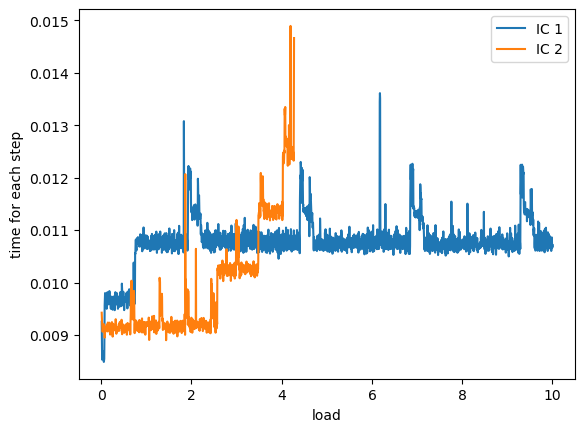

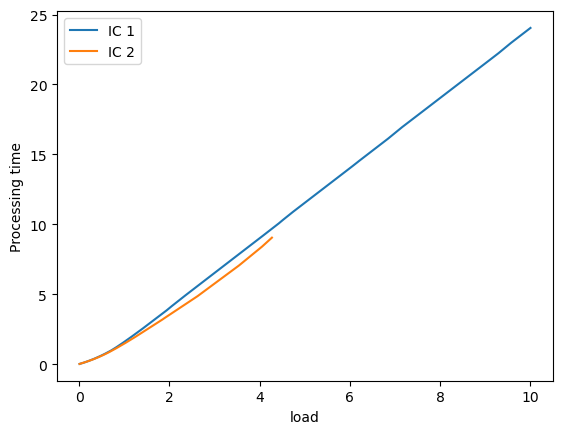

In [32]:
plt.plot(converged_loads1, steps1, label='IC 1')
plt.plot(converged_loads2, steps2, label='IC 2')
plt.xlabel('load')
plt.ylabel('time for each step')
plt.legend()
plt.show()

plt.plot(converged_loads1, Cumulative(steps1), label='IC 1')
plt.plot(converged_loads2, Cumulative(steps2), label='IC 2')
plt.xlabel('load')
plt.ylabel('Processing time')
plt.legend()
plt.show()

## Iterating to reach final load - arc length constraint and initial predictions updated
* the predicted solution is updated so as to lie on the ellipse of the arc length constraint making that term in the residual approach 0
* Using scheme 2 which has faster processing times - incrementing load and displacements proportionally to the axes lengths of ellipse
* changing the arc length constraint at the end of each step to better capture the relative proportion of variation of displacement and load, making the constraint adapt and reduce running times

In [33]:
#initializing converged solution
temp = f_old.vector()[:]
temp[:-1] = u_first.vector()[:]
temp[-1] = 0.0
f_old.vector()[:] = temp

#initial prediction on the ellipse
temp = f.vector()[:]
temp[:-1] = u_first.vector()[:] + scaling_factor*(u_second.vector()[:] - u_first.vector()[:])
temp[-1] = load_norm
f.vector()[:] = temp

steps3 = []
converged_loads3 = []

while f_old.vector()[:][-1] < 10:
    step_start = time.time()
    print("Arc length constraint : ", norm(assemble(arc_length_constraint)))
    try: 
        solve(residual==0, f, [bc_left])
    except:
        break
    
    steps3.append(time.time() - step_start)
        
    #change the ellipse
    u_norm2.assign(assemble(dot(u - u_old, u - u_old)*dx))
    load_norm .assign(f.vector()[:][-1] - f_old.vector()[:][-1])
    
    #prediction on ellipse
    temp = 2*f.vector()[:] - f_old.vector()[:]
    f_old.vector()[:] = f.vector()
    f.vector()[:] = temp
    
    time.sleep(1e-3)
    converged_loads3.append(f_old.vector()[:][-1])

final_load = f_old.vector()[:][-1]
print("Final load : ", final_load)

Arc length constraint :  8.25294693695966e-16
        No Jacobian form specified for nonlinear variational problem.
        Differentiating residual form F to obtain Jacobian J = F'.
        Solving nonlinear variational problem.
          Newton iteration 0: r (abs) = 1.142e-01 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
          Newton iteration 1: r (abs) = 2.326e-01 (tol = 1.000e-10) r (rel) = 2.036e+00 (tol = 1.000e-09)
          Newton iteration 2: r (abs) = 2.860e-02 (tol = 1.000e-10) r (rel) = 2.504e-01 (tol = 1.000e-09)
          Newton iteration 3: r (abs) = 1.163e-04 (tol = 1.000e-10) r (rel) = 1.018e-03 (tol = 1.000e-09)
          Newton iteration 4: r (abs) = 1.690e-09 (tol = 1.000e-10) r (rel) = 1.480e-08 (tol = 1.000e-09)
          Newton iteration 5: r (abs) = 2.848e-16 (tol = 1.000e-10) r (rel) = 2.493e-15 (tol = 1.000e-09)
          Newton solver finished in 5 iterations and 5 linear solver iterations.
Arc length constraint :  2.6020852139652106e-17
     

Arc length constraint :  1.5161483180037294e-15
        No Jacobian form specified for nonlinear variational problem.
        Differentiating residual form F to obtain Jacobian J = F'.
        Solving nonlinear variational problem.
          Newton iteration 0: r (abs) = 3.866e-05 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
          Newton iteration 1: r (abs) = 6.722e-05 (tol = 1.000e-10) r (rel) = 1.739e+00 (tol = 1.000e-09)
          Newton iteration 2: r (abs) = 5.649e-10 (tol = 1.000e-10) r (rel) = 1.461e-05 (tol = 1.000e-09)
          Newton iteration 3: r (abs) = 1.519e-15 (tol = 1.000e-10) r (rel) = 3.928e-11 (tol = 1.000e-09)
          Newton solver finished in 3 iterations and 3 linear solver iterations.
Arc length constraint :  9.072603779358701e-16
        No Jacobian form specified for nonlinear variational problem.
        Differentiating residual form F to obtain Jacobian J = F'.
        Solving nonlinear variational problem.
          Newton iteration 0: r 

Arc length constraint :  9.8879238130678e-17
        No Jacobian form specified for nonlinear variational problem.
        Differentiating residual form F to obtain Jacobian J = F'.
        Solving nonlinear variational problem.
          Newton iteration 0: r (abs) = 2.839e-05 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
          Newton iteration 1: r (abs) = 3.588e-05 (tol = 1.000e-10) r (rel) = 1.264e+00 (tol = 1.000e-09)
          Newton iteration 2: r (abs) = 1.609e-10 (tol = 1.000e-10) r (rel) = 5.668e-06 (tol = 1.000e-09)
          Newton iteration 3: r (abs) = 5.088e-15 (tol = 1.000e-10) r (rel) = 1.792e-10 (tol = 1.000e-09)
          Newton solver finished in 3 iterations and 3 linear solver iterations.
Arc length constraint :  2.0296264668928643e-16
        No Jacobian form specified for nonlinear variational problem.
        Differentiating residual form F to obtain Jacobian J = F'.
        Solving nonlinear variational problem.
          Newton iteration 0: r (a

Arc length constraint :  5.273559366969494e-16
        No Jacobian form specified for nonlinear variational problem.
        Differentiating residual form F to obtain Jacobian J = F'.
        Solving nonlinear variational problem.
          Newton iteration 0: r (abs) = 2.150e-05 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
          Newton iteration 1: r (abs) = 1.508e-05 (tol = 1.000e-10) r (rel) = 7.014e-01 (tol = 1.000e-09)
          Newton iteration 2: r (abs) = 2.842e-11 (tol = 1.000e-10) r (rel) = 1.322e-06 (tol = 1.000e-09)
          Newton solver finished in 2 iterations and 2 linear solver iterations.
Arc length constraint :  3.625572064791527e-16
        No Jacobian form specified for nonlinear variational problem.
        Differentiating residual form F to obtain Jacobian J = F'.
        Solving nonlinear variational problem.
          Newton iteration 0: r (abs) = 2.132e-05 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
          Newton iteration 1: r (

Arc length constraint :  5.637851296924623e-16
        No Jacobian form specified for nonlinear variational problem.
        Differentiating residual form F to obtain Jacobian J = F'.
        Solving nonlinear variational problem.
          Newton iteration 0: r (abs) = 1.755e-05 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
          Newton iteration 1: r (abs) = 5.631e-06 (tol = 1.000e-10) r (rel) = 3.209e-01 (tol = 1.000e-09)
          Newton iteration 2: r (abs) = 3.975e-12 (tol = 1.000e-10) r (rel) = 2.266e-07 (tol = 1.000e-09)
          Newton solver finished in 2 iterations and 2 linear solver iterations.
Arc length constraint :  2.518818487118324e-15
        No Jacobian form specified for nonlinear variational problem.
        Differentiating residual form F to obtain Jacobian J = F'.
        Solving nonlinear variational problem.
          Newton iteration 0: r (abs) = 1.744e-05 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
          Newton iteration 1: r (

Arc length constraint :  1.4068607390171906e-15
        No Jacobian form specified for nonlinear variational problem.
        Differentiating residual form F to obtain Jacobian J = F'.
        Solving nonlinear variational problem.
          Newton iteration 0: r (abs) = 1.517e-05 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
          Newton iteration 1: r (abs) = 2.088e-06 (tol = 1.000e-10) r (rel) = 1.376e-01 (tol = 1.000e-09)
          Newton iteration 2: r (abs) = 5.653e-13 (tol = 1.000e-10) r (rel) = 3.726e-08 (tol = 1.000e-09)
          Newton solver finished in 2 iterations and 2 linear solver iterations.
Arc length constraint :  4.683753385137379e-17
        No Jacobian form specified for nonlinear variational problem.
        Differentiating residual form F to obtain Jacobian J = F'.
        Solving nonlinear variational problem.
          Newton iteration 0: r (abs) = 1.511e-05 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
          Newton iteration 1: r 

Arc length constraint :  4.768754835460243e-15
        No Jacobian form specified for nonlinear variational problem.
        Differentiating residual form F to obtain Jacobian J = F'.
        Solving nonlinear variational problem.
          Newton iteration 0: r (abs) = 1.354e-05 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
          Newton iteration 1: r (abs) = 8.094e-07 (tol = 1.000e-10) r (rel) = 5.977e-02 (tol = 1.000e-09)
          Newton iteration 2: r (abs) = 1.121e-13 (tol = 1.000e-10) r (rel) = 8.279e-09 (tol = 1.000e-09)
          Newton solver finished in 2 iterations and 2 linear solver iterations.
Arc length constraint :  1.2299189444675562e-15
        No Jacobian form specified for nonlinear variational problem.
        Differentiating residual form F to obtain Jacobian J = F'.
        Solving nonlinear variational problem.
          Newton iteration 0: r (abs) = 1.350e-05 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
          Newton iteration 1: r 

Arc length constraint :  5.511216483178316e-15
        No Jacobian form specified for nonlinear variational problem.
        Differentiating residual form F to obtain Jacobian J = F'.
        Solving nonlinear variational problem.
          Newton iteration 0: r (abs) = 1.231e-05 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
          Newton iteration 1: r (abs) = 3.375e-07 (tol = 1.000e-10) r (rel) = 2.742e-02 (tol = 1.000e-09)
          Newton iteration 2: r (abs) = 2.093e-14 (tol = 1.000e-10) r (rel) = 1.700e-09 (tol = 1.000e-09)
          Newton solver finished in 2 iterations and 2 linear solver iterations.
Arc length constraint :  2.2776919239575477e-15
        No Jacobian form specified for nonlinear variational problem.
        Differentiating residual form F to obtain Jacobian J = F'.
        Solving nonlinear variational problem.
          Newton iteration 0: r (abs) = 1.227e-05 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
          Newton iteration 1: r 

Arc length constraint :  1.1149067780102939e-14
        No Jacobian form specified for nonlinear variational problem.
        Differentiating residual form F to obtain Jacobian J = F'.
        Solving nonlinear variational problem.
          Newton iteration 0: r (abs) = 1.132e-05 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
          Newton iteration 1: r (abs) = 1.533e-07 (tol = 1.000e-10) r (rel) = 1.354e-02 (tol = 1.000e-09)
          Newton iteration 2: r (abs) = 3.037e-14 (tol = 1.000e-10) r (rel) = 2.684e-09 (tol = 1.000e-09)
          Newton solver finished in 2 iterations and 2 linear solver iterations.
Arc length constraint :  2.463307335887066e-16
        No Jacobian form specified for nonlinear variational problem.
        Differentiating residual form F to obtain Jacobian J = F'.
        Solving nonlinear variational problem.
          Newton iteration 0: r (abs) = 1.129e-05 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
          Newton iteration 1: r 

Arc length constraint :  9.653736143810931e-15
        No Jacobian form specified for nonlinear variational problem.
        Differentiating residual form F to obtain Jacobian J = F'.
        Solving nonlinear variational problem.
          Newton iteration 0: r (abs) = 1.049e-05 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
          Newton iteration 1: r (abs) = 7.599e-08 (tol = 1.000e-10) r (rel) = 7.244e-03 (tol = 1.000e-09)
          Newton iteration 2: r (abs) = 2.461e-14 (tol = 1.000e-10) r (rel) = 2.346e-09 (tol = 1.000e-09)
          Newton solver finished in 2 iterations and 2 linear solver iterations.
Arc length constraint :  5.018555016000903e-15
        No Jacobian form specified for nonlinear variational problem.
        Differentiating residual form F to obtain Jacobian J = F'.
        Solving nonlinear variational problem.
          Newton iteration 0: r (abs) = 1.046e-05 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
          Newton iteration 1: r (

Arc length constraint :  5.977857098216077e-15
        No Jacobian form specified for nonlinear variational problem.
        Differentiating residual form F to obtain Jacobian J = F'.
        Solving nonlinear variational problem.
          Newton iteration 0: r (abs) = 9.782e-06 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
          Newton iteration 1: r (abs) = 4.098e-08 (tol = 1.000e-10) r (rel) = 4.190e-03 (tol = 1.000e-09)
          Newton iteration 2: r (abs) = 2.887e-14 (tol = 1.000e-10) r (rel) = 2.951e-09 (tol = 1.000e-09)
          Newton solver finished in 2 iterations and 2 linear solver iterations.
Arc length constraint :  1.384309333829492e-15
        No Jacobian form specified for nonlinear variational problem.
        Differentiating residual form F to obtain Jacobian J = F'.
        Solving nonlinear variational problem.
          Newton iteration 0: r (abs) = 9.759e-06 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
          Newton iteration 1: r (

Arc length constraint :  3.2057689836051395e-15
        No Jacobian form specified for nonlinear variational problem.
        Differentiating residual form F to obtain Jacobian J = F'.
        Solving nonlinear variational problem.
          Newton iteration 0: r (abs) = 9.165e-06 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
          Newton iteration 1: r (abs) = 2.383e-08 (tol = 1.000e-10) r (rel) = 2.600e-03 (tol = 1.000e-09)
          Newton iteration 2: r (abs) = 1.498e-14 (tol = 1.000e-10) r (rel) = 1.634e-09 (tol = 1.000e-09)
          Newton solver finished in 2 iterations and 2 linear solver iterations.
Arc length constraint :  4.957839694341715e-15
        No Jacobian form specified for nonlinear variational problem.
        Differentiating residual form F to obtain Jacobian J = F'.
        Solving nonlinear variational problem.
          Newton iteration 0: r (abs) = 9.145e-06 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
          Newton iteration 1: r 

Arc length constraint :  1.0054457266761574e-14
        No Jacobian form specified for nonlinear variational problem.
        Differentiating residual form F to obtain Jacobian J = F'.
        Solving nonlinear variational problem.
          Newton iteration 0: r (abs) = 8.622e-06 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
          Newton iteration 1: r (abs) = 1.478e-08 (tol = 1.000e-10) r (rel) = 1.714e-03 (tol = 1.000e-09)
          Newton iteration 2: r (abs) = 5.754e-14 (tol = 1.000e-10) r (rel) = 6.674e-09 (tol = 1.000e-09)
          Newton solver finished in 2 iterations and 2 linear solver iterations.
Arc length constraint :  7.193898254875819e-15
        No Jacobian form specified for nonlinear variational problem.
        Differentiating residual form F to obtain Jacobian J = F'.
        Solving nonlinear variational problem.
          Newton iteration 0: r (abs) = 8.604e-06 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
          Newton iteration 1: r 

Arc length constraint :  5.3637649877202875e-15
        No Jacobian form specified for nonlinear variational problem.
        Differentiating residual form F to obtain Jacobian J = F'.
        Solving nonlinear variational problem.
          Newton iteration 0: r (abs) = 8.138e-06 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
          Newton iteration 1: r (abs) = 9.660e-09 (tol = 1.000e-10) r (rel) = 1.187e-03 (tol = 1.000e-09)
          Newton iteration 2: r (abs) = 2.838e-14 (tol = 1.000e-10) r (rel) = 3.487e-09 (tol = 1.000e-09)
          Newton solver finished in 2 iterations and 2 linear solver iterations.
Arc length constraint :  8.737802148495177e-15
        No Jacobian form specified for nonlinear variational problem.
        Differentiating residual form F to obtain Jacobian J = F'.
        Solving nonlinear variational problem.
          Newton iteration 0: r (abs) = 8.123e-06 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
          Newton iteration 1: r 

Arc length constraint :  3.328934350399493e-15
        No Jacobian form specified for nonlinear variational problem.
        Differentiating residual form F to obtain Jacobian J = F'.
        Solving nonlinear variational problem.
          Newton iteration 0: r (abs) = 7.705e-06 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
          Newton iteration 1: r (abs) = 6.590e-09 (tol = 1.000e-10) r (rel) = 8.553e-04 (tol = 1.000e-09)
          Newton iteration 2: r (abs) = 4.134e-14 (tol = 1.000e-10) r (rel) = 5.365e-09 (tol = 1.000e-09)
          Newton solver finished in 2 iterations and 2 linear solver iterations.
Arc length constraint :  1.0609568779074152e-14
        No Jacobian form specified for nonlinear variational problem.
        Differentiating residual form F to obtain Jacobian J = F'.
        Solving nonlinear variational problem.
          Newton iteration 0: r (abs) = 7.691e-06 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
          Newton iteration 1: r 

Arc length constraint :  1.4325346464616473e-14
        No Jacobian form specified for nonlinear variational problem.
        Differentiating residual form F to obtain Jacobian J = F'.
        Solving nonlinear variational problem.
          Newton iteration 0: r (abs) = 7.314e-06 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
          Newton iteration 1: r (abs) = 4.653e-09 (tol = 1.000e-10) r (rel) = 6.362e-04 (tol = 1.000e-09)
          Newton iteration 2: r (abs) = 3.368e-15 (tol = 1.000e-10) r (rel) = 4.605e-10 (tol = 1.000e-09)
          Newton solver finished in 2 iterations and 2 linear solver iterations.
Arc length constraint :  1.3860440573054689e-15
        No Jacobian form specified for nonlinear variational problem.
        Differentiating residual form F to obtain Jacobian J = F'.
        Solving nonlinear variational problem.
          Newton iteration 0: r (abs) = 7.301e-06 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
          Newton iteration 1: r

Arc length constraint :  2.9559688030644793e-15
        No Jacobian form specified for nonlinear variational problem.
        Differentiating residual form F to obtain Jacobian J = F'.
        Solving nonlinear variational problem.
          Newton iteration 0: r (abs) = 6.959e-06 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
          Newton iteration 1: r (abs) = 3.377e-09 (tol = 1.000e-10) r (rel) = 4.853e-04 (tol = 1.000e-09)
          Newton iteration 2: r (abs) = 6.721e-14 (tol = 1.000e-10) r (rel) = 9.658e-09 (tol = 1.000e-09)
          Newton solver finished in 2 iterations and 2 linear solver iterations.
Arc length constraint :  1.3808398868775384e-15
        No Jacobian form specified for nonlinear variational problem.
        Differentiating residual form F to obtain Jacobian J = F'.
        Solving nonlinear variational problem.
          Newton iteration 0: r (abs) = 6.948e-06 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
          Newton iteration 1: r

Arc length constraint :  6.572867250476122e-15
        No Jacobian form specified for nonlinear variational problem.
        Differentiating residual form F to obtain Jacobian J = F'.
        Solving nonlinear variational problem.
          Newton iteration 0: r (abs) = 6.636e-06 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
          Newton iteration 1: r (abs) = 2.508e-09 (tol = 1.000e-10) r (rel) = 3.779e-04 (tol = 1.000e-09)
          Newton iteration 2: r (abs) = 4.223e-14 (tol = 1.000e-10) r (rel) = 6.365e-09 (tol = 1.000e-09)
          Newton solver finished in 2 iterations and 2 linear solver iterations.
Arc length constraint :  1.2731135590193787e-14
        No Jacobian form specified for nonlinear variational problem.
        Differentiating residual form F to obtain Jacobian J = F'.
        Solving nonlinear variational problem.
          Newton iteration 0: r (abs) = 6.625e-06 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
          Newton iteration 1: r 

Arc length constraint :  5.9119376061289586e-15
        No Jacobian form specified for nonlinear variational problem.
        Differentiating residual form F to obtain Jacobian J = F'.
        Solving nonlinear variational problem.
          Newton iteration 0: r (abs) = 6.339e-06 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
          Newton iteration 1: r (abs) = 1.898e-09 (tol = 1.000e-10) r (rel) = 2.993e-04 (tol = 1.000e-09)
          Newton iteration 2: r (abs) = 8.142e-14 (tol = 1.000e-10) r (rel) = 1.284e-08 (tol = 1.000e-09)
          Newton solver finished in 2 iterations and 2 linear solver iterations.
Arc length constraint :  5.100087019371813e-16
        No Jacobian form specified for nonlinear variational problem.
        Differentiating residual form F to obtain Jacobian J = F'.
        Solving nonlinear variational problem.
          Newton iteration 0: r (abs) = 6.330e-06 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
          Newton iteration 1: r 

        No Jacobian form specified for nonlinear variational problem.
        Differentiating residual form F to obtain Jacobian J = F'.
        Solving nonlinear variational problem.
          Newton iteration 0: r (abs) = 6.113e-06 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
          Newton iteration 1: r (abs) = 1.525e-09 (tol = 1.000e-10) r (rel) = 2.495e-04 (tol = 1.000e-09)
          Newton iteration 2: r (abs) = 5.420e-14 (tol = 1.000e-10) r (rel) = 8.868e-09 (tol = 1.000e-09)
          Newton solver finished in 2 iterations and 2 linear solver iterations.
Arc length constraint :  2.949029909160572e-17
        No Jacobian form specified for nonlinear variational problem.
        Differentiating residual form F to obtain Jacobian J = F'.
        Solving nonlinear variational problem.
          Newton iteration 0: r (abs) = 6.104e-06 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
          Newton iteration 1: r (abs) = 1.512e-09 (tol = 1.000e-10) r (rel) = 2.

Arc length constraint :  2.481348460037225e-14
        No Jacobian form specified for nonlinear variational problem.
        Differentiating residual form F to obtain Jacobian J = F'.
        Solving nonlinear variational problem.
          Newton iteration 0: r (abs) = 5.867e-06 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
          Newton iteration 1: r (abs) = 1.197e-09 (tol = 1.000e-10) r (rel) = 2.040e-04 (tol = 1.000e-09)
          Newton iteration 2: r (abs) = 8.324e-14 (tol = 1.000e-10) r (rel) = 1.419e-08 (tol = 1.000e-09)
          Newton solver finished in 2 iterations and 2 linear solver iterations.
Arc length constraint :  8.515757543570146e-15
        No Jacobian form specified for nonlinear variational problem.
        Differentiating residual form F to obtain Jacobian J = F'.
        Solving nonlinear variational problem.
          Newton iteration 0: r (abs) = 5.858e-06 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
          Newton iteration 1: r (

Arc length constraint :  2.654126918244515e-16
        No Jacobian form specified for nonlinear variational problem.
        Differentiating residual form F to obtain Jacobian J = F'.
        Solving nonlinear variational problem.
          Newton iteration 0: r (abs) = 5.639e-06 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
          Newton iteration 1: r (abs) = 9.502e-10 (tol = 1.000e-10) r (rel) = 1.685e-04 (tol = 1.000e-09)
          Newton iteration 2: r (abs) = 5.168e-14 (tol = 1.000e-10) r (rel) = 9.166e-09 (tol = 1.000e-09)
          Newton solver finished in 2 iterations and 2 linear solver iterations.
Arc length constraint :  1.798908244587949e-15
        No Jacobian form specified for nonlinear variational problem.
        Differentiating residual form F to obtain Jacobian J = F'.
        Solving nonlinear variational problem.
          Newton iteration 0: r (abs) = 5.631e-06 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
          Newton iteration 1: r (

Arc length constraint :  1.0179357357031904e-14
        No Jacobian form specified for nonlinear variational problem.
        Differentiating residual form F to obtain Jacobian J = F'.
        Solving nonlinear variational problem.
          Newton iteration 0: r (abs) = 5.434e-06 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
          Newton iteration 1: r (abs) = 7.685e-10 (tol = 1.000e-10) r (rel) = 1.414e-04 (tol = 1.000e-09)
          Newton iteration 2: r (abs) = 7.675e-14 (tol = 1.000e-10) r (rel) = 1.412e-08 (tol = 1.000e-09)
          Newton solver finished in 2 iterations and 2 linear solver iterations.
Arc length constraint :  1.5189238755652923e-14
        No Jacobian form specified for nonlinear variational problem.
        Differentiating residual form F to obtain Jacobian J = F'.
        Solving nonlinear variational problem.
          Newton iteration 0: r (abs) = 5.427e-06 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
          Newton iteration 1: r

Arc length constraint :  1.0297318553398327e-14
        No Jacobian form specified for nonlinear variational problem.
        Differentiating residual form F to obtain Jacobian J = F'.
        Solving nonlinear variational problem.
          Newton iteration 0: r (abs) = 5.231e-06 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
          Newton iteration 1: r (abs) = 6.182e-10 (tol = 1.000e-10) r (rel) = 1.182e-04 (tol = 1.000e-09)
          Newton iteration 2: r (abs) = 6.907e-14 (tol = 1.000e-10) r (rel) = 1.320e-08 (tol = 1.000e-09)
          Newton solver finished in 2 iterations and 2 linear solver iterations.
Arc length constraint :  1.4063403219743975e-14
        No Jacobian form specified for nonlinear variational problem.
        Differentiating residual form F to obtain Jacobian J = F'.
        Solving nonlinear variational problem.
          Newton iteration 0: r (abs) = 5.224e-06 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
          Newton iteration 1: r

Arc length constraint :  2.5972279882324756e-14
        No Jacobian form specified for nonlinear variational problem.
        Differentiating residual form F to obtain Jacobian J = F'.
        Solving nonlinear variational problem.
          Newton iteration 0: r (abs) = 5.041e-06 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
          Newton iteration 1: r (abs) = 5.024e-10 (tol = 1.000e-10) r (rel) = 9.966e-05 (tol = 1.000e-09)
          Newton iteration 2: r (abs) = 5.901e-14 (tol = 1.000e-10) r (rel) = 1.171e-08 (tol = 1.000e-09)
          Newton solver finished in 2 iterations and 2 linear solver iterations.
Arc length constraint :  2.768618667658984e-15
        No Jacobian form specified for nonlinear variational problem.
        Differentiating residual form F to obtain Jacobian J = F'.
        Solving nonlinear variational problem.
          Newton iteration 0: r (abs) = 5.035e-06 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
          Newton iteration 1: r 

Arc length constraint :  1.2184697695261093e-14
        No Jacobian form specified for nonlinear variational problem.
        Differentiating residual form F to obtain Jacobian J = F'.
        Solving nonlinear variational problem.
          Newton iteration 0: r (abs) = 4.866e-06 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
          Newton iteration 1: r (abs) = 4.126e-10 (tol = 1.000e-10) r (rel) = 8.479e-05 (tol = 1.000e-09)
          Newton iteration 2: r (abs) = 1.503e-13 (tol = 1.000e-10) r (rel) = 3.089e-08 (tol = 1.000e-09)
          Newton solver finished in 2 iterations and 2 linear solver iterations.
Arc length constraint :  1.7898876825128696e-14
        No Jacobian form specified for nonlinear variational problem.
        Differentiating residual form F to obtain Jacobian J = F'.
        Solving nonlinear variational problem.
          Newton iteration 0: r (abs) = 4.860e-06 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
          Newton iteration 1: r

Arc length constraint :  9.695369507234375e-15
        No Jacobian form specified for nonlinear variational problem.
        Differentiating residual form F to obtain Jacobian J = F'.
        Solving nonlinear variational problem.
          Newton iteration 0: r (abs) = 4.702e-06 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
          Newton iteration 1: r (abs) = 3.429e-10 (tol = 1.000e-10) r (rel) = 7.293e-05 (tol = 1.000e-09)
          Newton iteration 2: r (abs) = 8.793e-14 (tol = 1.000e-10) r (rel) = 1.870e-08 (tol = 1.000e-09)
          Newton solver finished in 2 iterations and 2 linear solver iterations.
Arc length constraint :  9.221789998292707e-15
        No Jacobian form specified for nonlinear variational problem.
        Differentiating residual form F to obtain Jacobian J = F'.
        Solving nonlinear variational problem.
          Newton iteration 0: r (abs) = 4.697e-06 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
          Newton iteration 1: r (

Arc length constraint :  1.743397093356691e-14
        No Jacobian form specified for nonlinear variational problem.
        Differentiating residual form F to obtain Jacobian J = F'.
        Solving nonlinear variational problem.
          Newton iteration 0: r (abs) = 4.550e-06 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
          Newton iteration 1: r (abs) = 2.891e-10 (tol = 1.000e-10) r (rel) = 6.354e-05 (tol = 1.000e-09)
          Newton iteration 2: r (abs) = 9.465e-14 (tol = 1.000e-10) r (rel) = 2.080e-08 (tol = 1.000e-09)
          Newton solver finished in 2 iterations and 2 linear solver iterations.
Arc length constraint :  1.5248219353836134e-14
        No Jacobian form specified for nonlinear variational problem.
        Differentiating residual form F to obtain Jacobian J = F'.
        Solving nonlinear variational problem.
          Newton iteration 0: r (abs) = 4.545e-06 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
          Newton iteration 1: r 

Arc length constraint :  6.95450641519102e-15
        No Jacobian form specified for nonlinear variational problem.
        Differentiating residual form F to obtain Jacobian J = F'.
        Solving nonlinear variational problem.
          Newton iteration 0: r (abs) = 4.406e-06 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
          Newton iteration 1: r (abs) = 2.471e-10 (tol = 1.000e-10) r (rel) = 5.608e-05 (tol = 1.000e-09)
          Newton iteration 2: r (abs) = 8.859e-14 (tol = 1.000e-10) r (rel) = 2.011e-08 (tol = 1.000e-09)
          Newton solver finished in 2 iterations and 2 linear solver iterations.
Arc length constraint :  3.073929999430902e-15
        No Jacobian form specified for nonlinear variational problem.
        Differentiating residual form F to obtain Jacobian J = F'.
        Solving nonlinear variational problem.
          Newton iteration 0: r (abs) = 4.401e-06 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
          Newton iteration 1: r (a

Arc length constraint :  1.3645334862033565e-14
        No Jacobian form specified for nonlinear variational problem.
        Differentiating residual form F to obtain Jacobian J = F'.
        Solving nonlinear variational problem.
          Newton iteration 0: r (abs) = 4.267e-06 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
          Newton iteration 1: r (abs) = 2.125e-10 (tol = 1.000e-10) r (rel) = 4.979e-05 (tol = 1.000e-09)
          Newton iteration 2: r (abs) = 2.077e-14 (tol = 1.000e-10) r (rel) = 4.868e-09 (tol = 1.000e-09)
          Newton solver finished in 2 iterations and 2 linear solver iterations.
Arc length constraint :  1.1260090082565455e-14
        No Jacobian form specified for nonlinear variational problem.
        Differentiating residual form F to obtain Jacobian J = F'.
        Solving nonlinear variational problem.
          Newton iteration 0: r (abs) = 4.262e-06 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
          Newton iteration 1: r

Arc length constraint :  1.9491352976075405e-14
        No Jacobian form specified for nonlinear variational problem.
        Differentiating residual form F to obtain Jacobian J = F'.
        Solving nonlinear variational problem.
          Newton iteration 0: r (abs) = 4.129e-06 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
          Newton iteration 1: r (abs) = 1.810e-10 (tol = 1.000e-10) r (rel) = 4.384e-05 (tol = 1.000e-09)
          Newton iteration 2: r (abs) = 3.567e-14 (tol = 1.000e-10) r (rel) = 8.639e-09 (tol = 1.000e-09)
          Newton solver finished in 2 iterations and 2 linear solver iterations.
Arc length constraint :  2.341182803178299e-14
        No Jacobian form specified for nonlinear variational problem.
        Differentiating residual form F to obtain Jacobian J = F'.
        Solving nonlinear variational problem.
          Newton iteration 0: r (abs) = 4.125e-06 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
          Newton iteration 1: r 

Arc length constraint :  4.0939474033052647e-16
        No Jacobian form specified for nonlinear variational problem.
        Differentiating residual form F to obtain Jacobian J = F'.
        Solving nonlinear variational problem.
          Newton iteration 0: r (abs) = 3.996e-06 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
          Newton iteration 1: r (abs) = 1.526e-10 (tol = 1.000e-10) r (rel) = 3.818e-05 (tol = 1.000e-09)
          Newton iteration 2: r (abs) = 2.608e-14 (tol = 1.000e-10) r (rel) = 6.526e-09 (tol = 1.000e-09)
          Newton solver finished in 2 iterations and 2 linear solver iterations.
Arc length constraint :  3.0253577421035516e-15
        No Jacobian form specified for nonlinear variational problem.
        Differentiating residual form F to obtain Jacobian J = F'.
        Solving nonlinear variational problem.
          Newton iteration 0: r (abs) = 3.992e-06 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
          Newton iteration 1: r

Arc length constraint :  6.853892453584365e-15
        No Jacobian form specified for nonlinear variational problem.
        Differentiating residual form F to obtain Jacobian J = F'.
        Solving nonlinear variational problem.
          Newton iteration 0: r (abs) = 3.876e-06 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
          Newton iteration 1: r (abs) = 1.297e-10 (tol = 1.000e-10) r (rel) = 3.348e-05 (tol = 1.000e-09)
          Newton iteration 2: r (abs) = 8.840e-14 (tol = 1.000e-10) r (rel) = 2.281e-08 (tol = 1.000e-09)
          Newton solver finished in 2 iterations and 2 linear solver iterations.
Arc length constraint :  3.651592916931179e-15
        No Jacobian form specified for nonlinear variational problem.
        Differentiating residual form F to obtain Jacobian J = F'.
        Solving nonlinear variational problem.
          Newton iteration 0: r (abs) = 3.872e-06 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
          Newton iteration 1: r (

Arc length constraint :  4.345482307321902e-15
        No Jacobian form specified for nonlinear variational problem.
        Differentiating residual form F to obtain Jacobian J = F'.
        Solving nonlinear variational problem.
          Newton iteration 0: r (abs) = 3.771e-06 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
          Newton iteration 1: r (abs) = 1.124e-10 (tol = 1.000e-10) r (rel) = 2.982e-05 (tol = 1.000e-09)
          Newton iteration 2: r (abs) = 9.421e-14 (tol = 1.000e-10) r (rel) = 2.498e-08 (tol = 1.000e-09)
          Newton solver finished in 2 iterations and 2 linear solver iterations.
Arc length constraint :  5.754077769815069e-15
        No Jacobian form specified for nonlinear variational problem.
        Differentiating residual form F to obtain Jacobian J = F'.
        Solving nonlinear variational problem.
          Newton iteration 0: r (abs) = 3.768e-06 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
          Newton iteration 1: r (

Arc length constraint :  4.332992298294869e-14
        No Jacobian form specified for nonlinear variational problem.
        Differentiating residual form F to obtain Jacobian J = F'.
        Solving nonlinear variational problem.
          Newton iteration 0: r (abs) = 3.676e-06 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
          Newton iteration 1: r (abs) = 9.780e-11 (tol = 1.000e-10) r (rel) = 2.660e-05 (tol = 1.000e-09)
          Newton solver finished in 1 iterations and 1 linear solver iterations.
Arc length constraint :  1.1901937768676873e-14
        No Jacobian form specified for nonlinear variational problem.
        Differentiating residual form F to obtain Jacobian J = F'.
        Solving nonlinear variational problem.
          Newton iteration 0: r (abs) = 3.673e-06 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
          Newton iteration 1: r (abs) = 9.746e-11 (tol = 1.000e-10) r (rel) = 2.654e-05 (tol = 1.000e-09)
          Newton solver finished

Arc length constraint :  2.369979212879514e-14
        No Jacobian form specified for nonlinear variational problem.
        Differentiating residual form F to obtain Jacobian J = F'.
        Solving nonlinear variational problem.
          Newton iteration 0: r (abs) = 3.577e-06 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
          Newton iteration 1: r (abs) = 8.300e-11 (tol = 1.000e-10) r (rel) = 2.320e-05 (tol = 1.000e-09)
          Newton solver finished in 1 iterations and 1 linear solver iterations.
Arc length constraint :  2.7878740982423267e-14
        No Jacobian form specified for nonlinear variational problem.
        Differentiating residual form F to obtain Jacobian J = F'.
        Solving nonlinear variational problem.
          Newton iteration 0: r (abs) = 3.574e-06 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
          Newton iteration 1: r (abs) = 8.266e-11 (tol = 1.000e-10) r (rel) = 2.313e-05 (tol = 1.000e-09)
          Newton solver finished

Arc length constraint :  1.1152537227054893e-14
        No Jacobian form specified for nonlinear variational problem.
        Differentiating residual form F to obtain Jacobian J = F'.
        Solving nonlinear variational problem.
          Newton iteration 0: r (abs) = 3.482e-06 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
          Newton iteration 1: r (abs) = 7.020e-11 (tol = 1.000e-10) r (rel) = 2.016e-05 (tol = 1.000e-09)
          Newton solver finished in 1 iterations and 1 linear solver iterations.
Arc length constraint :  4.294307964780586e-14
        No Jacobian form specified for nonlinear variational problem.
        Differentiating residual form F to obtain Jacobian J = F'.
        Solving nonlinear variational problem.
          Newton iteration 0: r (abs) = 3.480e-06 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
          Newton iteration 1: r (abs) = 6.956e-11 (tol = 1.000e-10) r (rel) = 1.999e-05 (tol = 1.000e-09)
          Newton solver finished

Arc length constraint :  3.263535275355167e-14
        No Jacobian form specified for nonlinear variational problem.
        Differentiating residual form F to obtain Jacobian J = F'.
        Solving nonlinear variational problem.
          Newton iteration 0: r (abs) = 3.391e-06 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
          Newton iteration 1: r (abs) = 5.858e-11 (tol = 1.000e-10) r (rel) = 1.728e-05 (tol = 1.000e-09)
          Newton solver finished in 1 iterations and 1 linear solver iterations.
Arc length constraint :  2.6303612066236326e-14
        No Jacobian form specified for nonlinear variational problem.
        Differentiating residual form F to obtain Jacobian J = F'.
        Solving nonlinear variational problem.
          Newton iteration 0: r (abs) = 3.388e-06 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
          Newton iteration 1: r (abs) = 5.838e-11 (tol = 1.000e-10) r (rel) = 1.723e-05 (tol = 1.000e-09)
          Newton solver finished

Arc length constraint :  2.6924643070636023e-14
        No Jacobian form specified for nonlinear variational problem.
        Differentiating residual form F to obtain Jacobian J = F'.
        Solving nonlinear variational problem.
          Newton iteration 0: r (abs) = 3.302e-06 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
          Newton iteration 1: r (abs) = 4.899e-11 (tol = 1.000e-10) r (rel) = 1.484e-05 (tol = 1.000e-09)
          Newton solver finished in 1 iterations and 1 linear solver iterations.
Arc length constraint :  4.150846333317304e-14
        No Jacobian form specified for nonlinear variational problem.
        Differentiating residual form F to obtain Jacobian J = F'.
        Solving nonlinear variational problem.
          Newton iteration 0: r (abs) = 3.299e-06 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
          Newton iteration 1: r (abs) = 4.887e-11 (tol = 1.000e-10) r (rel) = 1.481e-05 (tol = 1.000e-09)
          Newton solver finished

Arc length constraint :  3.577520224506969e-14
        No Jacobian form specified for nonlinear variational problem.
        Differentiating residual form F to obtain Jacobian J = F'.
        Solving nonlinear variational problem.
          Newton iteration 0: r (abs) = 3.216e-06 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
          Newton iteration 1: r (abs) = 4.131e-11 (tol = 1.000e-10) r (rel) = 1.284e-05 (tol = 1.000e-09)
          Newton solver finished in 1 iterations and 1 linear solver iterations.
Arc length constraint :  2.293304435241339e-14
        No Jacobian form specified for nonlinear variational problem.
        Differentiating residual form F to obtain Jacobian J = F'.
        Solving nonlinear variational problem.
          Newton iteration 0: r (abs) = 3.214e-06 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
          Newton iteration 1: r (abs) = 4.096e-11 (tol = 1.000e-10) r (rel) = 1.274e-05 (tol = 1.000e-09)
          Newton solver finished 

Arc length constraint :  4.114070195626596e-14
        No Jacobian form specified for nonlinear variational problem.
        Differentiating residual form F to obtain Jacobian J = F'.
        Solving nonlinear variational problem.
          Newton iteration 0: r (abs) = 3.134e-06 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
          Newton iteration 1: r (abs) = 3.470e-11 (tol = 1.000e-10) r (rel) = 1.107e-05 (tol = 1.000e-09)
          Newton solver finished in 1 iterations and 1 linear solver iterations.
Arc length constraint :  1.0422218643668657e-14
        No Jacobian form specified for nonlinear variational problem.
        Differentiating residual form F to obtain Jacobian J = F'.
        Solving nonlinear variational problem.
          Newton iteration 0: r (abs) = 3.132e-06 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
          Newton iteration 1: r (abs) = 3.435e-11 (tol = 1.000e-10) r (rel) = 1.097e-05 (tol = 1.000e-09)
          Newton solver finished

Arc length constraint :  2.7169239080748753e-14
        No Jacobian form specified for nonlinear variational problem.
        Differentiating residual form F to obtain Jacobian J = F'.
        Solving nonlinear variational problem.
          Newton iteration 0: r (abs) = 3.055e-06 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
          Newton iteration 1: r (abs) = 2.921e-11 (tol = 1.000e-10) r (rel) = 9.560e-06 (tol = 1.000e-09)
          Newton solver finished in 1 iterations and 1 linear solver iterations.
Arc length constraint :  4.713243684228985e-15
        No Jacobian form specified for nonlinear variational problem.
        Differentiating residual form F to obtain Jacobian J = F'.
        Solving nonlinear variational problem.
          Newton iteration 0: r (abs) = 3.053e-06 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
          Newton iteration 1: r (abs) = 2.909e-11 (tol = 1.000e-10) r (rel) = 9.528e-06 (tol = 1.000e-09)
          Newton solver finished

Arc length constraint :  4.193347058478736e-14
        No Jacobian form specified for nonlinear variational problem.
        Differentiating residual form F to obtain Jacobian J = F'.
        Solving nonlinear variational problem.
          Newton iteration 0: r (abs) = 2.980e-06 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
          Newton iteration 1: r (abs) = 2.488e-11 (tol = 1.000e-10) r (rel) = 8.350e-06 (tol = 1.000e-09)
          Newton solver finished in 1 iterations and 1 linear solver iterations.
Arc length constraint :  2.2070886784852917e-14
        No Jacobian form specified for nonlinear variational problem.
        Differentiating residual form F to obtain Jacobian J = F'.
        Solving nonlinear variational problem.
          Newton iteration 0: r (abs) = 2.978e-06 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
          Newton iteration 1: r (abs) = 2.483e-11 (tol = 1.000e-10) r (rel) = 8.339e-06 (tol = 1.000e-09)
          Newton solver finished

Arc length constraint :  2.1191381982532675e-14
        No Jacobian form specified for nonlinear variational problem.
        Differentiating residual form F to obtain Jacobian J = F'.
        Solving nonlinear variational problem.
          Newton iteration 0: r (abs) = 2.908e-06 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
          Newton iteration 1: r (abs) = 2.113e-11 (tol = 1.000e-10) r (rel) = 7.265e-06 (tol = 1.000e-09)
          Newton solver finished in 1 iterations and 1 linear solver iterations.
Arc length constraint :  2.412306465693348e-14
        No Jacobian form specified for nonlinear variational problem.
        Differentiating residual form F to obtain Jacobian J = F'.
        Solving nonlinear variational problem.
          Newton iteration 0: r (abs) = 2.906e-06 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
          Newton iteration 1: r (abs) = 2.113e-11 (tol = 1.000e-10) r (rel) = 7.273e-06 (tol = 1.000e-09)
          Newton solver finished

Arc length constraint :  3.3986702341337605e-14
        No Jacobian form specified for nonlinear variational problem.
        Differentiating residual form F to obtain Jacobian J = F'.
        Solving nonlinear variational problem.
          Newton iteration 0: r (abs) = 2.839e-06 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
          Newton iteration 1: r (abs) = 1.806e-11 (tol = 1.000e-10) r (rel) = 6.361e-06 (tol = 1.000e-09)
          Newton solver finished in 1 iterations and 1 linear solver iterations.
Arc length constraint :  3.0709809695217416e-14
        No Jacobian form specified for nonlinear variational problem.
        Differentiating residual form F to obtain Jacobian J = F'.
        Solving nonlinear variational problem.
          Newton iteration 0: r (abs) = 2.837e-06 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
          Newton iteration 1: r (abs) = 1.803e-11 (tol = 1.000e-10) r (rel) = 6.356e-06 (tol = 1.000e-09)
          Newton solver finishe

Arc length constraint :  1.61034380274927e-14
        No Jacobian form specified for nonlinear variational problem.
        Differentiating residual form F to obtain Jacobian J = F'.
        Solving nonlinear variational problem.
          Newton iteration 0: r (abs) = 2.772e-06 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
          Newton iteration 1: r (abs) = 1.564e-11 (tol = 1.000e-10) r (rel) = 5.640e-06 (tol = 1.000e-09)
          Newton solver finished in 1 iterations and 1 linear solver iterations.
Arc length constraint :  4.012415399934355e-15
        No Jacobian form specified for nonlinear variational problem.
        Differentiating residual form F to obtain Jacobian J = F'.
        Solving nonlinear variational problem.
          Newton iteration 0: r (abs) = 2.770e-06 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
          Newton iteration 1: r (abs) = 1.563e-11 (tol = 1.000e-10) r (rel) = 5.642e-06 (tol = 1.000e-09)
          Newton solver finished i

Arc length constraint :  1.9361248715377144e-14
        No Jacobian form specified for nonlinear variational problem.
        Differentiating residual form F to obtain Jacobian J = F'.
        Solving nonlinear variational problem.
          Newton iteration 0: r (abs) = 2.709e-06 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
          Newton iteration 1: r (abs) = 1.333e-11 (tol = 1.000e-10) r (rel) = 4.921e-06 (tol = 1.000e-09)
          Newton solver finished in 1 iterations and 1 linear solver iterations.
Arc length constraint :  1.860837872680321e-14
        No Jacobian form specified for nonlinear variational problem.
        Differentiating residual form F to obtain Jacobian J = F'.
        Solving nonlinear variational problem.
          Newton iteration 0: r (abs) = 2.707e-06 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
          Newton iteration 1: r (abs) = 1.324e-11 (tol = 1.000e-10) r (rel) = 4.892e-06 (tol = 1.000e-09)
          Newton solver finished

Arc length constraint :  4.227868055650674e-14
        No Jacobian form specified for nonlinear variational problem.
        Differentiating residual form F to obtain Jacobian J = F'.
        Solving nonlinear variational problem.
          Newton iteration 0: r (abs) = 2.648e-06 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
          Newton iteration 1: r (abs) = 1.192e-11 (tol = 1.000e-10) r (rel) = 4.500e-06 (tol = 1.000e-09)
          Newton solver finished in 1 iterations and 1 linear solver iterations.
Arc length constraint :  2.871834714479604e-14
        No Jacobian form specified for nonlinear variational problem.
        Differentiating residual form F to obtain Jacobian J = F'.
        Solving nonlinear variational problem.
          Newton iteration 0: r (abs) = 2.647e-06 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
          Newton iteration 1: r (abs) = 1.145e-11 (tol = 1.000e-10) r (rel) = 4.328e-06 (tol = 1.000e-09)
          Newton solver finished 

Arc length constraint :  5.03520836137028e-14
        No Jacobian form specified for nonlinear variational problem.
        Differentiating residual form F to obtain Jacobian J = F'.
        Solving nonlinear variational problem.
          Newton iteration 0: r (abs) = 2.590e-06 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
          Newton iteration 1: r (abs) = 1.033e-11 (tol = 1.000e-10) r (rel) = 3.987e-06 (tol = 1.000e-09)
          Newton solver finished in 1 iterations and 1 linear solver iterations.
Arc length constraint :  6.574775446299697e-14
        No Jacobian form specified for nonlinear variational problem.
        Differentiating residual form F to obtain Jacobian J = F'.
        Solving nonlinear variational problem.
          Newton iteration 0: r (abs) = 2.589e-06 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
          Newton iteration 1: r (abs) = 1.049e-11 (tol = 1.000e-10) r (rel) = 4.051e-06 (tol = 1.000e-09)
          Newton solver finished i

Arc length constraint :  3.756023270184983e-14
        No Jacobian form specified for nonlinear variational problem.
        Differentiating residual form F to obtain Jacobian J = F'.
        Solving nonlinear variational problem.
          Newton iteration 0: r (abs) = 2.534e-06 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
          Newton iteration 1: r (abs) = 9.061e-12 (tol = 1.000e-10) r (rel) = 3.575e-06 (tol = 1.000e-09)
          Newton solver finished in 1 iterations and 1 linear solver iterations.
Arc length constraint :  8.347315894052798e-14
        No Jacobian form specified for nonlinear variational problem.
        Differentiating residual form F to obtain Jacobian J = F'.
        Solving nonlinear variational problem.
          Newton iteration 0: r (abs) = 2.533e-06 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
          Newton iteration 1: r (abs) = 8.761e-12 (tol = 1.000e-10) r (rel) = 3.459e-06 (tol = 1.000e-09)
          Newton solver finished 

Arc length constraint :  2.2983351333216717e-14
        No Jacobian form specified for nonlinear variational problem.
        Differentiating residual form F to obtain Jacobian J = F'.
        Solving nonlinear variational problem.
          Newton iteration 0: r (abs) = 2.481e-06 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
          Newton iteration 1: r (abs) = 8.020e-12 (tol = 1.000e-10) r (rel) = 3.233e-06 (tol = 1.000e-09)
          Newton solver finished in 1 iterations and 1 linear solver iterations.
Arc length constraint :  9.933026623443197e-15
        No Jacobian form specified for nonlinear variational problem.
        Differentiating residual form F to obtain Jacobian J = F'.
        Solving nonlinear variational problem.
          Newton iteration 0: r (abs) = 2.479e-06 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
          Newton iteration 1: r (abs) = 7.958e-12 (tol = 1.000e-10) r (rel) = 3.210e-06 (tol = 1.000e-09)
          Newton solver finished

Arc length constraint :  6.085236481379042e-14
        No Jacobian form specified for nonlinear variational problem.
        Differentiating residual form F to obtain Jacobian J = F'.
        Solving nonlinear variational problem.
          Newton iteration 0: r (abs) = 2.430e-06 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
          Newton iteration 1: r (abs) = 6.925e-12 (tol = 1.000e-10) r (rel) = 2.850e-06 (tol = 1.000e-09)
          Newton solver finished in 1 iterations and 1 linear solver iterations.
Arc length constraint :  3.0465213685104686e-14
        No Jacobian form specified for nonlinear variational problem.
        Differentiating residual form F to obtain Jacobian J = F'.
        Solving nonlinear variational problem.
          Newton iteration 0: r (abs) = 2.428e-06 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
          Newton iteration 1: r (abs) = 7.209e-12 (tol = 1.000e-10) r (rel) = 2.969e-06 (tol = 1.000e-09)
          Newton solver finished

        No Jacobian form specified for nonlinear variational problem.
        Differentiating residual form F to obtain Jacobian J = F'.
        Solving nonlinear variational problem.
          Newton iteration 0: r (abs) = 2.383e-06 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
          Newton iteration 1: r (abs) = 6.259e-12 (tol = 1.000e-10) r (rel) = 2.627e-06 (tol = 1.000e-09)
          Newton solver finished in 1 iterations and 1 linear solver iterations.
Arc length constraint :  1.4448511831410826e-14
        No Jacobian form specified for nonlinear variational problem.
        Differentiating residual form F to obtain Jacobian J = F'.
        Solving nonlinear variational problem.
          Newton iteration 0: r (abs) = 2.382e-06 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
          Newton iteration 1: r (abs) = 6.014e-12 (tol = 1.000e-10) r (rel) = 2.525e-06 (tol = 1.000e-09)
          Newton solver finished in 1 iterations and 1 linear solver iterations

Arc length constraint :  2.8263849594090118e-14
        No Jacobian form specified for nonlinear variational problem.
        Differentiating residual form F to obtain Jacobian J = F'.
        Solving nonlinear variational problem.
          Newton iteration 0: r (abs) = 2.341e-06 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
          Newton iteration 1: r (abs) = 5.751e-12 (tol = 1.000e-10) r (rel) = 2.457e-06 (tol = 1.000e-09)
          Newton solver finished in 1 iterations and 1 linear solver iterations.
Arc length constraint :  5.5077470362263625e-15
        No Jacobian form specified for nonlinear variational problem.
        Differentiating residual form F to obtain Jacobian J = F'.
        Solving nonlinear variational problem.
          Newton iteration 0: r (abs) = 2.340e-06 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
          Newton iteration 1: r (abs) = 5.498e-12 (tol = 1.000e-10) r (rel) = 2.350e-06 (tol = 1.000e-09)
          Newton solver finishe

        No Jacobian form specified for nonlinear variational problem.
        Differentiating residual form F to obtain Jacobian J = F'.
        Solving nonlinear variational problem.
          Newton iteration 0: r (abs) = 2.298e-06 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
          Newton iteration 1: r (abs) = 5.003e-12 (tol = 1.000e-10) r (rel) = 2.177e-06 (tol = 1.000e-09)
          Newton solver finished in 1 iterations and 1 linear solver iterations.
Arc length constraint :  2.770873808177754e-14
        No Jacobian form specified for nonlinear variational problem.
        Differentiating residual form F to obtain Jacobian J = F'.
        Solving nonlinear variational problem.
          Newton iteration 0: r (abs) = 2.296e-06 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
          Newton iteration 1: r (abs) = 5.360e-12 (tol = 1.000e-10) r (rel) = 2.334e-06 (tol = 1.000e-09)
          Newton solver finished in 1 iterations and 1 linear solver iterations.

        No Jacobian form specified for nonlinear variational problem.
        Differentiating residual form F to obtain Jacobian J = F'.
        Solving nonlinear variational problem.
          Newton iteration 0: r (abs) = 2.256e-06 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
          Newton iteration 1: r (abs) = 4.717e-12 (tol = 1.000e-10) r (rel) = 2.091e-06 (tol = 1.000e-09)
          Newton solver finished in 1 iterations and 1 linear solver iterations.
Arc length constraint :  1.800469495716328e-14
        No Jacobian form specified for nonlinear variational problem.
        Differentiating residual form F to obtain Jacobian J = F'.
        Solving nonlinear variational problem.
          Newton iteration 0: r (abs) = 2.255e-06 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
          Newton iteration 1: r (abs) = 4.619e-12 (tol = 1.000e-10) r (rel) = 2.049e-06 (tol = 1.000e-09)
          Newton solver finished in 1 iterations and 1 linear solver iterations.

Arc length constraint :  1.3548190347378863e-14
        No Jacobian form specified for nonlinear variational problem.
        Differentiating residual form F to obtain Jacobian J = F'.
        Solving nonlinear variational problem.
          Newton iteration 0: r (abs) = 2.215e-06 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
          Newton iteration 1: r (abs) = 4.296e-12 (tol = 1.000e-10) r (rel) = 1.939e-06 (tol = 1.000e-09)
          Newton solver finished in 1 iterations and 1 linear solver iterations.
Arc length constraint :  8.898090597675434e-14
        No Jacobian form specified for nonlinear variational problem.
        Differentiating residual form F to obtain Jacobian J = F'.
        Solving nonlinear variational problem.
          Newton iteration 0: r (abs) = 2.214e-06 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
          Newton iteration 1: r (abs) = 4.429e-12 (tol = 1.000e-10) r (rel) = 2.000e-06 (tol = 1.000e-09)
          Newton solver finished

### Measuring performance of prediction schemes and constraint modification 

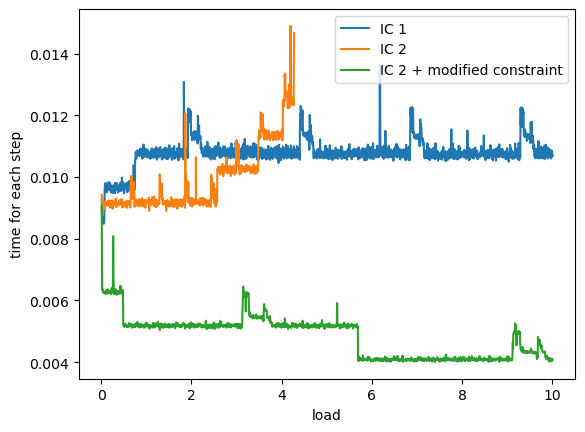

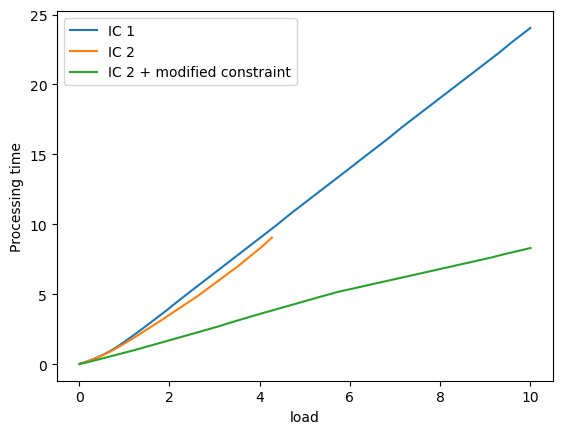

In [34]:
plt.plot(converged_loads1, steps1, label='IC 1')
plt.plot(converged_loads2, steps2, label='IC 2')
plt.plot(converged_loads3, steps3, label='IC 2 + modified constraint')
plt.xlabel('load')
plt.ylabel('time for each step')
plt.legend()
plt.show()

plt.plot(converged_loads1, Cumulative(steps1), label='IC 1')
plt.plot(converged_loads2, Cumulative(steps2), label='IC 2')
plt.plot(converged_loads3, Cumulative(steps3), label='IC 2 + modified constraint')
plt.xlabel('load')
plt.ylabel('Processing time')
plt.legend()
plt.show()